Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

In [9]:
import matplotlib.pyplot as plt


def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)

# Chapter 12 - Backtesting Trading Strategies

**거래 전략 백테스팅**

이전 장에서는 거래 전략을 만드는 데 필요한 지식을 얻었습니다. 한편으로는 기술 분석을 사용하여 거래 기회를 식별할 수 있습니다. 다른 한편으로는 우리가 이미 책에서 다룬 여러 가지 다른 기술을 사용할 수 있습니다. 우리는 예를 들어 미래의 가격 움직임이나 변동성을 예측하기 위해 지식 기반 요인 모델을 사용할 수 있습니다. 또는 우리의 투자를 위한 자산의 최적 수량을 결정하기 위해 포트폴리오 최적화 기술을 사용할 수 있습니다. 여전히 필요한 중요한 한 가지는 우리가 과거에 해당 전략을 구현했다면 어떤 성과를 거두었을지 평가하는 것입니다. 이것이 바로 우리가 이 장에서 탐구할 백테스팅의 목표입니다.

**백테스팅**은 거래 전략의 성과를 과거 데이터를 통해 평가하는 현실적인 시뮬레이션으로 정의될 수 있으며, 이는 실제 시장에서 전략을 사용했을 때의 미래 성과를 나타내야 합니다. 물론 항상 그런 것은 아닐 수 있으며, 실험할 때 이를 염두에 두어야 합니다.

백테스팅 접근 방식에는 여러 가지가 있지만, 백테스트는 시장이 운영되는 방식, 거래가 실행되는 방식, 주문이 가능한 방식 등을 충실히 반영해야 한다는 점을 항상 기억해야 합니다. 예를 들어 거래 비용을 고려하지 않으면 “수익성 있는” 전략이 실패한 실험으로 빠르게 바뀔 수 있습니다.

우리는 이미 현대의 빠르게 변화하는 금융 시장에서의 예측의 일반적인 불확실성을 언급했습니다. 그러나 여기에는 몇 가지 추가적인 구현적 측면이 있으며, 이는 백테스트의 성과를 편향시킬 수 있으며, 일반화 가능한 패턴을 가진 현장 테스트 결과와 일치하지 않는 인샘플 성능(과거의 데이터에서 검증된 성능)의 위험을 증가시킬 수 있습니다. 아래에 언급된 몇 가지를 간략히 설명합니다.

- **보고서 편향(Look-ahead Bias)**: 이는 우리가 과거 데이터를 사용하여 실제로 알려지거나 사용 가능한 것보다 일찍 전략을 개발할 때 발생하는 잠재적 오류입니다. 여기에는 발표 후의 재무 성명서 수정, 주식 분할, 혹은 반전 등이 포함됩니다.

- **생존 편향(Survivorship Bias)**: 이것은 현재 활성화되거나 거래 가능한 자산에만 기반하여 백테스트를 수행할 때 발생하는 오류입니다. 그렇게 함으로써 파산, 상장 폐지, 인수, 합병 등으로 인해 시간이 지남에 따라 소멸한 자산을 무시하게 됩니다. 대부분의 경우 이러한 자산은 과거에 좋지 않은 성과를 보였기 때문에 우리의 전략이 지나치게 긍정적으로 보일 수 있습니다.

- **이상치 탐지 및 처리(Outlier Detection and Treatment)**: 주요 도전 과제는 분석된 기간을 대표하지 않는 이상치를 분석된 기간의 중요한 부분을 대표하는 이상치와 구분하는 것입니다.

- **대표 샘플 기간(Representative Sample Period)**: 백테스트의 목표가 미래 성능에 대한 표시를 제공하는 것인 경우, 샘플 데이터는 현재 및 잠재적으로 미래의 시장 행동을 반영해야 합니다. 이 부분을 충분히 반영하지 않으면 너무 적거나 너무 많은 극단적 이벤트 또는 변동성(데이터 포인트가 너무 적거나 많음)과 같은 중요한 시장 체제 측면을 놓칠 수 있습니다.

- **투자 목표 및 제약 사항 충족(Meeting Investment Objectives and Constraints Over Time)**: 전략이 평가 기간이 끝날 때 좋은 성과를 보일 수는 있습니다. 그러나 일부 기간에는 높은 손실이나 변동성을 초래하여 비현실적인 손실 또는 변동성이 발생할 수 있습니다. 예를 들어, VaR(위험가치) 또는 Sharpe/Sortino 비율과 같은 성과/위험 지표를 통해 추적할 수 있습니다.

- **현실적인 거래 환경(Realistic Trading Environment)**: 앞서 언급했듯이 거래 비용을 포함하지 않으면 백테스트의 최종 결과에 큰 영향을 줄 수 있습니다. 또한 실제 거래는 더 복잡합니다. 예를 들어, 항상 목표 가격에서 모든 거래를 실행할 수 없거나 특정 거래 시 주문을 수락할 상대방이 없을 수 있습니다. 현실적인 환경에는 하루가 끝날 때 결정이 내려지더라도 다음 거래일의 시작가에서 거래가 실행될 수 있다는 점을 포함하여 매수/매도 주문의 실제 차이를 반영합니다. 준비한 주문이 큰 가격 차이로 인해 실행되지 않을 수도 있습니다.

- **다중 테스트(Multiple Testing)**: 여러 백테스트를 실행할 때, 우리는 의심스럽게 긍정적인 결과를 초래하는 의심스러운 결과나 과적합을 초래할 수 있습니다. 우리가 고려할 수 있는 것은 실행 횟수 보고, 최소 백테스트 길이 계산, 적절한 샘플 크기 결정 또는 다중 테스트 효과(예: 조정된 Sharpe 비율)를 계산하는 것입니다.

이 장에서는 벡터화된 접근 방식과 이벤트 기반 접근 방식을 사용하여 거래 전략을 백테스트하는 방법을 다룹니다. 나중에 이러한 접근 방식의 세부 사항에 대해 설명하겠지만, 이 중 하나가 신속한 테스트로서 전략에 잠재력이 있는지 확인하는 데 유용한지 현재는 알 수 없습니다. 후자는 여러 위의 문제에 대한 철저하고 엄격한 테스트에 더 적합합니다.

이 장의 주요 학습 내용은 Python 라이브러리를 사용하여 백테스트를 설정하는 방법입니다. 우리는 기술 지표 또는 평균-분산 포트폴리오 최적화 기반의 전략을 몇 가지 예로 보여줄 것입니다. 이러한 지식을 통해 자신만의 전략을 백테스트할 수 있습니다.

이 장에서는 다음과 같은 레시피를 제공합니다:
- 백트레이더와 벡터화된 백테스팅
- 백트레이더와 이벤트 기반 백테스팅
- RSI에 기반한 롱/쇼트 전략 백테스팅
- 볼린저 밴드를 사용한 매수/매도 전략 백테스팅
- 암호화폐 데이터를 사용한 이동 평균 크로스오버 전략 백테스팅
- 평균-분산 포트폴리오 최적화와 백테스팅

## 12.1 Vectorized backtesting with `pandas`

### How to do it...

1. Import the libraries:

In [10]:
import pandas as pd 
import yfinance as yf
import numpy as np
import talib

2. Download Apple's stock prices from the years 2016-2021 and keep only the adjusted close price:

처음에 우리는 라이브러리를 가져오고 2016년부터 2021년까지의 Apple 주식 가격을 다운로드합니다. 백테스트를 위해 조정된 종가만을 유지합니다.

In [2]:
df = yf.download("AAPL", 
                 start="2016-01-01",
                 end="2021-12-31",
                 progress=False)
df = df[["Adj Close"]]


3. Calculate the log returns and the 20-day SMA of the close prices:

**3단계에서는** 로그 수익률과 20일 단순 이동 평균(SMA)을 계산합니다. 기술 지표를 계산하기 위해 `pandas` DataFrame의 `rolling` 메서드를 사용합니다. 하지만 TA-Lib 라이브러리를 사용할 수도 있습니다.

> 로그 수익률을 계산합니다. 로그 수익률은 시간이 지남에 따라 더하기 쉬운 편리한 특성을 가지고 있습니다. 10일 동안 포지션을 유지하고 최종 수익에 관심이 있다면, 해당 10일 동안의 로그 수익률을 간단히 합할 수 있습니다. 자세한 내용은 **2장, 데이터 전처리**를 참조하십시오.

In [6]:
# 필요한 라이브러리 임포트
import numpy as np  # 수치 계산을 위한 numpy
import pandas as pd # 데이터 처리를 위한 pandas

# 예제를 위한 가상의 주식 가격 데이터 생성
# 5일간의 종가 데이터를 pandas Series로 생성
prices = pd.Series([100, 102, 101, 105, 110])

# 로그 수익률 계산
# 1. prices.shift(1): 전일 가격
# 2. prices / prices.shift(1): 당일 가격 / 전일 가격 = 단순 수익률 + 1
# 3. np.log()를 적용하여 로그 수익률 계산
log_returns = np.log(prices / prices.shift(1))

# 계산 결과 출력
print("주식 가격:")  # 원본 가격 데이터 출력
print(prices)
print("\n로그 수익률:")  # 계산된 로그 수익률 출력
print(log_returns)

# 누적 수익률 계산
# 1. log_returns.sum(): 전체 기간의 로그 수익률을 합산
# 2. np.exp(cumulative_log_return) - 1: 로그 수익률을 일반 수익률로 변환
cumulative_log_return = log_returns.sum()
cumulative_return = np.exp(cumulative_log_return) - 1

# 누적 수익률 출력
print("\n누적 로그 수익률:")  # 로그 스케일의 누적 수익률
print(cumulative_log_return)
print("\n누적 수익률:")  # 실제 누적 수익률 (백분율)
print(cumulative_return)

주식 가격:
0    100
1    102
2    101
3    105
4    110
dtype: int64

로그 수익률:
0         NaN
1    0.019803
2   -0.009852
3    0.038840
4    0.046520
dtype: float64

누적 로그 수익률:
0.09531017980432499

누적 수익률:
0.10000000000000009


In [7]:
# 로그 수익률 계산
# 1. Adj Close 가격에 자연로그(ln)를 적용
# 2. diff(1)로 전일 대비 변화량을 계산하여 로그 수익률 산출
df["log_rtn"] = df["Adj Close"].apply(np.log).diff(1)
# df["log_rtn"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))

# 20일 단순이동평균(Simple Moving Average) 계산
# - window=20: 20일 기간으로 이동평균 계산
# - mean(): 해당 기간의 평균값 계산
# - 주가가 20일 이동평균선 위에 있으면 상승추세로 해석
df["sma_20"] = df["Adj Close"].rolling(window=20).mean()
# df["sma_20"] = talib.SMA(df["Adj Close"], timeperiod=20)
df

,Adj Close,log_rtn,sma_20
Date,,,
2016-01-04,23.886839,NaN,NaN
2016-01-05,23.288252,-0.025379,NaN
2016-01-06,22.832506,-0.019764,NaN
2016-01-07,21.868864,-0.043121,NaN
2016-01-08,21.984505,0.005274,NaN
...,...,...,...
2021-12-23,173.629745,0.003637,167.726859
2021-12-27,177.618866,0.022715,168.885178
2021-12-28,176.594513,-0.005784,169.823358


4. Create a position indicator:

**4단계에서는** 포지션을 보유하고 있는지 여부에 대한 정보를 포함하는 열을 생성합니다. 결정한 대로, 종가가 20일 SMA보다 높을 때 포지션(롱 포지션)에 진입하고, SMA보다 낮아질 때 포지션을 종료합니다. 이 열을 정수로 DataFrame에 인코딩합니다. 

In [8]:
# 포지션 지표 생성
# 1. df["Adj Close"] > df["sma_20"]: 종가가 20일 이동평균선보다 높은지 비교 (True/False)
# 2. astype(int): True/False를 1/0으로 변환
#    - 1: 종가가 20일 이동평균선보다 높을 때 (롱 포지션 진입)
#    - 0: 종가가 20일 이동평균선보다 낮을 때 (포지션 종료)
df["position"] = (df["Adj Close"] > df["sma_20"]).astype(int)

다음 코드를 사용하여 롱 포지션에 진입한 횟수를 계산합니다:

In [9]:
# 롱 포지션에 진입한 횟수를 계산
# 1. df["position"] == 1: 현재 롱 포지션인지 확인 
# 2. df["position"].shift(1) == 0: 전일은 포지션이 없었는지 확인
# 3. &: 두 조건을 모두 만족하는 경우만 선택 (새로운 롱 포지션 진입)
# 4. sum(): 조건을 만족하는 횟수를 합산
sum((df["position"] == 1) & (df["position"].shift(1) == 0))

56

5. Visualize the strategy over 2021:

**5단계에서는** 종가, 20일 SMA, 그리고 포지션 플래그가 포함된 열을 플로팅합니다. 플롯을 더 읽기 쉽게 하기 위해 2021년 데이터만 플로팅합니다.

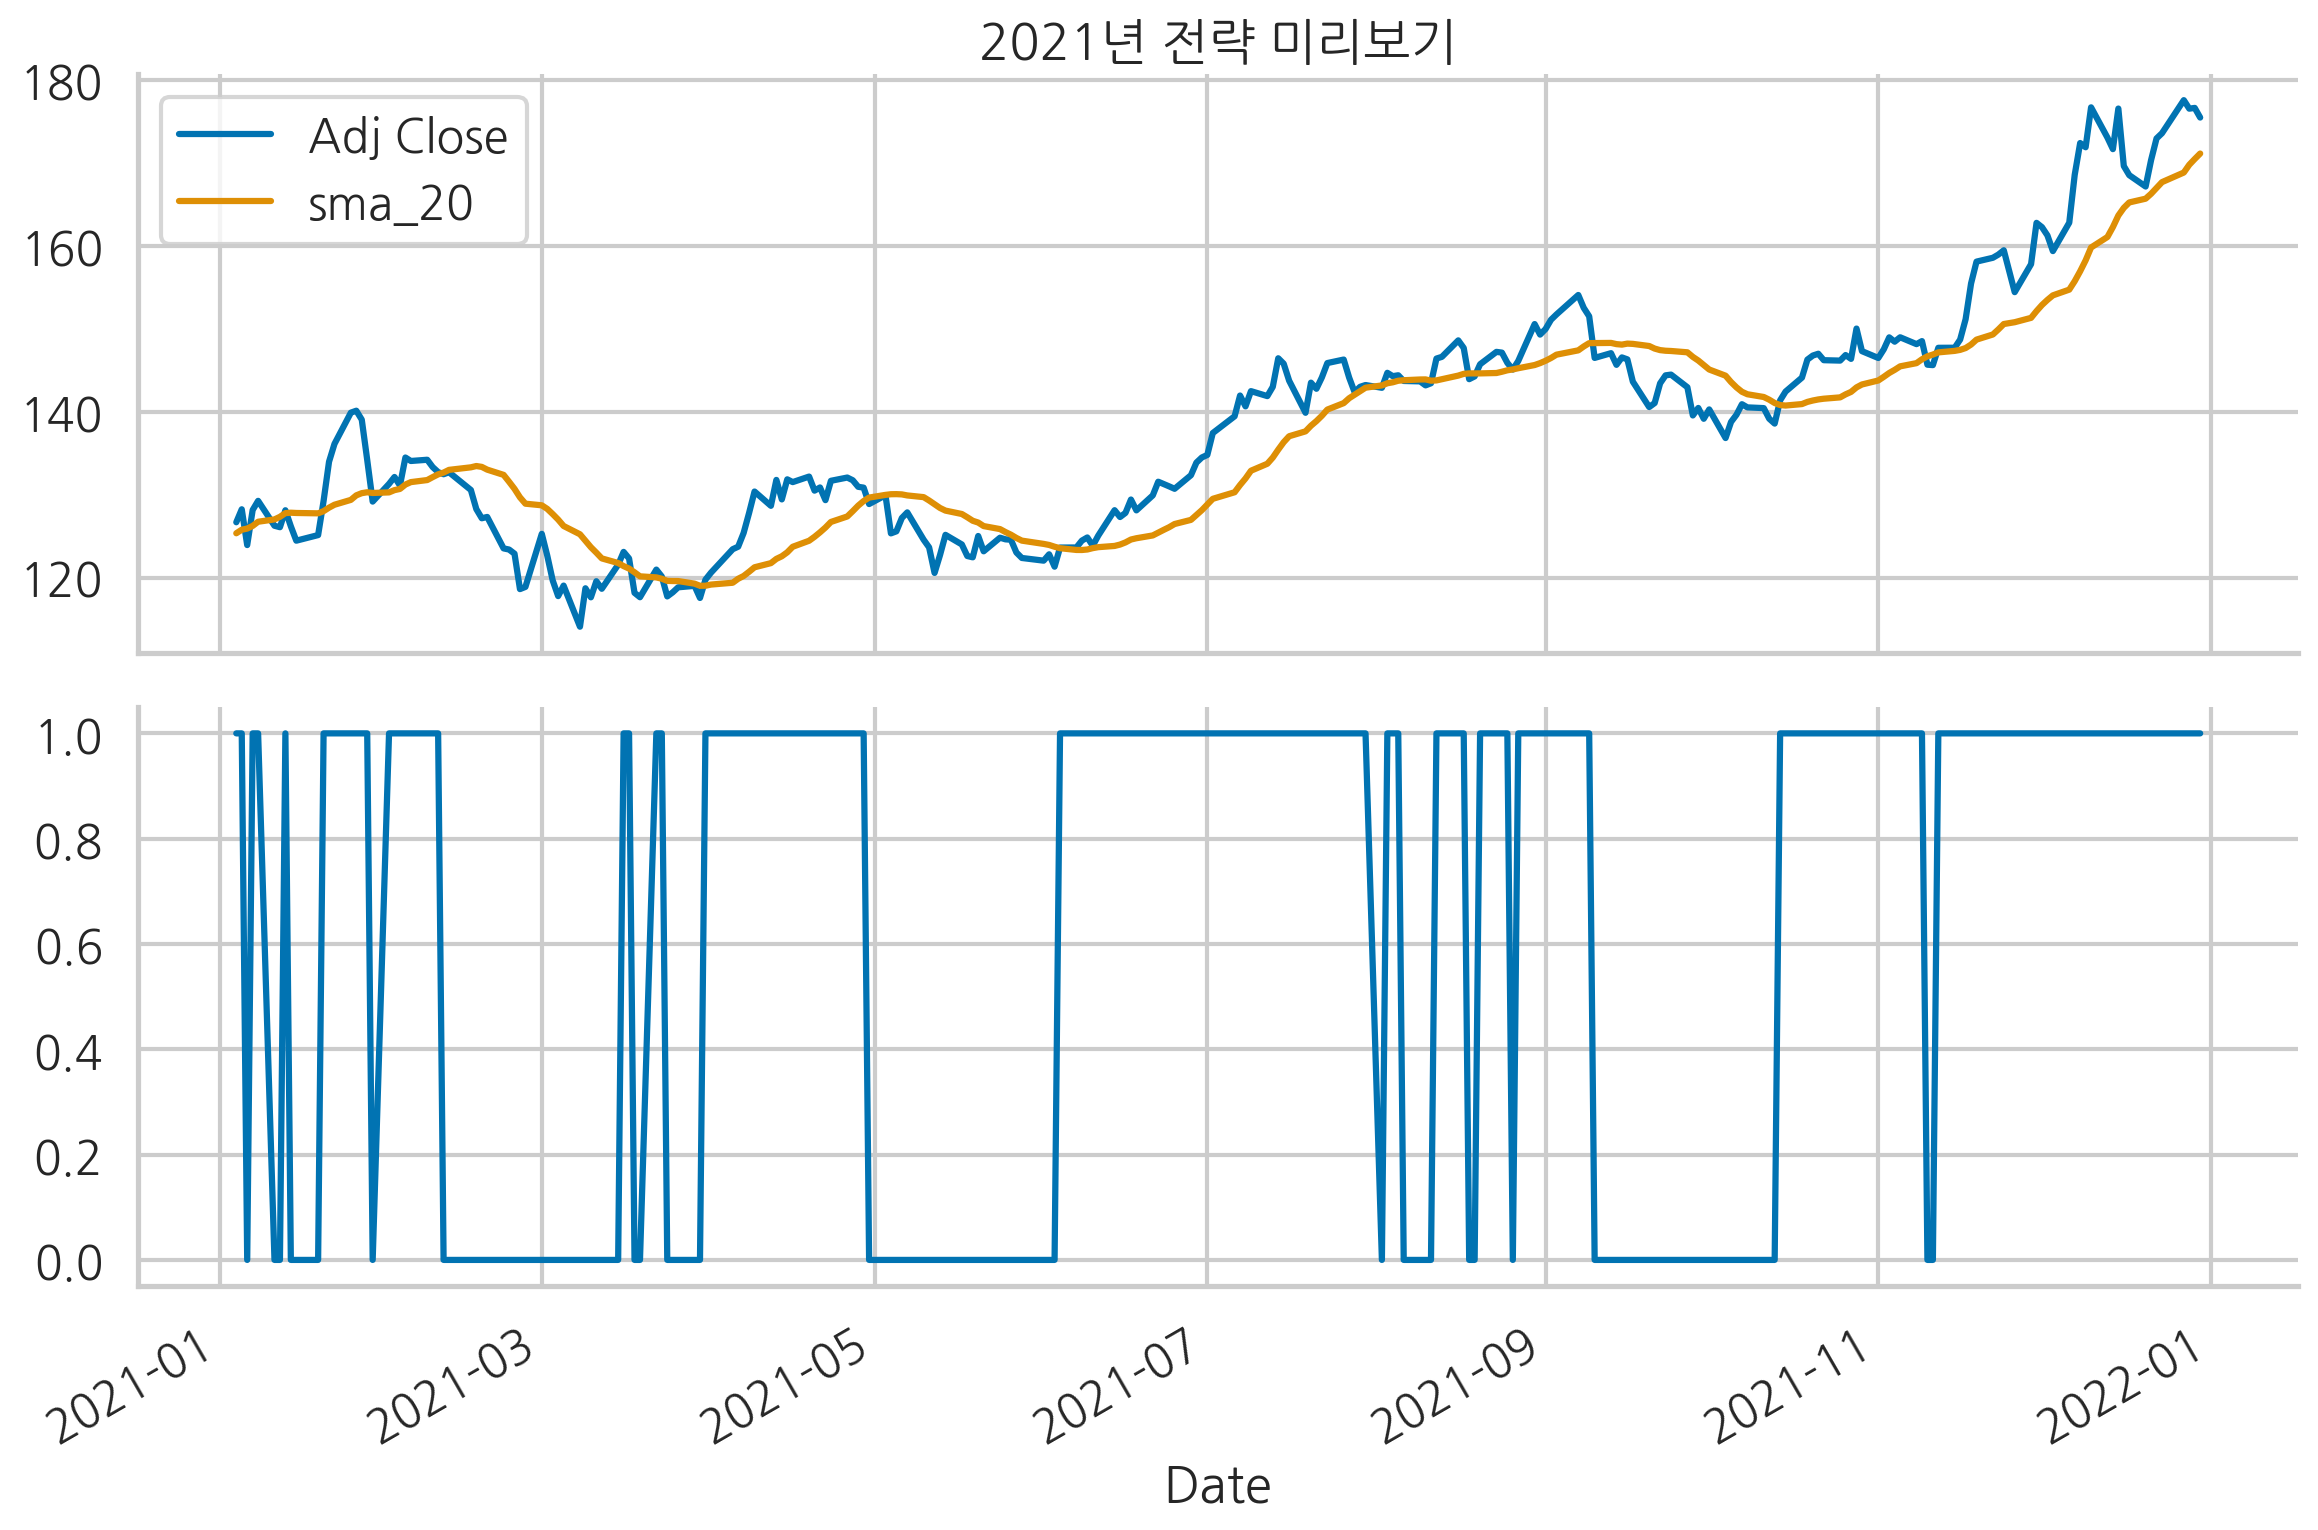

In [10]:
# 2개의 서브플롯을 생성 (상하로 배치)
# - sharex=True: x축을 공유하도록 설정
fig, ax = plt.subplots(2, sharex=True)

# 첫 번째 서브플롯: 2021년의 종가와 20일 이동평균선
# - df.loc["2021", ...]: 2021년 데이터만 선택
# - ["Adj Close", "sma_20"]: 종가와 20일 이동평균선 데이터 선택
df.loc["2021", ["Adj Close", "sma_20"]].plot(ax=ax[0])

# 두 번째 서브플롯: 2021년의 포지션 지표
# - position: 1(롱 포지션) 또는 0(포지션 없음)
df.loc["2021", "position"].plot(ax=ax[1])

# 첫 번째 서브플롯의 제목 설정
ax[0].set_title("2021년 전략 미리보기")

# 그래프 테두리 제거 (위쪽과 오른쪽)
sns.despine()

# 서브플롯 간격 자동 조정
plt.tight_layout()

# 그래프 저장 (주석 처리됨)
# plt.savefig("images/figure_12_1", dpi=200)

Figure 12.1: The preview of our trading strategy based on the simple moving average 

그림 12.1에서 우리의 전략이 어떻게 작동하는지 명확하게 볼 수 있습니다 - 종가가 20일 이동평균선보다 높은 기간에는 포지션을 보유하고 있습니다. 이는 포지션 정보가 담긴 열에서 1이라는 값으로 표시됩니다.

6. Calculate the strategy's daily and cumulative returns:

**6단계는** 벡터화된 백테스트에서 가장 중요한 단계입니다. 여기에서 전략의 일일 및 누적 수익률을 계산합니다. 일일 수익률을 계산하기 위해 해당 일의 로그 수익률에 이동된 포지션 플래그를 곱합니다. 포지션 벡터는 미래 데이터를 미리 보는 것을 방지하기 위해 1만큼 이동합니다. 다시 말해, 플래그는 t 시점까지의 모든 정보를 사용하여 다음 거래일, 즉 t+1 시점에 포지션을 열도록 생성됩니다.

`shift(1)` 함수는 데이터의 각 값을 한 행 아래로 이동시킵니다. 즉, 현재 시점의 데이터를 하루 전 시점의 데이터로 대체하는 것입니다. 

이 코드에서는 `df["position"].shift(1)`을 사용하여 현재 시점의 포지션 정보를 하루 전 시점의 포지션 정보로 이동시킵니다. 이렇게 함으로써, 현재 시점에서의 포지션 결정이 미래의 정보를 사용하지 않도록 보장합니다. 

예를 들어, `df["position"]`이 다음과 같다고 가정해봅시다:

| Date       | Position |
|------------|----------|
| 2021-01-01 | 1        |
| 2021-01-02 | 0        |
| 2021-01-03 | 1        |

`df["position"].shift(1)`을 적용하면 다음과 같이 됩니다:

| Date       | Position (shifted) |
|------------|--------------------|
| 2021-01-01 | NaN                |
| 2021-01-02 | 1                  |
| 2021-01-03 | 0                  |

이렇게 하면, 2021-01-02의 포지션은 2021-01-01의 포지션을 사용하게 되고, 2021-01-03의 포지션은 2021-01-02의 포지션을 사용하게 됩니다. 따라서, 전략 수익률을 계산할 때 미래의 정보를 사용하지 않게 됩니다.

호기심 많은 독자는 백테스트에서 발생하는 또 다른 편향을 알아차릴 수 있습니다. 정확하게 다음 거래일에만 매수할 수 있다고 가정하지만, 로그 수익률은 t 시점의 종가를 사용하여 t+1 시점에 매수했다고 계산됩니다. 이는 시장 상황에 따라 크게 달라질 수 있습니다. 이 문제를 다음 레시피에서 이벤트 기반 백테스팅을 사용하여 해결하는 방법을 살펴봅니다.

그 후, `cumsum` 메서드를 사용하여 로그 수익률의 누적 합을 계산하여 누적 수익률에 대응합니다. 마지막으로 `apply` 메서드를 사용하여 지수 함수도 적용합니다.

In [11]:
# 전략의 일일 수익률 계산
# - position을 1일 이동(shift)하여 미래 정보 사용 방지
# - 이동된 position과 log_rtn을 곱하여 전략 수익률 계산
df["strategy_rtn"] = df["position"].shift(1) * df["log_rtn"]

# 전략의 누적 수익률 계산
# - cumsum(): 일일 수익률의 누적 합 계산
# - apply(np.exp): 로그 수익률을 일반 수익률로 변환
df["strategy_rtn_cum"] = df["strategy_rtn"].cumsum().apply(np.exp)

# 계산된 결과가 포함된 데이터프레임 출력
df

,Adj Close,log_rtn,sma_20,position,strategy_rtn,strategy_rtn_cum
Date,,,,,,
2016-01-04,23.886839,NaN,NaN,0,NaN,NaN
2016-01-05,23.288252,-0.025379,NaN,0,-0.000000,1.000000
2016-01-06,22.832506,-0.019764,NaN,0,-0.000000,1.000000
2016-01-07,21.868864,-0.043121,NaN,0,-0.000000,1.000000
2016-01-08,21.984505,0.005274,NaN,0,0.000000,1.000000
...,...,...,...,...,...,...
2021-12-23,173.629745,0.003637,167.726859,1,0.003637,7.976109
2021-12-27,177.618866,0.022715,168.885178,1,0.022715,8.159359
2021-12-28,176.594513,-0.005784,169.823358,1,-0.005784,8.112303


7. Add the buy-and-hold strategy for comparison:

**7단계에서는** 매수 후 보유 전략의 누적 수익률을 계산합니다. 여기에서는 포지션 플래그와 곱하는 단계를 생략하고, 로그 수익률만 사용하여 계산합니다.

In [12]:
# 매수 후 보유(Buy and Hold) 전략의 누적 수익률 계산
# - log_rtn: 로그 수익률
# - cumsum(): 로그 수익률의 누적 합 계산
# - apply(np.exp): 로그 수익률을 일반 수익률로 변환
df["bh_rtn_cum"] = df["log_rtn"].cumsum().apply(np.exp)

8. Plot the strategies' cumulative returns:

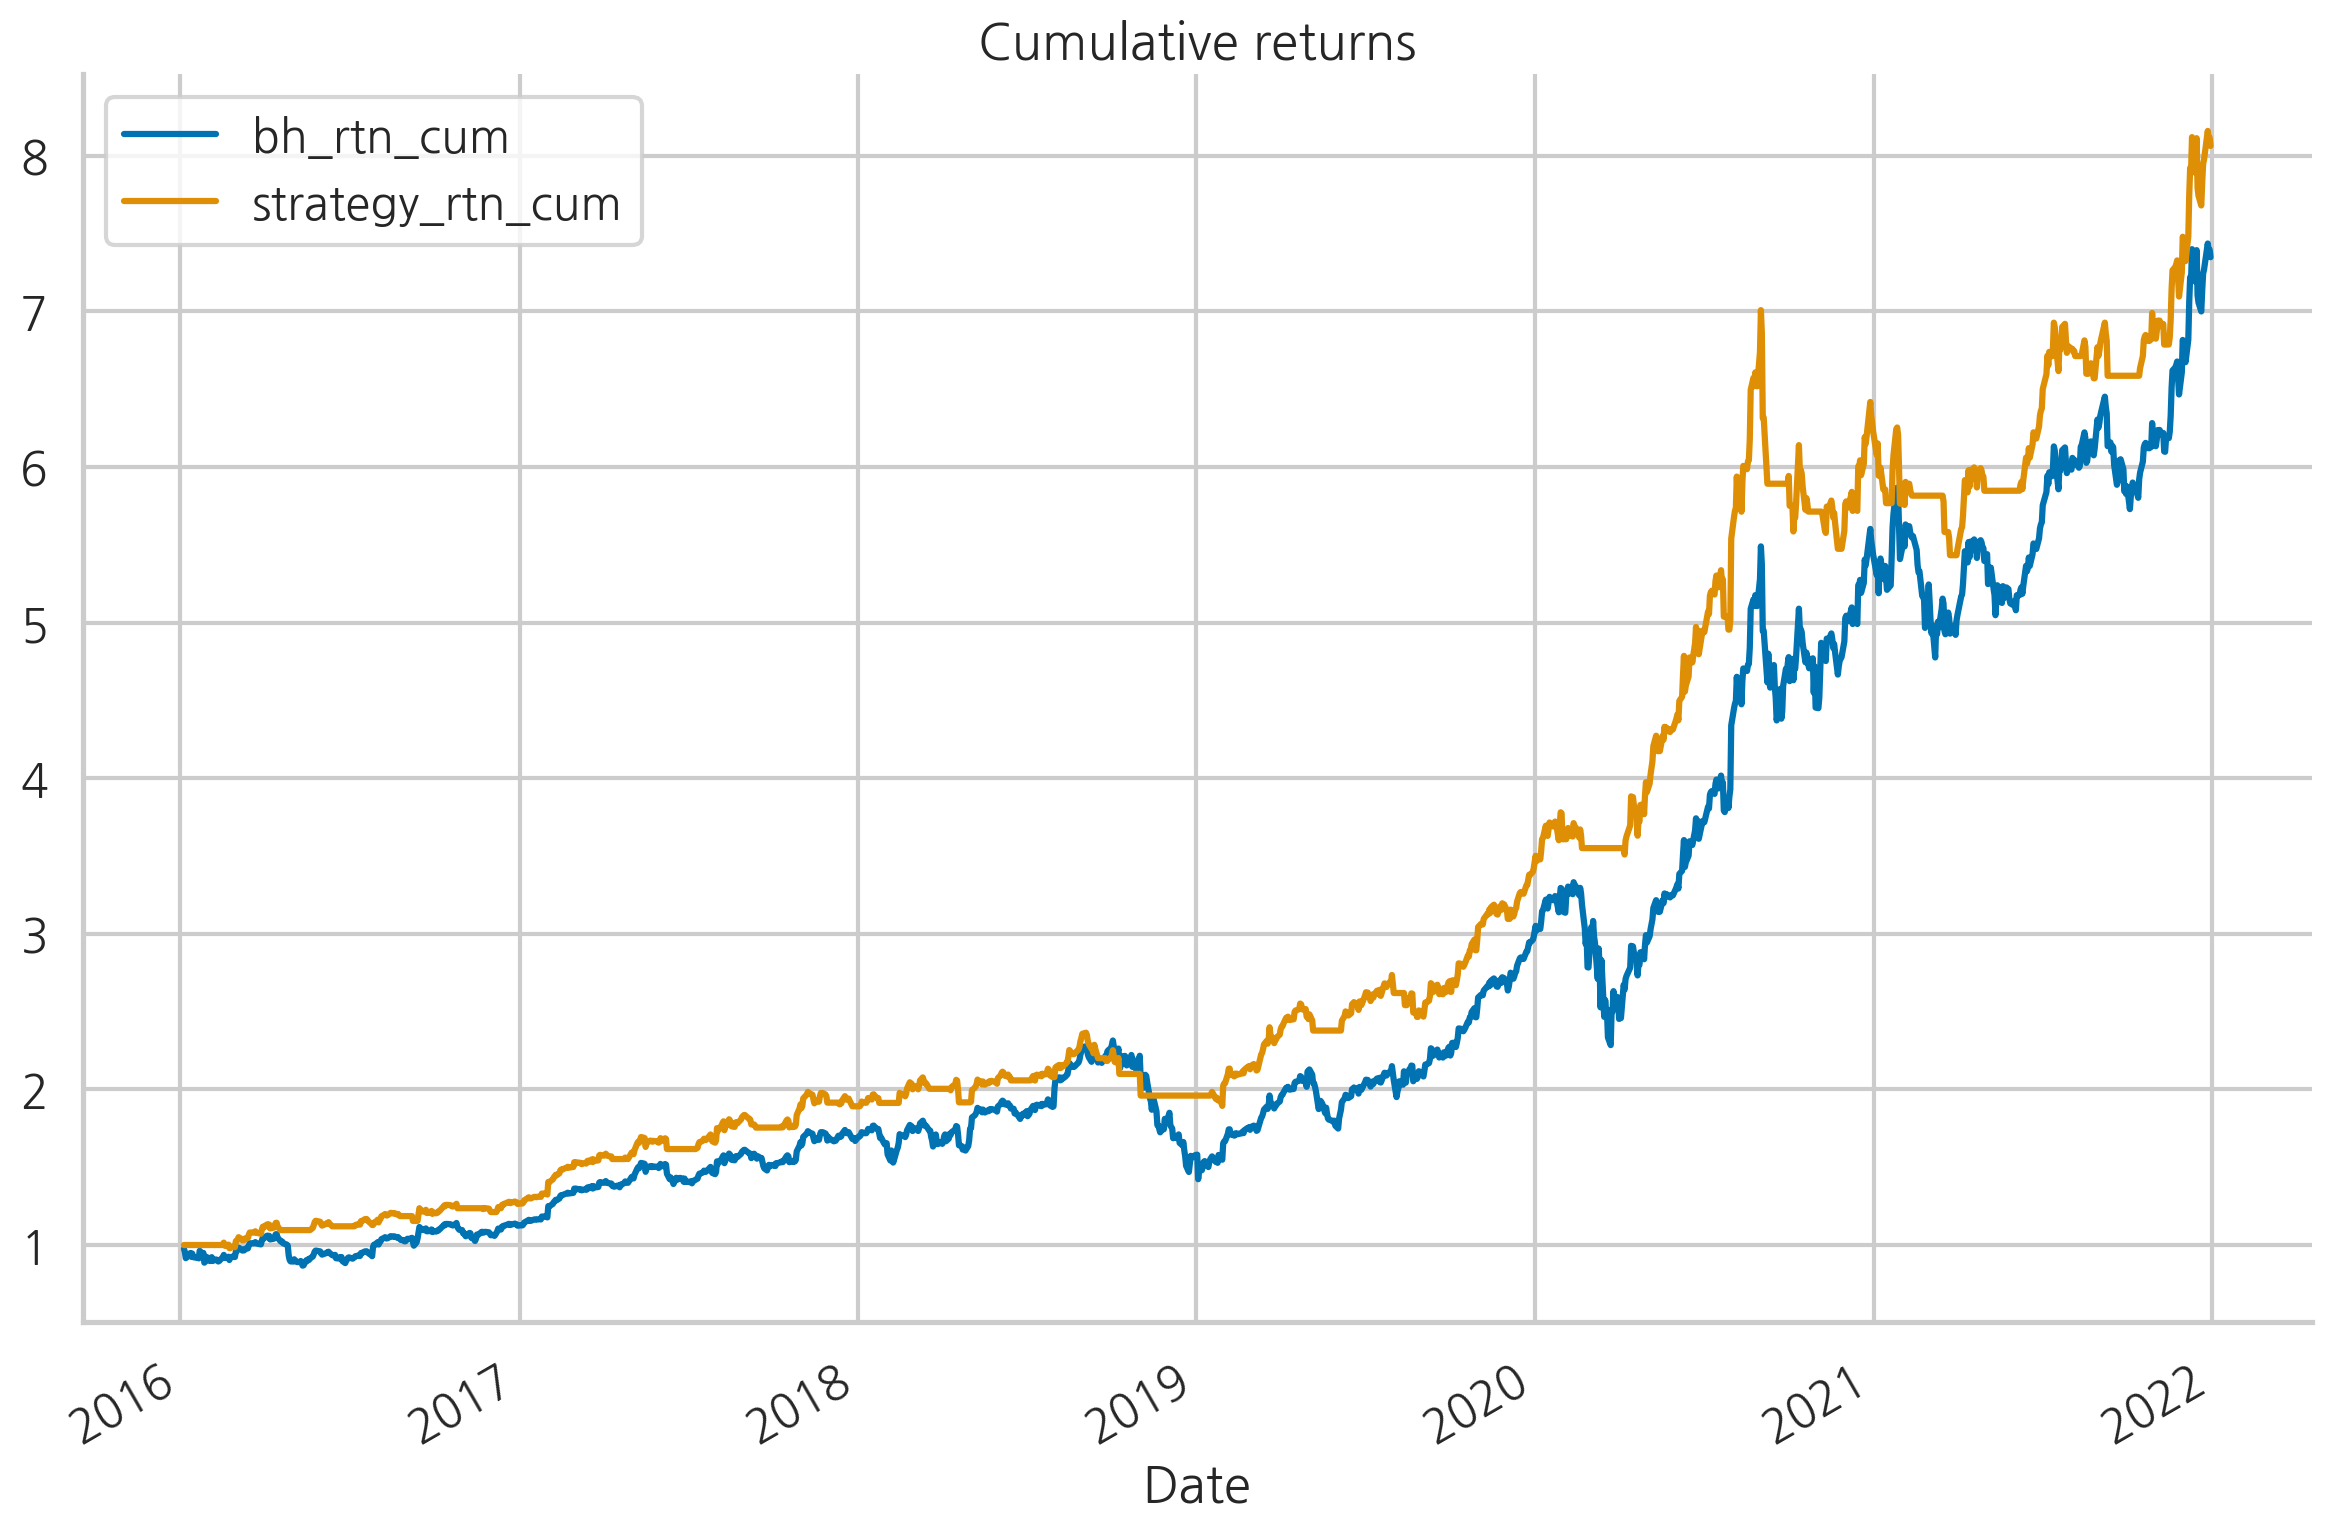

In [13]:
# 매수 후 보유 전략과 우리의 전략의 누적 수익률을 그래프로 표시
# - bh_rtn_cum: 매수 후 보유 전략의 누적 수익률 
# - strategy_rtn_cum: 우리 전략의 누적 수익률
df[["bh_rtn_cum", "strategy_rtn_cum"]].plot(title="Cumulative returns")

# 그래프의 오른쪽과 위쪽 테두리 제거하여 깔끔한 시각화
sns.despine()

# 그래프의 레이아웃 자동 조정
plt.tight_layout()

# 그래프 저장 코드 (현재는 주석 처리됨)
# plt.savefig("images/figure_12_2", dpi=200)

Figure 12.2: The cumulative returns of our strategy and the buy-and-hold benchmark 

그림 12.2에서 두 전략의 누적 수익률을 볼 수 있습니다. 초기 결론으로는 단순 전략이 고려된 기간 동안 매수 후 보유 전략보다 더 나은 성과를 보였다고 할 수 있습니다. 하지만 이러한 단순화된 백테스트는 최종 결과를 크게 바꿀 수 있는 많은 중요한 측면들(예: 종가를 이용한 거래, 슬리피지와 거래 비용이 없다고 가정하는 등)을 고려하지 않았습니다. 'There's more...' 섹션에서 거래 비용만 고려했을 때도 결과가 얼마나 빠르게 변하는지 살펴보겠습니다.

### There's more

초기 백테스트 결과, 단순 전략이 매수 후 보유 전략보다 우수한 성과를 내는 것으로 보입니다. 하지만 6년 동안 56번의 롱 포지션을 잡았습니다. 거래 횟수와 포지션 종료 횟수를 포함하면, 브로커에 따라 상당한 거래 비용이 발생할 수 있습니다.

거래 비용이 고정된 비율로 자주 인용되기 때문에, 각 시점 사이에서 포트폴리오가 얼마나 변했는지를 계산하여 이 비율을 기준으로 거래 비용을 계산하고 이를 전략 수익에서 직접 차감할 수 있습니다.

다음 단계에서는 벡터화된 백테스트에서 거래 비용을 고려하는 방법을 보여줍니다. 간단히 하기 위해 거래 비용을 1%로 가정합니다.

벡터화된 백테스트에서 거래 비용을 고려하는 명령은 다음과 같습니다:


1. Calculate daily transaction costs:

In [14]:
# 거래 비용 비율 설정 (1% = 0.01)
TRANSACTION_COST = 0.01

# 일별 거래 비용 계산
# 1. position.diff(1): 전일 대비 포지션 변화량 계산
# 2. .abs(): 포지션 변화량의 절대값 계산 (매수/매도 모두 비용 발생)
# 3. * TRANSACTION_COST: 변화량에 거래 비용 비율을 곱하여 실제 비용 계산
df["tc"] = df["position"].diff(1).abs() * TRANSACTION_COST

2. Calculate the strategy's performance accounting for transaction costs:

In [15]:
# 거래 비용을 고려한 전략의 누적 수익률 계산
# 1. df["strategy_rtn"] - df["tc"]: 일별 수익률에서 거래 비용을 차감
# 2. .cumsum(): 차감된 수익률을 누적 합산
# 3. .apply(np.exp): 로그 수익률을 단순 수익률로 변환
df["strategy_rtn_cum_tc"] = (
    (df["strategy_rtn"] - df["tc"]).cumsum().apply(np.exp)
)

3. Plot the cumulative returns of all the strategies:

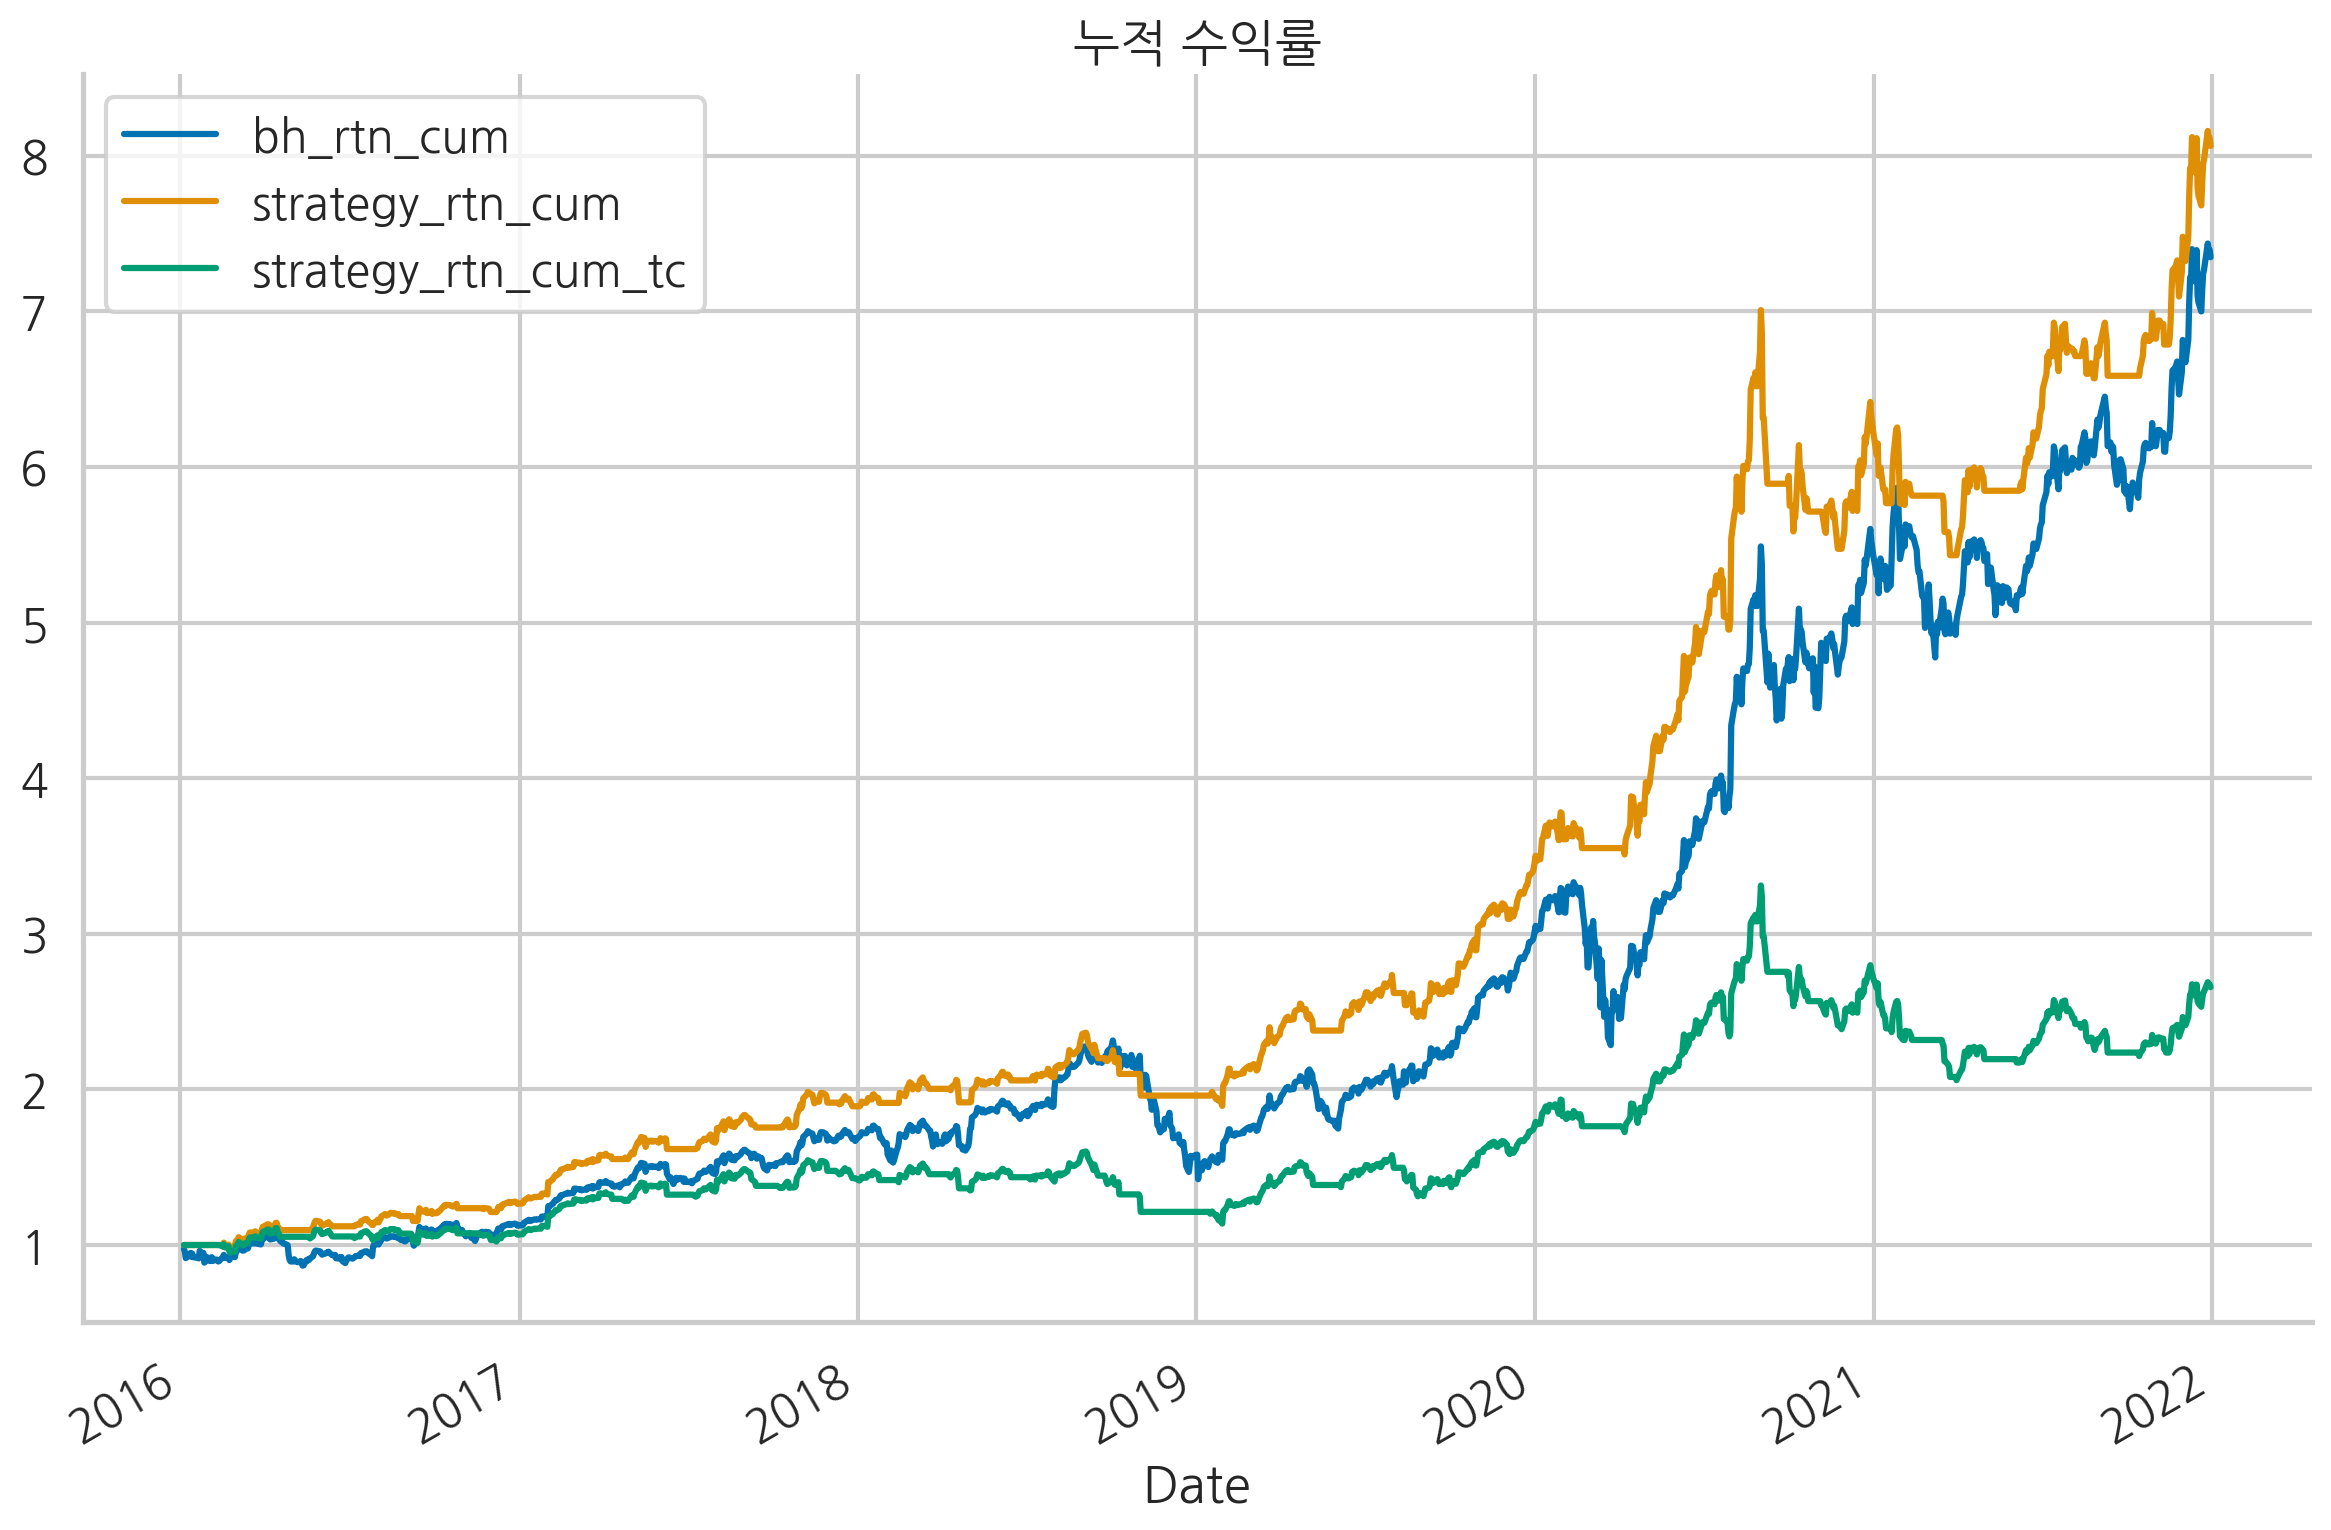

In [16]:
# 세 가지 전략의 누적 수익률을 시각화
# - bh_rtn_cum: 매수 후 보유 전략의 누적 수익률
# - strategy_rtn_cum: 기본 전략의 누적 수익률 
# - strategy_rtn_cum_tc: 거래 비용을 고려한 전략의 누적 수익률
(
    df
    .loc[:, ["bh_rtn_cum", "strategy_rtn_cum", "strategy_rtn_cum_tc"]]
    .plot(title="누적 수익률")  # 누적 수익률 그래프 생성
)

# 그래프 테두리 제거하여 깔끔한 시각화
sns.despine()

# 그래프 레이아웃 자동 조정
plt.tight_layout()

# 그래프 저장 (현재는 주석 처리)
# plt.savefig("images/figure_12_3", dpi=200)

Figure 12.3: Cumulative returns of all strategies, including the one with transaction costs 
 
거래 비용을 고려하면 성과가 크게 감소하여 매수 후 보유 전략보다 더 나쁜 결과를 보였습니다. 그리고 완전히 공정한 비교를 위해서는 매수 후 보유 전략에서도 자산을 한 번 매수하고 매도할 때 발생하는 초기 및 최종 거래 비용을 고려해야 합니다.

## 12.2 Event-driven backtesting with `backtrader`


**백트레이더(backtrader)를 활용한 이벤트 기반 백테스팅**

백테스팅의 두 번째 접근 방식은 **이벤트 기반 백테스팅**이라 불립니다. 이 접근 방식에서 백테스팅 엔진은 거래 환경의 시간 차원을 시뮬레이션합니다(이를 루프를 통해 시간 순서대로 모든 작업을 순차적으로 실행하는 것으로 생각할 수 있습니다). 이는 백테스트에 더 많은 구조를 부여하여 거래가 실제로 실행될 수 있는 시점, 가격이 제공되는 시점 등을 정의하는 데 역사적 캘린더의 사용을 포함합니다.

이벤트 기반 백테스팅은 특정 전략을 실행할 때 발생할 수 있는 모든 행동과 제약을 시뮬레이션하는 것을 목표로 하며, 벡터화된 접근 방식보다 훨씬 더 많은 유연성을 제공합니다. 예를 들어, 이 접근 방식은 주문 실행의 잠재적 지연, 슬리피지 비용 등을 시뮬레이션할 수 있게 합니다. 이상적인 시나리오에서는 이벤트 기반 백테스트에 인코딩된 전략이 실제 거래 엔진에서 작동하는 형태로 쉽게 변환될 수 있습니다.

오늘날 파이썬에서는 여러 이벤트 기반 백테스팅 라이브러리가 사용 가능합니다. 이 장에서는 가장 인기 있는 라이브러리 중 하나인 **백트레이더(backtrader)** 를 소개합니다. 이 프레임워크의 주요 기능은 다음과 같습니다:

- 다양한 기술 지표 제공(백트레이더는 또한 인기 있는 TA-Lib 라이브러리를 감싸는 래퍼도 제공합니다) 및 성능 측정 기능.
- 새로운 지표를 쉽게 구축하고 적용할 수 있는 기능.
- 다양한 데이터 소스 사용 가능(예: Yahoo Finance 및 Nasdaq Data Link), 외부 파일을 로드할 수 있는 기능 포함.
- 시장가, 지정가, 스톱 주문 등 다양한 종류의 주문, 슬리피지, 수수료, 롱/숏 거래 등 실제 브로커의 여러 측면을 시뮬레이션할 수 있는 기능.
- 가격, 기술 지표, 거래 신호, 성과 등을 포괄적이고 상호작용적으로 시각화하는 기능.
- 선택된 브로커와의 실시간 거래 기능.

이 예시에서는 단순 이동 평균에 기반한 기본 전략을 고려합니다. 사실, 이는 이전 벡터화된 접근 방식을 사용한 백테스트와 거의 동일합니다. 이 전략의 논리는 다음과 같습니다:

- 종가가 20일 단순 이동 평균(SMA)보다 높아질 때, 주식 한 주를 매수합니다.
- 종가가 20일 SMA보다 낮아지고 보유한 주식이 있을 때, 주식을 매도합니다.
- 언제든지 최대 한 주만 보유할 수 있습니다.
- 공매도는 허용되지 않습니다.

이 전략을 2021년의 애플 주식 가격 데이터를 사용하여 백테스팅합니다.

### How to do it...

백트레이더(backtrader)를 사용할 때 핵심 아이디어는 백테스트의 주요 두뇌인 Cerebro를 사용하여 다양한 방법으로 구성하는 것입니다. 이를 위해 우리는 역사적 데이터, 설계된 거래 전략 및 추가 지표를 제공하여 다양한 계산을 수행하게 합니다(예: 포트폴리오 가치나 투자 수익률, 혹은 전반적인 샤프 비율 등을 계산). 수수료, 슬리피지 등에 대한 정보도 포함됩니다.

전략을 만들기 위한 두 가지 방법이 있습니다: 신호(bt.Signal)를 생성하거나 전체 전략(bt.Strategy)을 정의하는 것입니다. 두 방법 모두 동일한 결과를 생성하지만, bt.Strategy를 사용하는 긴 접근 방식은 백그라운드에서 실제로 일어나는 작업의 더 많은 로깅을 제공합니다. 이는 모든 작업의 세부 사항을 쉽게 디버깅하고 추적할 수 있게 하며, 필요에 따라 로깅 깊이를 조절할 수 있습니다. 따라서 이 레시피에서는 이 접근 방식을 사용하여 설명을 시작합니다.

1. Import the libraries:

In [21]:
from datetime import datetime
import backtrader as bt
from backtrader_strategies.strategy_utils import *

2. Download data from Yahoo Finance:

1단계에서 라이브러리와 헬퍼 함수를 가져온 후, Yahoo Finance에서 bt.feeds.YahooFinanceData 함수를 사용하여 가격 데이터를 다운로드합니다.
또한 CSV 파일, pandas DataFrame, Nasdaq Data Link 및 기타 소스에서 데이터를 추가할 수 있습니다. 사용 가능한 옵션 목록은 bt.feeds의 문서를 참조하세요. 

In [22]:
# data = bt.feeds.YahooFinanceData(dataname="AAPL", 
#                                  fromdate=datetime(2021, 1, 1),
#                                  todate=datetime(2021, 12, 31))

# yfinance 라이브러리를 가져와서 야후 파이낸스에서 데이터를 다운로드하기 위해 사용합니다
import yfinance as yf

# AAPL(애플) 주식의 2021년 1월 1일부터 12월 31일까지의 데이터를 다운로드합니다
data = yf.download("AAPL", start="2021-01-01", end="2021-12-31")

# 다운로드한 데이터를 CSV 파일로 저장합니다
# 이후 백트레이더에서 사용하기 위해 로컬에 저장해둡니다
data.to_csv("aapl_data.csv")

[*********************100%***********************]  1 of 1 completed


3. Define the strategy:

3단계에서는 bt.Strategy에서 상속받아 클래스로 거래 전략을 정의합니다. 클래스 내부에서는 다음과 같은 메서드를 정의하여 요구 사항에 맞게 조정합니다(실제로 메서드를 재정의합니다):

- **__init__**: 
    - 이 메서드에서는 추적하고자 하는 객체를 정의합니다. 
    - 예제에서는 종가, 주문을 위한 자리 표시자, TA 지표(SMA)를 포함합니다.
- **log**: 
    - 이 메서드는 로깅 목적의 데이터를 기록합니다. 
    - 날짜와 제공된 문자열을 기록하며, get_action_log_string 및 get_result_log_string 헬퍼 함수를 사용하여 다양한 주문 관련 정보를 포함한 문자열을 생성합니다.
- **notify_order**: 
    - 이 메서드는 주문(포지션)의 상태를 보고합니다. 
    - 일반적으로 t일에 지표가 종가를 기준으로 매수/매도를 시작할 수 있는지 확인하며, 다음 거래일(t+1일의 개장 시간 사용)에 (시장) 주문이 실행될 수 있습니다. 
    - 그러나 주문이 실행된다는 보장은 없으며, 취소되거나 현금이 부족할 수 있습니다. 
    - 또한 이 메서드는 sell order = None을 설정하여 보류 중인 주문을 제거합니다.
- **notify_trade**: 
    - 포지션이 닫힌 후 결과 상태를 보고합니다.
- **next**: 
    - 이 메서드는 거래 전략의 로직을 제어합니다. 
    - 첫째, 이미 대기 중인 주문이 있는지 확인하고, 없으면 아무것도 하지 않습니다. 
    - 두 번째로는 거래에 포지션이 있는지 확인하고, 포지션이 없으면 종가가 이동 평균보다 높은지 여부를 확인합니다. 
    - 양수 값이 로그에 입력되고 buy order = self.buy()를 통해 매수 주문을 배치합니다. 
    - 이 지점에서 매수할 주식 수를 선택할 수 있습니다(기본값은 1입니다, self.buy(size=1)을 사용).
- **start/stop**: 
    - 이 메서드는 백테스트의 시작 및 종료 시 실행되며, 포트폴리오 가치를 보고하는 데 사용될 수 있습니다.

In [23]:
class SmaStrategy(bt.Strategy):
    # 전략의 파라미터를 정의합니다
    # ma_period: 이동평균을 계산할 기간을 설정합니다 (기본값: 20일)
    params = (("ma_period", 20), )

    def __init__(self):
        # 종가 데이터에 쉽게 접근하기 위한 변수를 생성합니다
        # self.datas[0]는 첫 번째(그리고 이 경우 유일한) 데이터 피드를 의미합니다
        self.data_close = self.datas[0].close

        # 현재 진행 중인 주문을 추적하기 위한 변수입니다
        # None이면 활성화된 주문이 없음을 의미합니다
        self.order = None

        # 단순이동평균(Simple Moving Average) 지표를 생성합니다
        # 파라미터로 설정된 기간(ma_period)을 사용합니다
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        # 로그 메시지를 현재 날짜와 함께 출력하는 유틸리티 함수입니다
        # datetime.date(0)는 현재 거래일의 날짜를 반환합니다
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        # 주문 상태가 변경될 때마다 호출되는 콜백 함수입니다
        
        # 주문이 제출되었거나 수락된 상태면 아직 처리 중이므로 기다립니다
        if order.status in [order.Submitted, order.Accepted]:
            return

        # 주문이 완료된 경우 상세 정보를 로깅합니다
        if order.status in [order.Completed]:
            # 매수인지 매도인지 확인합니다
            direction = "b" if order.isbuy() else "s"
            # 주문 실행 상세 정보(가격, 수량, 비용, 수수료)를 로그에 기록합니다
            log_str = get_action_log_string(
                dir=direction, 
                action="e", 
                price=order.executed.price,
                size=order.executed.size,
                cost=order.executed.value, 
                commission=order.executed.comm
            )
            self.log(log_str)

        # 주문이 실패한 경우(취소, 증거금 부족, 거부됨) 로그를 남깁니다
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log("Order Failed")

        # 주문 처리가 완료되었으므로 order 변수를 초기화합니다
        self.order = None

    def notify_trade(self, trade):
        # 거래가 종료될 때 호출되는 콜백 함수입니다
        
        # 거래가 아직 진행 중이면 아무 작업도 하지 않습니다
        if not trade.isclosed:
            return

        # 거래가 종료되면 총 수익과 순수익(수수료 차감 후)을 로그에 기록합니다
        self.log(
            get_result_log_string(gross=trade.pnl, net=trade.pnlcomm)
        )

    def next(self):
        # 매 거래일마다 호출되는 핵심 전략 로직입니다
        
        # 이미 주문이 진행 중이면 추가 주문을 하지 않습니다
        if self.order:
            return

        # 현재 보유 중인 포지션이 없는 경우
        if not self.position:
            # 매수 신호: 현재 종가가 이동평균선 위에 있을 때
            if self.data_close[0] > self.sma[0]:
                # 매수 의사를 로그에 기록하고 주문을 실행합니다
                self.log(
                    get_action_log_string("b", "c", self.data_close[0], 1)
                )
                self.order = self.buy()
        else:
            # 매도 신호: 현재 종가가 이동평균선 아래로 떨어질 때
            if self.data_close[0] < self.sma[0]:      
                # 매도 의사를 로그에 기록하고 주문을 실행합니다
                self.log(
                    get_action_log_string("s", "c", self.data_close[0], 1)
                )      
                self.order = self.sell()

    def start(self):
        # 백테스트 시작 시 호출되는 함수입니다
        # 초기 포트폴리오 가치를 기록합니다
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        # 백테스트 종료 시 호출되는 함수입니다
        # 최종 포트폴리오 가치를 기록합니다
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")

4. Set up the backtest:

4단계에서는 백테스트를 설정하여 Cerebro와 연결된 일련의 작업을 실행합니다:

- bt.Cerebro 인스턴스를 생성하고 **stdstats=False**로 설정하여 기본 요소의 출력을 억제합니다. 대신, 선택한 요소들(관찰자 및 지표)만 수동으로 추가합니다.
- adddata 메서드를 사용하여 데이터를 추가합니다.
- broker의 setcash 메서드를 사용하여 사용 가능한 자금의 양을 설정합니다.
- addstrategy 메서드를 사용하여 전략을 추가합니다.
- addobserver 메서드를 사용하여 관찰자를 추가합니다. 우리는 매수/매도 결정을 추적하는 custom Buysell 관찰자와 시간에 따라 포트폴리오 가치의 변화를 추적하는 Value 관찰자를 선택합니다.

`backtrader` 라이브러리에서 `Cerebro`는 백테스트 환경을 관리하고 실행하는 중심적인 역할을 합니다. `Cerebro`는 전략, 데이터, 브로커, 관찰자 및 지표를 통합하여 백테스트를 설정하고, 이를 통해 전략의 성과를 평가할 수 있습니다. 각각의 구성 요소를 추가한 후 `run` 메서드를 통해 시뮬레이션을 실행할 수 있습니다. 주요 기능은 다음과 같습니다:

1. **데이터 관리**: `adddata` 메서드를 사용하여 테스트에 필요한 데이터를 추가할 수 있습니다. 이는 과거 데이터나 실시간 데이터가 될 수 있습니다.

2. **브로커 및 자금 설정**: `setcash` 메서드를 통해 초기 자본을 설정하고, 다양한 브로커 설정으로 자산을 거래할 수 있는 환경을 조성합니다. 

3. **전략 추가**: `addstrategy` 메서드를 통해 사용자 정의 전략을 추가하고 백테스트할 수 있습니다. 이 전략은 `Cerebro`에 의해 실행되며, 매수/매도 조건을 기반으로 거래를 수행합니다.

4. **관찰자 및 지표 추가**: `addobserver` 메서드를 통해 매수/매도 결정이나 포트폴리오 가치의 변화를 추적할 수 있는 관찰자를 추가할 수 있습니다. 예를 들어, `Buysell` 관찰자를 추가하면 매수/매도 시점이 표시되고, `Value` 관찰자는 포트폴리오 가치의 변화를 기록합니다.

In [24]:
# Pandas DataFrame을 backtrader가 이해할 수 있는 형식으로 변환합니다
data_feed = bt.feeds.PandasData(dataname=data)

# Cerebro 엔진을 초기화합니다. stdstats=False로 설정하여 기본 통계를 비활성화합니다
cerebro = bt.Cerebro(stdstats=False)

# 데이터피드를 Cerebro에 추가합니다
cerebro.adddata(data_feed)

# 초기 투자금을 1000달러로 설정합니다
cerebro.broker.setcash(1000.0)

# 우리가 만든 이동평균 전략을 추가합니다
cerebro.addstrategy(SmaStrategy)

# 매수/매도 시그널을 시각화하기 위한 커스텀 관찰자를 추가합니다
cerebro.addobserver(MyBuySell)

# 포트폴리오 가치 변화를 추적하기 위한 관찰자를 추가합니다
cerebro.addobserver(bt.observers.Value)

5. Run the backtest:

마지막 단계에서는 cerebro.run()을 통해 백테스트를 실행하고

In [25]:
cerebro.run()

Initial Portfolio Value: 1000.00
2021-02-01: BUY CREATED - Price: 134.14, Size: 1.00
2021-02-02: BUY EXECUTED - Price: 135.73, Size: 1.00, Cost: 135.73, Commission: 0.00
2021-02-11: SELL CREATED - Price: 135.13, Size: 1.00
2021-02-12: SELL EXECUTED - Price: 134.35, Size: -1.00, Cost: 135.73, Commission: 0.00
2021-02-12: OPERATION RESULT - Gross: -1.38, Net: -1.38
2021-03-16: BUY CREATED - Price: 125.57, Size: 1.00
2021-03-17: BUY EXECUTED - Price: 124.05, Size: 1.00, Cost: 124.05, Commission: 0.00
2021-03-18: SELL CREATED - Price: 120.53, Size: 1.00
2021-03-19: SELL EXECUTED - Price: 119.90, Size: -1.00, Cost: 124.05, Commission: 0.00
2021-03-19: OPERATION RESULT - Gross: -4.15, Net: -4.15
2021-03-22: BUY CREATED - Price: 123.39, Size: 1.00
2021-03-23: BUY EXECUTED - Price: 123.33, Size: 1.00, Cost: 123.33, Commission: 0.00
2021-03-24: SELL CREATED - Price: 120.09, Size: 1.00
2021-03-25: SELL EXECUTED - Price: 119.54, Size: -1.00, Cost: 123.33, Commission: 0.00
2021-03-25: OPERATION RE

6. Plot the results:

cerebro.plot()을 통해 결과를 시각화합니다. 후자의 단계에서는 그래프를 방해하지 않도록 볼륨 차트 표시를 비활성화합니다.

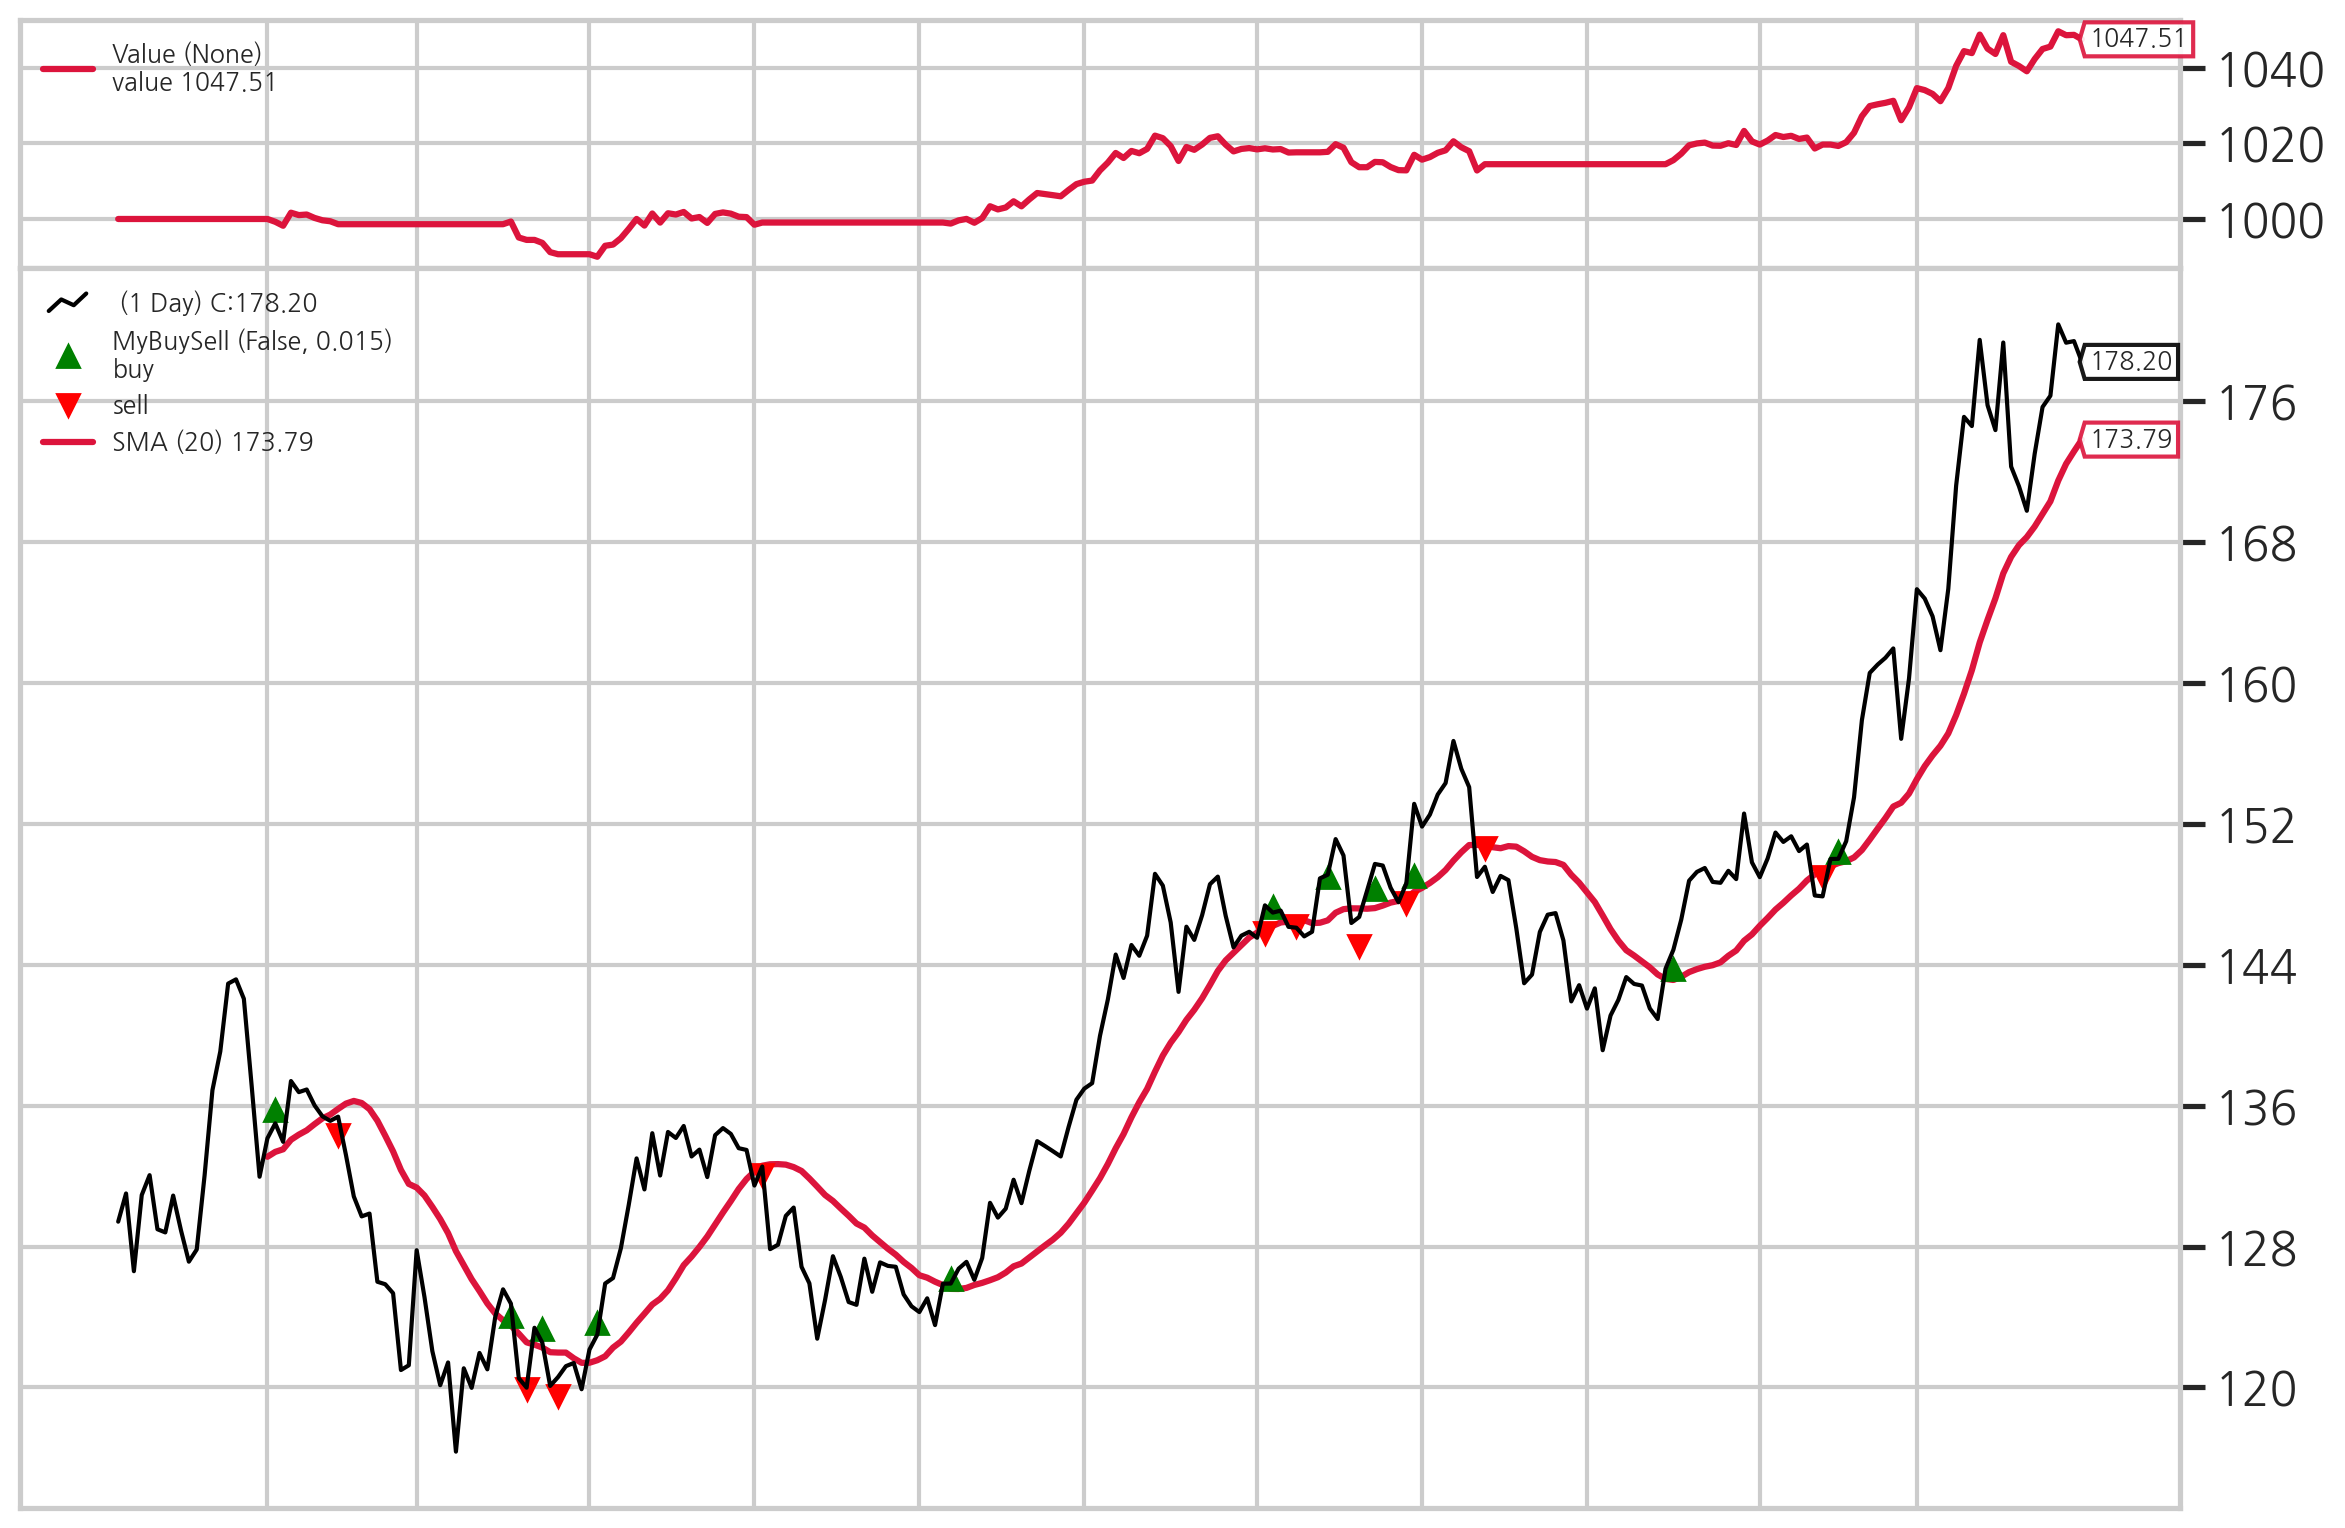

In [28]:
# cerebro.plot(iplot=True, volume=False)
cerebro.plot(iplot=False, volume=False);

Figure 12.4: Summary of our strategy’s behavior/performance over the backtested period 

그림 12.4에서 애플의 주가, 20일 이동평균선, 매수/매도 주문, 그리고 시간에 따른 포트폴리오 가치의 변화를 볼 수 있습니다. 이 전략은 백테스트 기간 동안 48달러의 수익을 냈습니다. 성과를 평가할 때는 이 전략이 대부분의 자금을 현금으로 보유한 채 단일 종목으로만 운용되었다는 점을 고려해야 합니다.

### There's more

백트레이더(backtrader)는 매개변수 최적화 기능을 제공하며, 이 기능을 활용하는 코드를 아래에 제시합니다. 코드는 이 레시피에서 사용하는 전략의 수정된 버전으로, SMA를 계산하는 데 사용되는 일 수를 최적화합니다.

> 전략의 매개변수를 조정할 때, 너무 많은 정보를 기록하지 않는 간단한 버전의 전략을 생성할 수 있습니다(시작 값, 주문 생성/실행 등). 수정된 전략의 예시는 `sma_strategy_optimization.py` 스크립트에서 확인할 수 있습니다.

아래 목록은 코드 수정 사항에 대한 세부 사항을 제공합니다(이전 코드와 동일한 부분은 생략하고 관련 부분만 표시했습니다):

- **cerebro.addstrategy** 대신 **cerebro.optstrategy**를 사용하고, 정의된 전략 객체와 매개변수 값 범위를 제공합니다:

Initial Portfolio Value: 1000.00Initial Portfolio Value: 1000.00Initial Portfolio Value: 1000.00Initial Portfolio Value: 1000.00Initial Portfolio Value: 1000.00




2021-01-25: BUY CREATED - Price: 142.92, Size: 1.002021-01-20: BUY CREATED - Price: 132.03, Size: 1.002021-02-01: BUY CREATED - Price: 134.14, Size: 1.00


2021-02-08: BUY CREATED - Price: 136.91, Size: 1.00
2021-01-26: BUY EXECUTED - Price: 143.60, Size: 1.00, Cost: 143.60, Commission: 0.002021-02-02: BUY EXECUTED - Price: 135.73, Size: 1.00, Cost: 135.73, Commission: 0.002021-01-21: BUY EXECUTED - Price: 133.80, Size: 1.00, Cost: 133.80, Commission: 0.00

2021-02-09: BUY EXECUTED - Price: 136.62, Size: 1.00, Cost: 136.62, Commission: 0.00
2021-01-29: SELL CREATED - Price: 131.96, Size: 1.002021-01-29: SELL CREATED - Price: 131.96, Size: 1.00
2021-02-11: SELL CREATED - Price: 135.13, Size: 1.00
2021-04-01: BUY CREATED - Price: 123.00, Size: 1.00

2021-02-01: SELL EXECUTED - Price: 133.75, Size: -1.00, Cost: 133.80, Commiss

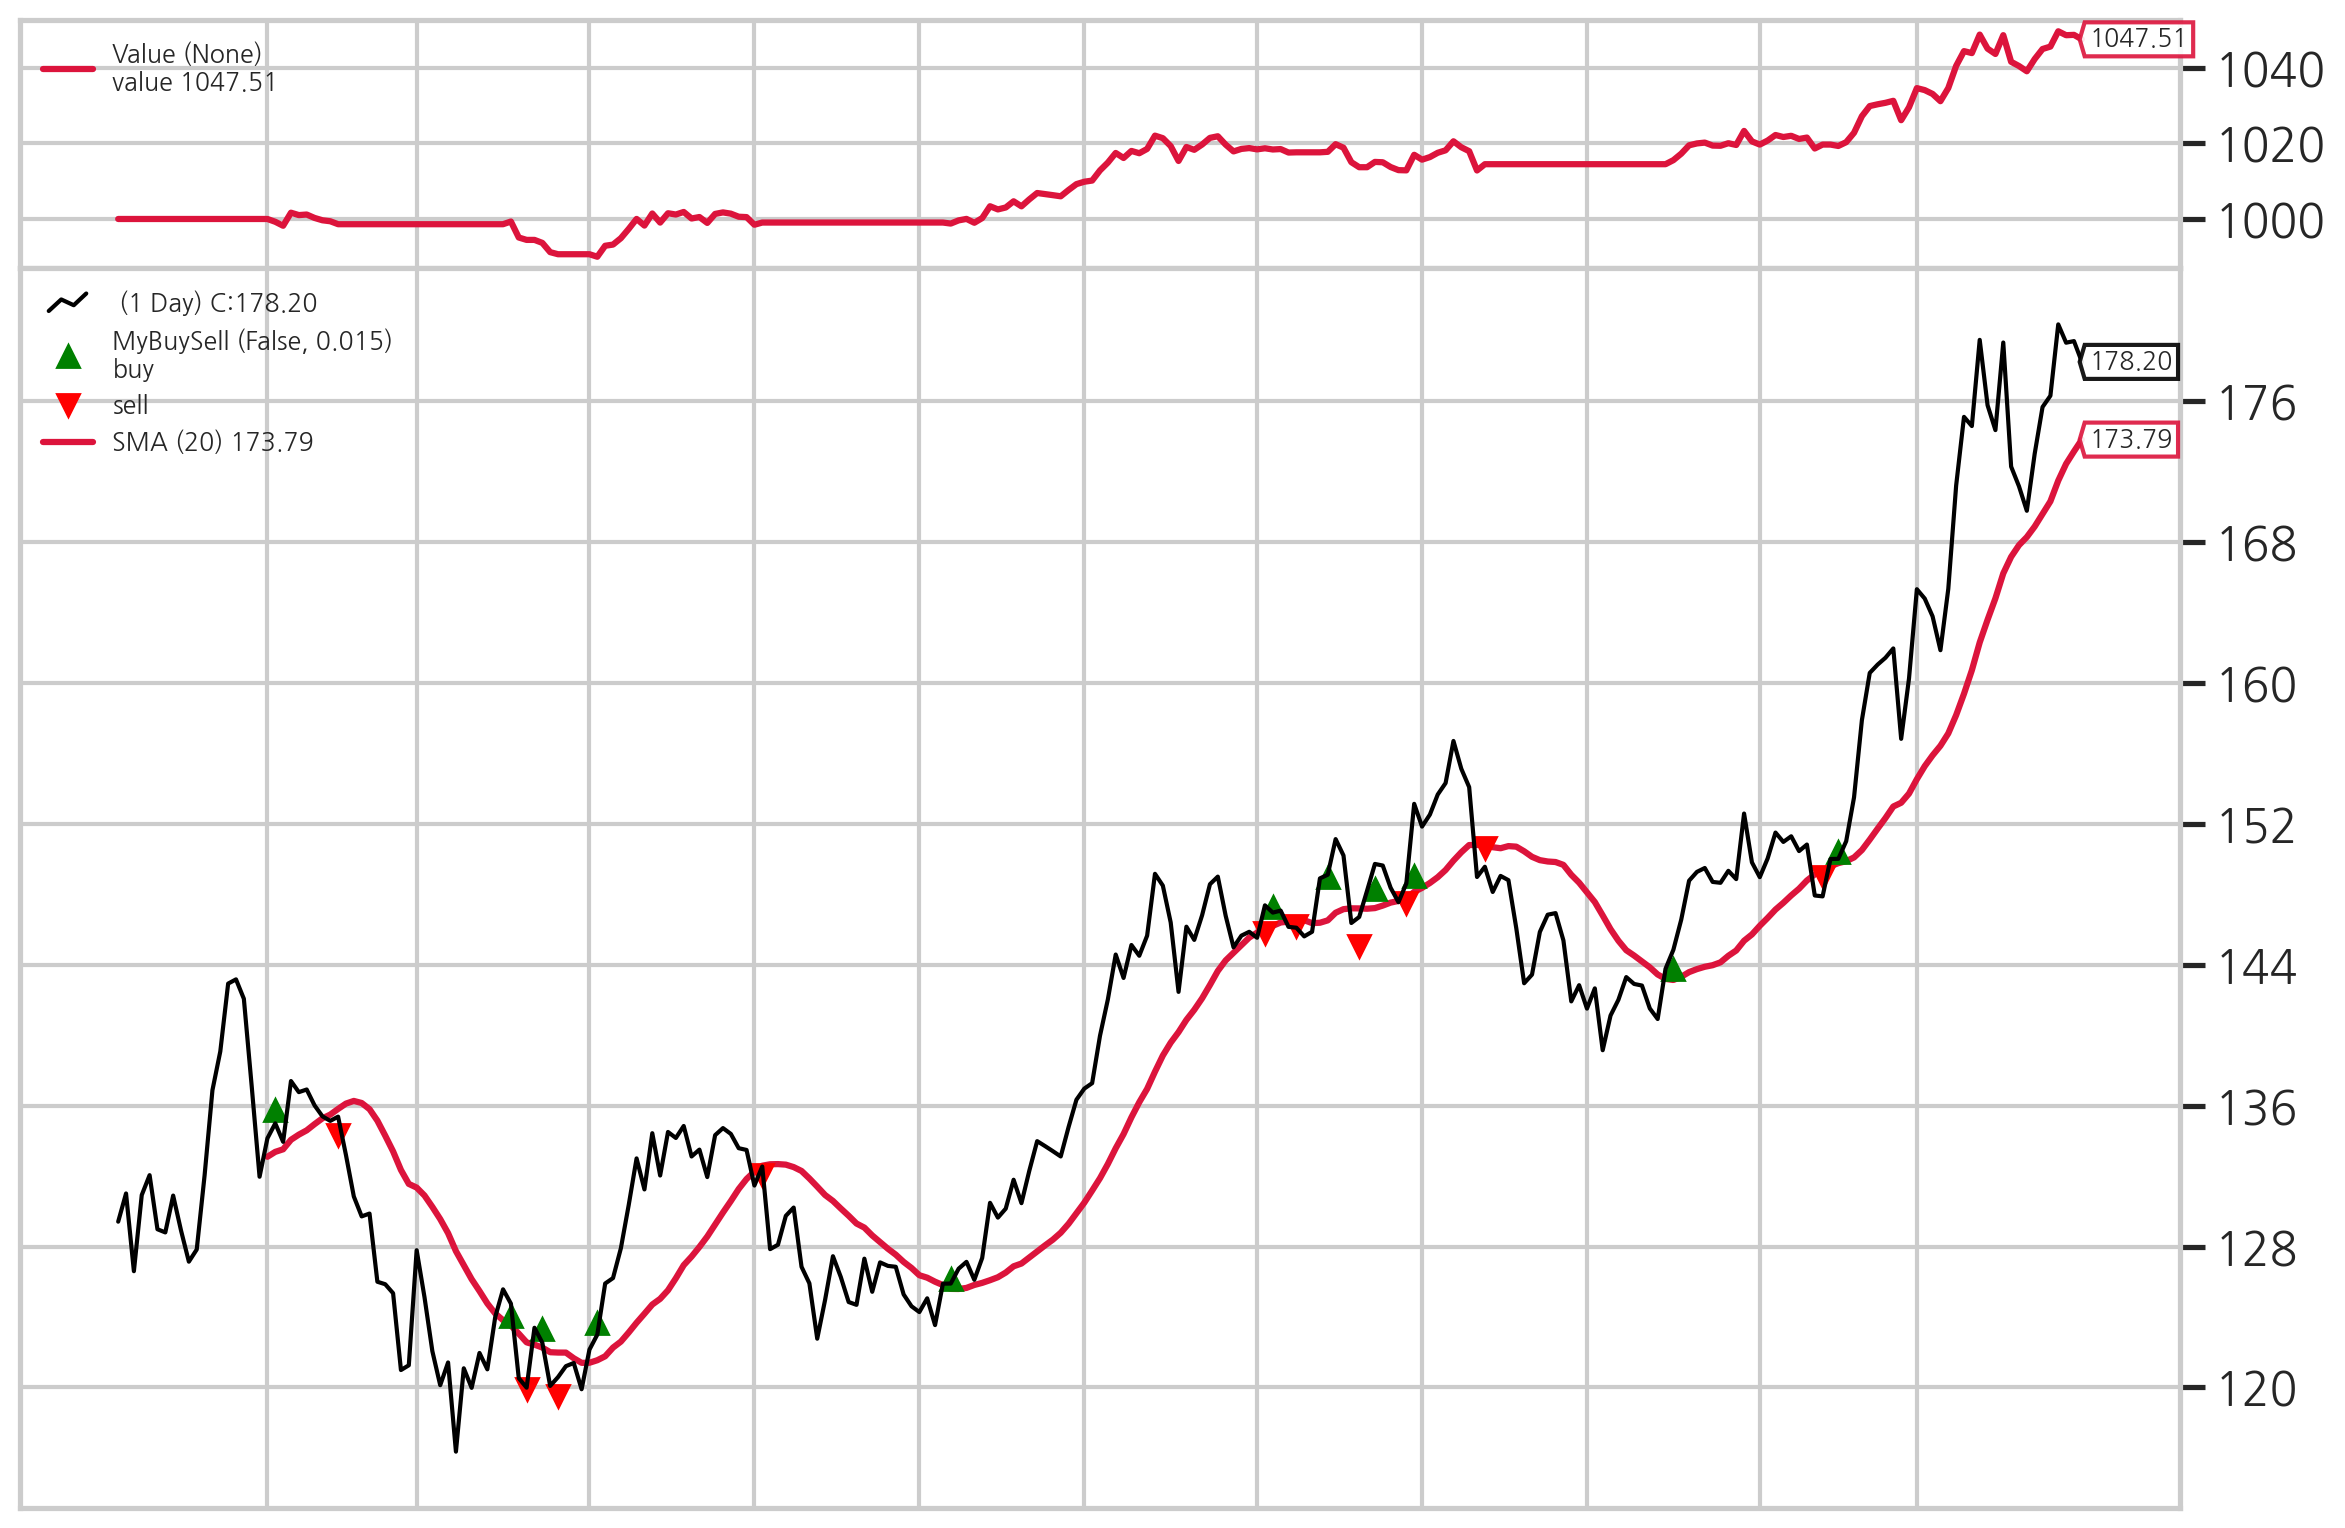

In [29]:
# 1. Cerebro 인스턴스 생성
cerebro = bt.Cerebro(stdstats=False)

# 2. 데이터 추가
cerebro.adddata(data_feed)

# 3. 최적화를 위한 전략 추가
# ma_period를 10에서 30까지 5단위로 테스트
cerebro.optstrategy(
    SmaStrategy,
    ma_period=range(10, 31, 5)  # [10, 15, 20, 25, 30]
)

# 4. 기타 설정
cerebro.broker.setcash(1000.0)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)
# 분석기 추가
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# 5. 최적화 실행
results = cerebro.run()

# 6. 결과 분석
for i, strat in enumerate(results):
    params = strat[0].p  # 또는 strat[0].params
    returns = strat[0].analyzers.returns.get_analysis()
    total_return = returns.get('rtot', 0.0)  # 총 수익률
    print(f'MA Period: {params.ma_period}, Total Return: {total_return:.2%}')

# 7. 최적의 매개변수로 단일 백테스트 실행
best_ma = 20  # 최적화 결과에서 찾은 최적값

# 새로운 Cerebro 인스턴스 생성
cerebro_single = bt.Cerebro(stdstats=False)
cerebro_single.adddata(data_feed)
cerebro_single.addstrategy(SmaStrategy, ma_period=best_ma)
cerebro_single.broker.setcash(1000.0)
cerebro_single.addobserver(MyBuySell)
cerebro_single.addobserver(bt.observers.Value)

# 8. 단일 백테스트 실행 및 시각화
print('Starting Portfolio Value: %.2f' % cerebro_single.broker.getvalue())
single_result = cerebro_single.run()
print('Final Portfolio Value: %.2f' % cerebro_single.broker.getvalue())
cerebro_single.plot(iplot=False, volume=False);

### See also
알고리즘 트레이딩과 성공적인 트레이딩 전략 구축에 대한 자세한 내용은 다음 책을 참고하세요:
- Chan, E. (2013). Algorithmic Trading: Winning Strategies and Their Rationale (Vol. 625). John Wiley & Sons.

## 12.3 Backtesting a long/short strategy based on the RSI

**RSI 기반 롱/숏 전략 백테스트**

상대 강도 지수(RSI)는 자산의 종가를 사용하여 과매도/과매수 상태를 식별하는 지표입니다. 보통 14일 기간을 사용하여 RSI를 계산하며, 0에서 100 사이의 값으로 측정됩니다(진동 지표입니다). RSI가 30 이하일 때 자산을 매수하고, 70 이상일 때 매도하는 것이 일반적입니다. 더 극단적인 수준(예: 80-20)은 잘 사용되지 않지만 더 강한 모멘텀을 의미합니다.

이 전략에서는 다음 규칙을 따르는 거래 전략을 구축합니다:

- 롱과 숏 포지션을 모두 사용할 수 있습니다.
- RSI 계산에 14일 기간(거래일 기준)을 사용합니다.
- RSI가 하한선(기본값 30)을 위로 돌파하면 롱 포지션에 진입하고, RSI가 중간 수준(값 50)보다 커지면 포지션을 종료합니다.
- RSI가 상한선(기본값 70)을 아래로 돌파하면 숏 포지션에 진입하고, RSI가 50보다 작아지면 포지션을 종료합니다.
- 동시에 하나의 포지션만 보유할 수 있습니다.

이 전략을 Meta 주식에 대해 2021년에 평가하며, 수수료는 0.1%로 적용합니다.

### How to do it...

이 레시피에서는 백트레이더에서 전략을 정의하는 두 번째 접근 방식인 신호 사용 방법을 소개합니다. 신호는 숫자로 표현되며, 예를 들어 현재 데이터 포인트와 일부 기술적 지표(TA) 사이의 차이를 의미합니다. 신호가 양수일 경우 롱(매수) 포지션을 열라는 의미입니다. 음수일 경우 숏(매도) 포지션을 열라는 의미입니다. 0의 값은 신호가 없음을 나타냅니다.


1. Import the libraries:

In [1]:
from datetime import datetime
import backtrader as bt
from backtrader_strategies.strategy_utils import *

2. Define the signal strategy based on `bt.SignalStrategy`:

모듈을 불러오고 기본 함수를 설정한 후, `bt.SignalStrategy`를 사용하여 거래 전략을 정의합니다. 이는 여러 신호(여러 진입/퇴출 조건)를 포함하는 전략이기 때문에 `bt.Signal` 대신 `bt.SignalStrategy`를 사용해야 합니다. 먼저, RSI 지표를 선택한 인수와 함께 정의합니다. 또한 백트레이더가 인기 있는 TA-Lib 라이브러리의 지표를 쉽게 사용할 수 있다는 것을 보여주기 위해 RSI 지표의 두 번째 인스턴스를 추가합니다(라이브러리는 코드를 실행하기 위해 설치되어야 합니다). 거래 전략은 이 두 번째 지표에 의존하지 않으며 참조 목적으로만 표시됩니다. 일반적으로 임의의 수의 지표를 추가할 수 있습니다.

> **참고**: 지표를 참조용으로 추가하더라도 존재 자체가 “웜업 기간”에 영향을 미칩니다. 예를 들어, 200일 이동 평균(SMA) 지표를 추가로 포함할 경우, SMA 지표에 최소한 하나의 값이 존재하기 전까지는 거래가 수행되지 않습니다.

`bt.Signal`, `bt.Strategy`, `bt.SignalStrategy`의 주요 차이점을 쉽게 비교

| 특징             | bt.Signal                                           | bt.Strategy                                           | bt.SignalStrategy                                        |
|------------------|-----------------------------------------------------|-------------------------------------------------------|----------------------------------------------------------|
| 정의            | 개별 신호를 생성하는 지표 클래스                        | 유연하고 사용자 정의가 가능한 전체 전략 클래스             | 전체 트레이딩 전략을 구현하는 클래스                        |
| 상속            | 일반적으로 `bt.Indicator` 상속                           | `bt.Strategy` 상속                                    | `bt.Strategy` 상속                                       |
| 주요 기능       | 신호 값 생성 (양수: 매수, 음수: 매도, 0: 무신호)         | 전체 트레이딩 전략 로직을 사용자 정의로 구현               | 여러 Signal을 추가하고 자동으로 매매 실행                  |
| 신호 처리       | 사용자가 직접 처리 로직 구현                            | 전략에 맞게 다양한 신호 처리 및 로직을 자유롭게 구현 가능    | 자동으로 신호 처리 및 우선순위 관리                        |
| 구현 방식       | 사용자가 직접 신호 로직 구현                             | 매수/매도 조건, 주문 실행 및 포지션 관리 등 모든 요소를 구현 | 미리 정의된 신호 처리 로직 사용                           |
| 주문 타입       | 사용자 정의 가능                                        | 시장가, 지정가, 기타 주문 유형 모두 지원 가능               | 기본적으로 시장가 주문 사용                               |
| 신호 조합       | 수동으로 여러 신호 조합 가능                            | 신호를 자유롭게 구성하고 복합적인 전략에 사용 가능          | 자동으로 여러 신호 조합 및 처리                           |
| 유연성          | 높음 (세밀한 제어와 커스터마이징 가능)                   | 매우 높음 (포괄적인 전략 설계 가능)                       | 중간 (간단한 전략에 적합)                                 |
| 복잡도          | 높음 (더 깊은 이해와 구현 능력 필요)                    | 높음 (다양한 요소를 포함한 복잡한 전략 구성 가능)           | 낮음 (사용하기 쉽고 빠른 구현 가능)                        |
| 적합한 사용 사례| 복잡하고 세밀한 제어가 필요한 전략                       | 종합적인 트레이딩 전략 구현에 적합                         | 간단하고 빠른 전략 구현                                   |
| 학습 곡선       | 가파름                                                | 가파름                                                  | 완만함                                                    |
| 코드 예시       | `class MySignal(bt.Indicator):`                       | `class MyStrategy(bt.Strategy):`                      | `cerebro.addstrategy(bt.SignalStrategy)`                 |


다음 단계는 신호를 통해 매수/매도 시점을 정의하는 것입니다. 이를 위해 `bt.CrossUp` 및 `bt.CrossDown` 지표를 사용합니다. 이 지표는 첫 번째 시리즈(가격)가 두 번째(상위 RSI 임계값) 지표를 아래에서 위로 교차할 때 1을 반환합니다. 숏 포지션을 설정하기 위해, `bt.CrossDown` 지표의 값을 음수로 만들어 신호를 음수로 설정합니다.

> **참고**: `plot=False`를 함수 호출에 추가하여 모든 지표의 플로팅을 비활성화할 수 있습니다.

다음은 사용 가능한 신호 유형에 대한 설명입니다:

- **LONGSHORT**: 이 유형은 신호에서 롱과 숏 모두를 고려합니다.
- **LONG**: 양수 신호는 롱 포지션을 시작하는 데 사용되고, 음수 신호는 롱 포지션을 종료하는 데 사용됩니다.
- **SHORT**: 음수 신호는 숏 포지션을 시작하는 데 사용되고, 양수 신호는 숏 포지션을 종료하는 데 사용됩니다.
- **LONGEXIT**: 음수 신호는 롱 포지션을 종료하는 데 사용됩니다.
- **SHORTEXIT**: 양수 신호는 숏 포지션을 종료하는 데 사용됩니다.

포지션 종료는 더 복잡할 수 있으며, 트랜잭션 논리를 기반으로 보다 정교한 전략을 구축할 수 있도록 합니다. 로직은 아래와 같습니다:

- **LONG**: `LONGEXIT` 신호가 있을 경우 롱 포지션 종료에 사용합니다. 만약 `SHORT` 신호가 있고 `LONGEXIT` 신호가 없으면, 숏 포지션을 열기 전에 롱 포지션 종료에 `SHORT` 신호가 사용됩니다.
- **SHORT**: `SHORTEXIT` 신호가 있을 경우 숏 포지션 종료에 사용합니다. 만약 `LONG` 신호가 있고 `SHORTEXIT` 신호가 없으면, 롱 포지션을 열기 전에 숏 포지션 종료에 `LONG` 신호가 사용됩니다.

> **참고**: 이미 알고 있듯이, 신호는 모든 시간 포인트마다 계산됩니다(그래프의 하단에서 시각화된 것처럼). 기본적으로, 백트레이더는 기존 포지션을 닫기 전에 새로운 주문을 생성하지 않으며, 이전에 제출된 주문이 성공적으로 실행된 후에 새로운 주문을 생성합니다.

전략의 마지막 설정 단계에서, `signal_add` 메서드를 사용하여 모든 신호를 추적하도록 설정합니다. 포지션 종료 시점은 RSI 값(상위/하위 값 50)을 사용하여 결정되며, 파이썬에서는 `True`가 -1과 같은 의미를 가집니다.



In [2]:
class RsiSignalStrategy(bt.SignalStrategy):
    # RSI 전략의 기본 파라미터를 설정합니다
    # rsi_periods: RSI를 계산할 기간을 설정 (기본값 14일)
    # rsi_upper: RSI 상단 기준선 설정 (기본값 70) - 과매수 구간
    # rsi_lower: RSI 하단 기준선 설정 (기본값 30) - 과매도 구간
    # rsi_mid: RSI 중간 기준선 설정 (기본값 50) - 중립 구간
    params = dict(rsi_periods=14, rsi_upper=70, 
                  rsi_lower=30, rsi_mid=50)

    def __init__(self):
        # backtrader의 RSI 지표를 생성합니다
        # period: RSI 계산에 사용할 기간 수
        # upperband: 과매수 기준이 되는 상단선
        # lowerband: 과매도 기준이 되는 하단선
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                                upperband=self.p.rsi_upper,
                                lowerband=self.p.rsi_lower)

        # TA-lib의 RSI 지표도 참고용으로 추가합니다
        # 실제 전략에는 사용되지 않으며, 비교 목적으로만 표시됩니다
        bt.talib.RSI(self.data, plotname="TA_RSI")
    
        # 롱 포지션(매수) 진입/청산 조건을 설정합니다
        # CrossUp: RSI가 하단선(30)을 상향 돌파할 때 매수 신호 발생
        # RSI가 중간선(50)보다 커지면 롱 포지션을 청산합니다
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))

        # 숏 포지션(매도) 진입/청산 조건을 설정합니다
        # CrossDown: RSI가 상단선(70)을 하향 돌파할 때 매도 신호 발생
        # RSI가 중간선(50)보다 작아지면 숏 포지션을 청산합니다
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)

3. Download data:

2단계에서 우리는 2021년 Meta의 주가를 평가합니다.

In [10]:
# data = bt.feeds.YahooFinanceData(dataname="META", 
#                                  fromdate=datetime(2021, 1, 1),
#                                  todate=datetime(2021, 12, 31))



# yfinance 라이브러리를 가져와서 야후 파이낸스에서 데이터를 다운로드하기 위해 사용합니다
import yfinance as yf

# META 주식의 2021년 1월 1일부터 12월 31일까지의 데이터를 다운로드합니다
data = yf.download("META", start="2021-01-01", end="2021-12-31")

# 다운로드한 데이터를 CSV 파일로 저장합니다
# 이후 백트레이더에서 사용하기 위해 로컬에 저장해둡니다
data.to_csv("meta_data.csv")


[*********************100%***********************]  1 of 1 completed


4. Set up and run the backtest:

이후 백테스트를 설정할 때 다음과 같은 조정을 합니다:

- 자산 크기 조정 방법을 추가하여 특정 포인트에 자산의 비율을 맞춥니다.
- 수수료를 0.1%로 설정합니다.
- 백테스트를 실행하기 전에 포트폴리오의 현재 가치를 조회하여, 백테스트 후에도 동일하게 유지되도록 설정합니다.

In [15]:
# Pandas DataFrame을 backtrader가 이해할 수 있는 형식으로 변환합니다
# PandasData 클래스를 사용하여 Pandas DataFrame을 backtrader에서 사용할 수 있는 데이터 피드로 변환
data_feed = bt.feeds.PandasData(dataname=data)

# Cerebro 엔진을 초기화합니다. stdstats=False로 설정하여 기본 통계를 비활성화합니다
cerebro = bt.Cerebro(stdstats = False)

# RSI 전략을 Cerebro에 추가합니다
cerebro.addstrategy(RsiSignalStrategy)

# 데이터 피드를 Cerebro에 추가합니다
cerebro.adddata(data_feed)

# 고정 사이즈 시저(Sizer)를 추가합니다 - 각 거래마다 1주씩 거래
cerebro.addsizer(bt.sizers.SizerFix, stake=1)

# 초기 현금을 1000달러로 설정합니다
cerebro.broker.setcash(1000.0)

# 거래 수수료를 0.1%(0.001)로 설정합니다
cerebro.broker.setcommission(commission=0.001)

# 매수/매도 시그널을 관찰하기 위한 커스텀 옵저버를 추가합니다
cerebro.addobserver(MyBuySell)

# 포트폴리오 가치를 추적하기 위한 Value 옵저버를 추가합니다
cerebro.addobserver(bt.observers.Value)

# 백테스트 시작 전 포트폴리오 가치를 출력합니다
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

# 백테스트를 실행합니다
cerebro.run()

# 백테스트 종료 후 최종 포트폴리오 가치를 출력합니다
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")


Starting Portfolio Value: 1000.00
Final Portfolio Value: 1042.56


5. Plot the results:

마지막 단계에서는 모든 신호의 결과를 요약하여 전략의 성과를 분석합니다.

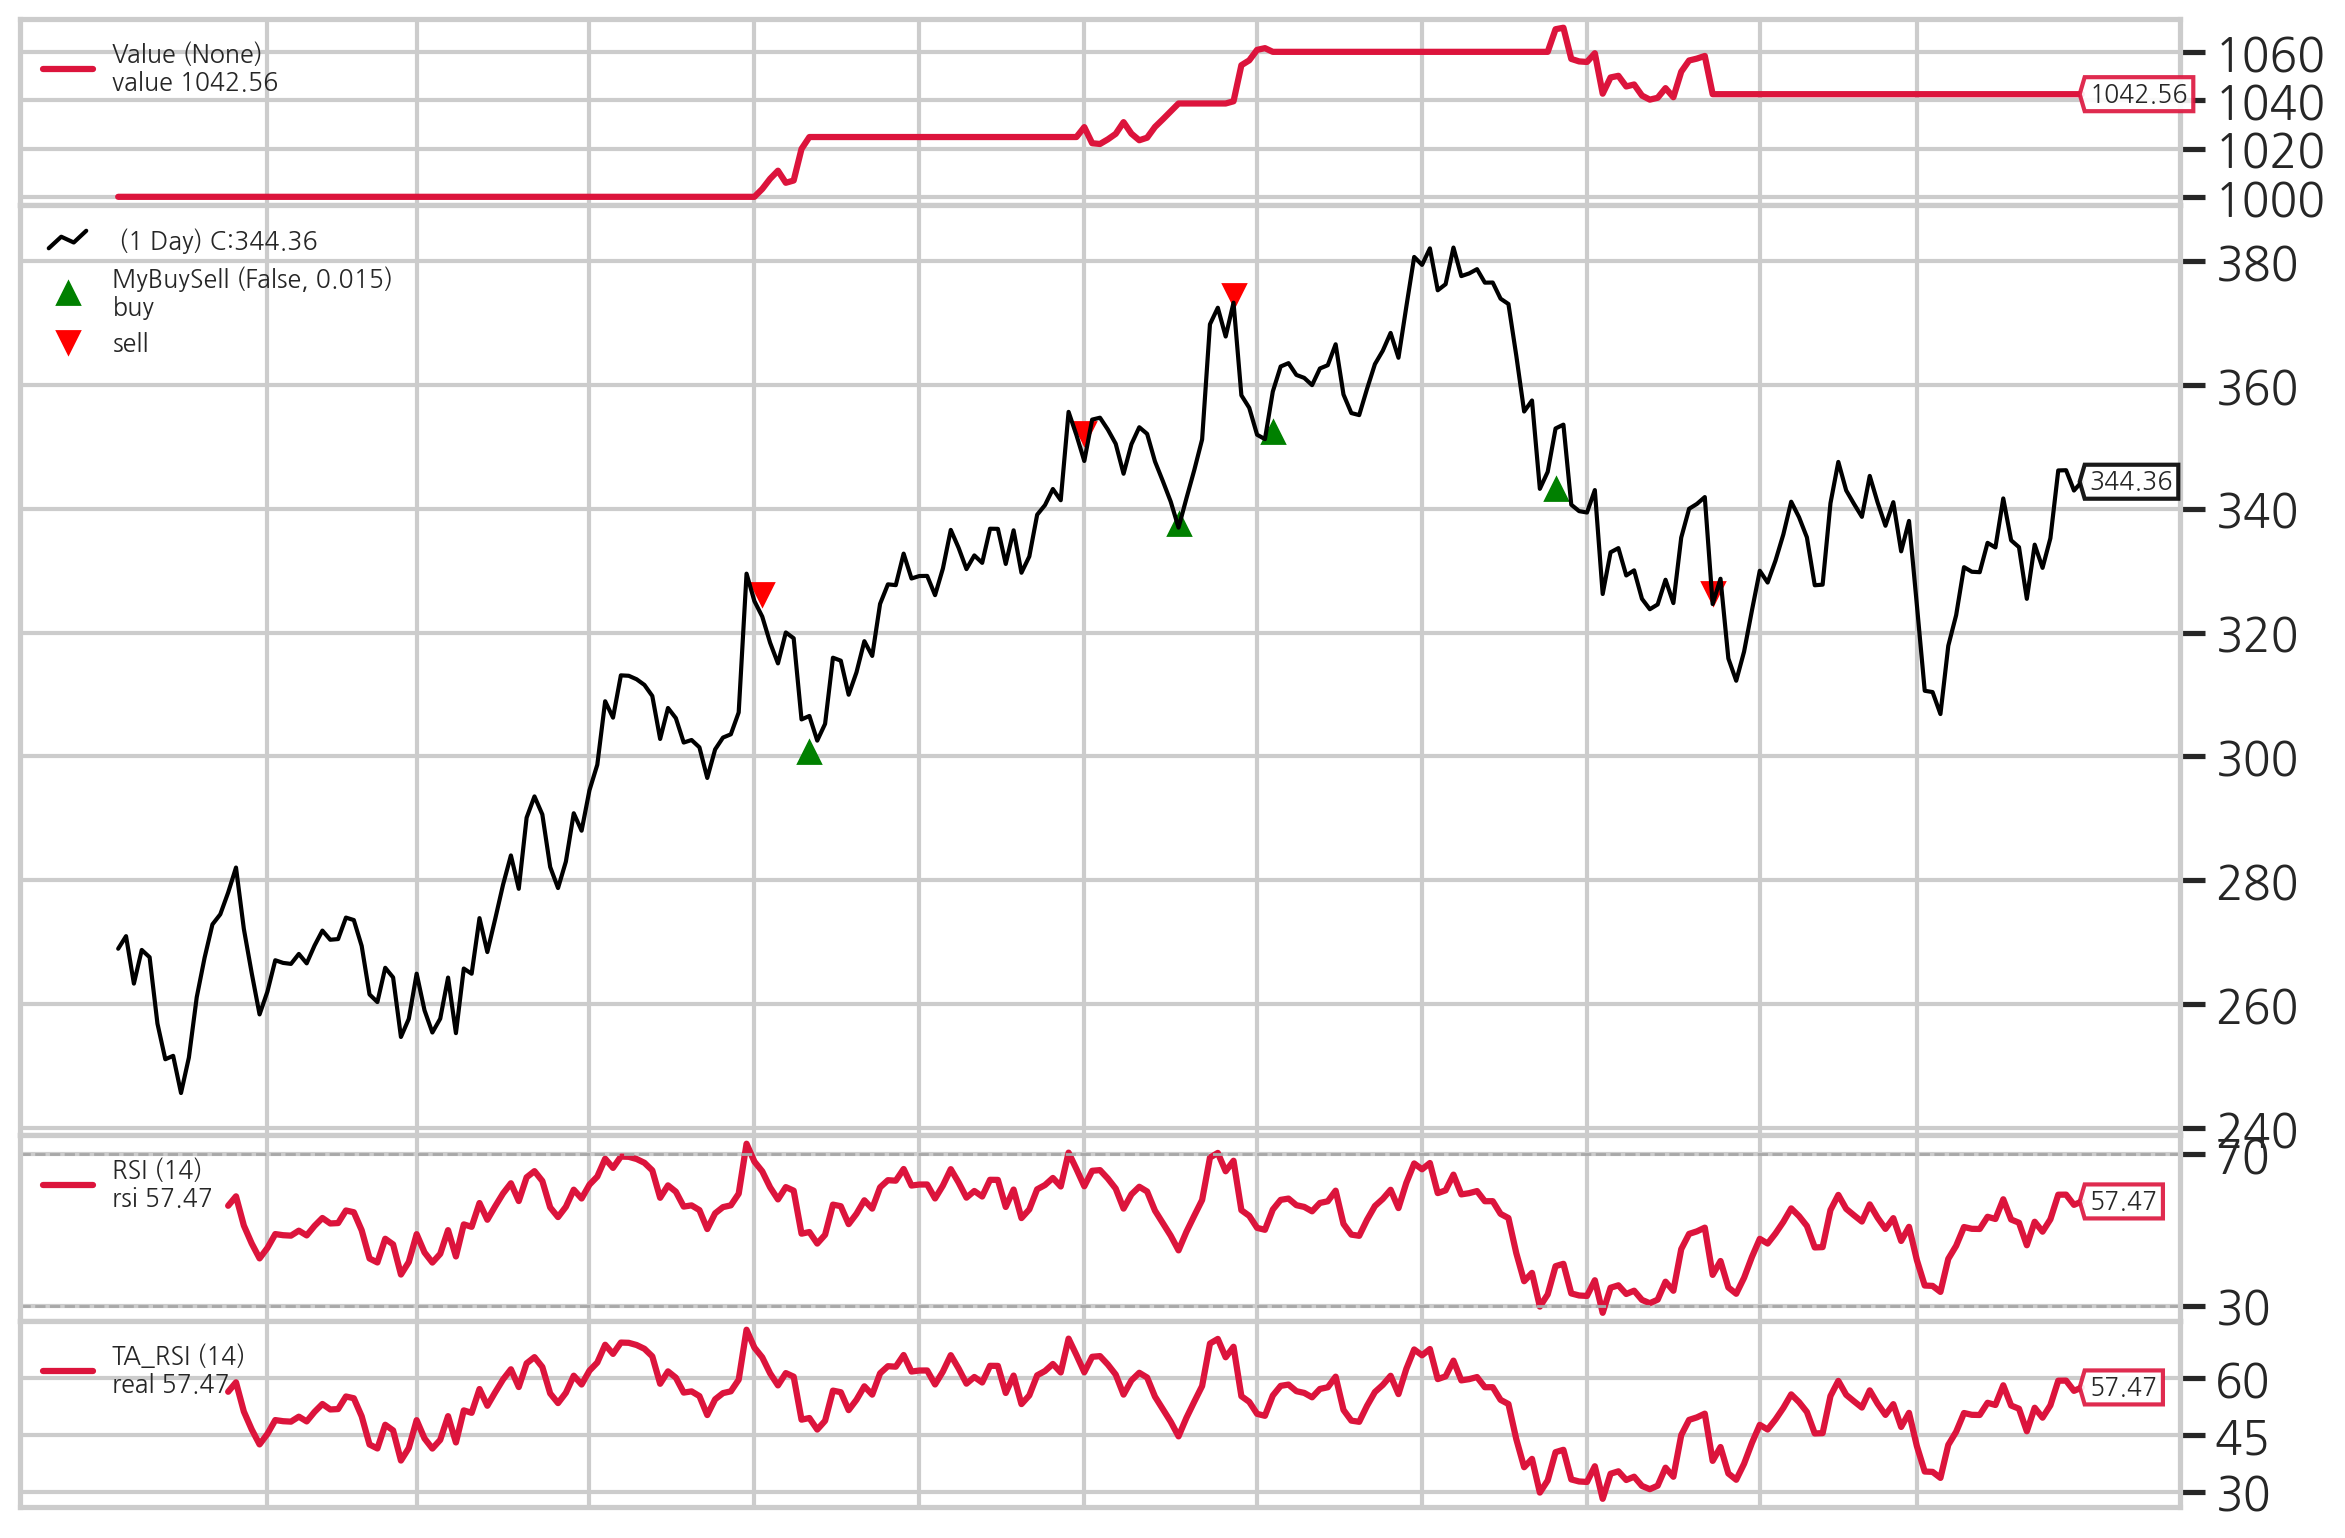

In [19]:
cerebro.plot(iplot=False, volume=False);

그림 12.5: 백테스트 기간 동안의 전략 동작/성과 요약. 삼각형들은 쌍으로 살펴봅니다.

쌍의 첫 번째 삼각형은 포지션 진입을 나타냅니다(삼각형이 초록색이고 위를 향하면 매수, 빨간색이고 아래를 향하면 매도). 반대 방향의 다음 삼각형은 포지션 청산을 나타냅니다. 차트 하단의 RSI와 포지션 진입/청산을 매칭할 수 있습니다. 때때로 동일한 색상의 삼각형이 연속으로 나타나는데, 이는 RSI가 포지션 진입선 주변에서 변동하면서 여러 번 교차하기 때문입니다. 하지만 실제 포지션은 첫 번째 신호에서만 진입합니다(누적 없음이 모든 백테스트의 기본 설정입니다).

### There's more

이번 레시피에서는 백테스팅 프레임워크에 사이저(sizer)와 수수료(commission)라는 두 가지 새로운 개념을 소개했습니다. 이 두 가지 구성 요소를 사용하여 실험해볼 수 있는 유용한 것들이 더 있습니다.

1. RSI 전략으로 "올인" 하기:

이전에는 우리의 단순한 전략이 자산 한 단위로만 매수 또는 매도를 했습니다. 하지만 이 동작을 쉽게 수정하여 사용 가능한 모든 현금을 사용할 수 있습니다. addsizer 메서드를 사용하여 AllInSizer를 추가하기만 하면 됩니다:

In [20]:
# Cerebro 인스턴스를 생성합니다. stdstats=False로 설정하여 기본 통계를 비활성화합니다
cerebro = bt.Cerebro(stdstats = False)

# RSI 전략을 백테스터에 추가합니다
cerebro.addstrategy(RsiSignalStrategy)

# 데이터 피드를 백테스터에 추가합니다
cerebro.adddata(data_feed)

# AllInSizer를 추가하여 매 거래마다 가용 자금을 모두 사용하도록 설정합니다
cerebro.addsizer(bt.sizers.AllInSizer)

# 초기 현금을 1000달러로 설정합니다
cerebro.broker.setcash(1000.0)

# 거래 수수료를 0.1%(0.001)로 설정합니다
cerebro.broker.setcommission(commission=0.001)

# 포트폴리오 가치를 추적하기 위한 Value 옵저버를 추가합니다
cerebro.addobserver(bt.observers.Value)

# 백테스트 시작 전 포트폴리오 가치를 출력합니다
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

# 백테스트를 실행합니다
cerebro.run()

# 백테스트 종료 후 최종 포트폴리오 가치를 출력합니다
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1183.95


2. 주당 고정 수수료 체계를 정의하고 백테스트 실행하기:

RSI 기반 전략의 초기 백테스트에서는 0.1%의 수수료율을 사용했습니다. 하지만 일부 브로커는 주당 고정 수수료와 같이 다른 수수료 체계를 가질 수 있습니다. 이러한 정보를 반영하기 위해서는 수수료 체계를 저장하는 커스텀 클래스를 정의해야 합니다. bt.CommInfoBase를 상속받아 필요한 정보를 추가할 수 있습니다:

In [21]:
class FixedCommisionShare(bt.CommInfoBase):
    """
    주식 거래당 고정 수수료를 적용하는 수수료 체계 클래스입니다.
    
    매개변수:
        commission (float): 주식 1주당 적용되는 고정 수수료 (기본값: 0.03)
        stocklike (bool): 주식과 유사한 자산 여부 (기본값: True)
        commtype (int): 수수료 유형 - 고정 수수료 사용 (bt.CommInfoBase.COMM_FIXED)
    """
    params = (
        ("commission", 0.03),  # 주당 3센트의 고정 수수료
        ("stocklike", True),   # 주식형 자산 설정
        ("commtype", bt.CommInfoBase.COMM_FIXED),  # 고정 수수료 방식 사용
    )

    def _getcommission(self, size, price, pseudoexec):
        """
        거래 수수료를 계산합니다.
        
        매개변수:
            size (int): 거래 수량 (주식 수)
            price (float): 거래 가격 
            pseudoexec (bool): 가상 실행 여부
            
        반환값:
            float: 총 수수료 (거래 수량 * 주당 고정 수수료)
        """
        return abs(size) * self.p.commission  # 거래 수량의 절대값 * 주당 수수료

정의의 가장 중요한 측면은 주당 $0.03의 고정 수수료와 _getcommission 메서드에서 수수료가 계산되는 방식입니다. 거래 수량의 절대값에 고정 수수료를 곱하여 계산합니다. 이 정보를 백테스트에 쉽게 입력할 수 있습니다. "all-in" 전략을 사용한 이전 예제를 기반으로, 코드는 다음과 같습니다:

In [23]:
# Cerebro 인스턴스를 생성합니다. stdstats=False로 설정하여 기본 통계를 비활성화합니다
cerebro = bt.Cerebro(stdstats = False)

# RSI 신호 전략을 백테스터에 추가합니다
cerebro.addstrategy(RsiSignalStrategy)

# 준비된 데이터 피드를 백테스터에 추가합니다
cerebro.adddata(data_feed)

# 모든 자금을 투자하는 AllInSizer를 사이징 방식으로 설정합니다
cerebro.addsizer(bt.sizers.AllInSizer)

# 초기 투자금을 1000달러로 설정합니다
cerebro.broker.setcash(1000.0)

# 앞서 정의한 주당 고정 수수료 체계를 브로커에 적용합니다
cerebro.broker.addcommissioninfo(FixedCommisionShare())

# 포트폴리오 가치 변화를 관찰하기 위한 Value 옵저버를 추가합니다
cerebro.addobserver(bt.observers.Value)

# 백테스트 시작 전 초기 포트폴리오 가치를 출력합니다
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

# 백테스트를 실행합니다
cerebro.run()

# 백테스트 종료 후 최종 포트폴리오 가치를 출력합니다
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")


Starting Portfolio Value: 1000.00
Final Portfolio Value: 1189.94


3. 주문당 고정 수수료 체계를 정의하고 백테스트 실행하기:

일부 브로커는 주문당 고정 수수료를 제공할 수 있습니다. 다음 코드에서는 주문 규모와 관계없이 주문당 $2.5의 고정 수수료를 지불하는 커스텀 수수료 체계를 정의합니다. commission 매개변수의 값과 _getcommission 메서드에서 수수료를 계산하는 방식을 변경했습니다. 이번에는 이 메서드가 항상 미리 지정한 $2.5를 반환합니다:

In [24]:
class FixedCommisionOrder(bt.CommInfoBase):
    """
    주문당 고정 수수료를 적용하는 수수료 체계 클래스입니다.
    
    매개변수:
        commission (float): 주문당 고정 수수료 금액입니다. 기본값은 $2.5입니다.
        stocklike (bool): 주식과 같은 자산 유형인지를 나타냅니다. 기본값은 True입니다.
        commtype (int): 수수료 유형을 나타냅니다. 고정 수수료를 의미하는 COMM_FIXED로 설정됩니다.
    """
    params = (
        ("commission", 2.5),      # 주문당 $2.5의 고정 수수료
        ("stocklike", True),      # 주식과 같은 자산 유형 설정
        ("commtype", bt.CommInfoBase.COMM_FIXED),  # 고정 수수료 유형으로 설정
    )

    def _getcommission(self, size, price, pseudoexec):
        """
        주문에 대한 수수료를 계산하는 메서드입니다.
        주문 크기나 가격에 관계없이 항상 고정된 수수료를 반환합니다.
        
        매개변수:
            size (float): 주문 수량 (이 구현에서는 사용되지 않음)
            price (float): 주문 가격 (이 구현에서는 사용되지 않음)
            pseudoexec (bool): 가상 실행 여부 (이 구현에서는 사용되지 않음)
            
        반환값:
            float: 설정된 고정 수수료 금액
        """
        return self.p.commission

백테스트 설정은 이전과 거의 동일하므로 포함하지 않습니다. addcommissioninfo 메서드를 사용하여 다른 클래스를 전달하기만 하면 됩니다. 백테스트 결과는 다음과 같습니다:

In [25]:
# Cerebro 인스턴스를 생성합니다. stdstats=False로 설정하여 기본 통계를 비활성화합니다
cerebro = bt.Cerebro(stdstats = False)

# RSI 기반 전략을 백테스터에 추가합니다
cerebro.addstrategy(RsiSignalStrategy)

# 데이터 피드를 백테스터에 추가합니다
cerebro.adddata(data_feed)

# 모든 자금을 투자하는 사이징 전략을 추가합니다
cerebro.addsizer(bt.sizers.AllInSizer)

# 초기 투자금을 $1,000로 설정합니다
cerebro.broker.setcash(1000.0)

# 주문당 고정 수수료($2.5) 체계를 추가합니다
cerebro.broker.addcommissioninfo(FixedCommisionOrder())

# 포트폴리오 가치 변화를 관찰하기 위한 옵저버를 추가합니다
cerebro.addobserver(bt.observers.Value)

# 백테스트 시작 전 초기 포트폴리오 가치를 출력합니다
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

# 백테스트를 실행합니다
cerebro.run()

# 백테스트 종료 후 최종 포트폴리오 가치를 출력합니다
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")


Starting Portfolio Value: 1000.00
Final Portfolio Value: 1174.70


### See also 
아래에서 backtrader의 문서에 대한 유용한 참조를 찾을 수 있습니다:
- 사이저(sizer)에 대해 더 자세히 알아보기: https://www.backtrader.com/docu/sizers-reference/
- 수수료 체계와 사용 가능한 매개변수에 대해 더 자세히 알아보기: https://www.backtrader.com/docu/commission-schemes/commission-schemes/


## 12.4 Backtesting a buy/sell strategy based on Bollinger bands

**볼린저 밴드를 기반으로 한 매수/매도 전략 백테스팅**

볼린저 밴드는 시간에 따른 특정 자산의 가격과 변동성을 도출하기 위해 사용되는 통계적 방법입니다. 볼린저 밴드를 얻기 위해서는 주어진 기간 동안의 이동 평균과 표준 편차(보통 20일)를 계산해야 합니다. 그런 다음, 이동 평균 위아래로 표준 편차의 K 배(일반적으로 2배)를 설정하여 상/하단 밴드를 구성합니다.

밴드의 해석은 매우 간단합니다: 변동성이 증가하면 밴드가 넓어지고, 변동성이 감소하면 밴드가 축소됩니다.

이 예제에서는 볼린저 밴드를 이용해 과매수 및 과매도 수준을 식별하고 해당 영역을 기준으로 거래를 수행하는 단순한 트레이딩 전략을 구축합니다. 전략 규칙은 다음과 같습니다:

- 가격이 하단 볼린저 밴드를 상향 돌파할 때 매수.
- 가격이 상단 볼린저 밴드를 하향 돌파할 때 (주식을 보유 중일 때만) 매도.
- 올인 전략 — 매수 시 가능한 최대 주식을 매수.
- 공매도는 허용되지 않음.

이 전략은 Microsoft 주식을 대상으로 2021년에 평가했습니다. 추가로, 수수료는 0.1%로 설정했습니다. 

### How to do it...


1. Import the libraries:

In [4]:
import backtrader as bt
import datetime
import pandas as pd
from backtrader_strategies.strategy_utils import *

2. Define the strategy based on the Bollinger Bands:

볼린저 밴드를 기반으로 한 전략을 구현할 때 사용되는 코드와 이전 예제에서 사용된 코드 사이에는 많은 유사점이 있습니다. 따라서 우리는 새로운 기능들에 대해서만 논의하며, 추가적인 내용은 *backtrader를 이용한 이벤트 기반 백테스팅* 예제를 참고하시면 됩니다.

이 전략에서 올인(all-in)을 하기 때문에, *cheat_on_open*이라는 메서드를 사용해야 합니다. 이는 당일(t)의 종가를 이용해 신호를 계산하되, 다음 날(t+1)의 시가를 기준으로 매수할 주식 수를 계산하는 방식을 의미합니다. 이를 위해 *Cerebro* 객체를 생성할 때 *cheat_on_open=True*로 설정합니다. (아래에 상세 설명 있음)

그 결과, *Strategy* 클래스 내에서 *next* 대신 *next_open* 메서드를 정의합니다. 이것은 *Cerebro*에게 우리가 시가를 기준으로 거래를 수행할 것임을 명확히 알려줍니다. 잠재적인 매수 주문을 만들기 전에, 우리는 t+1일의 시가를 사용해 매수 가능한 최대 주식 수를 수동으로 계산합니다.

볼린저 밴드를 기반으로 매수/매도 신호를 계산할 때, 우리는 *CrossOver* 지표를 사용합니다. 이 지표는 다음을 반환합니다:

- 첫 번째 데이터(가격)가 두 번째 데이터(지표)를 상향 돌파할 경우 1
- 첫 번째 데이터(가격)가 두 번째 데이터(지표)를 하향 돌파할 경우 -1

또한, 특정 방향으로만 교차를 고려하고자 할 때 *CrossUp* 및 *CrossDown* 함수를 사용할 수 있습니다. 매수 신호는 다음과 같이 설정합니다:

In [5]:
class BollingerBandStrategy(bt.Strategy):
    # 전략의 파라미터를 정의합니다
    params = (("period", 20),  # 볼린저 밴드를 계산할 기간 (기본값: 20일)
              ("devfactor", 2.0),)  # 표준편차의 배수 (기본값: 2.0)

    def __init__(self):
        # 데이터 라인을 초기화합니다
        self.data_close = self.datas[0].close  # 종가 데이터
        self.data_open = self.datas[0].open    # 시가 데이터

        # 주문 상태를 추적하기 위한 변수
        self.order = None

        # 볼린저 밴드 지표를 생성합니다
        # - period: 이동평균을 계산할 기간
        # - devfactor: 표준편차의 배수 (밴드의 폭을 결정)
        self.b_band = bt.ind.BollingerBands(self.datas[0], 
                                            period=self.p.period, 
                                            devfactor=self.p.devfactor)
        
        # 매수 신호를 생성합니다
        # - 가격이 하단 밴드를 상향 돌파할 때 매수 신호(1) 발생
        # - plotname은 차트에서 이 신호를 식별하는데 사용됨
        self.buy_signal = bt.ind.CrossOver(self.datas[0], 
                                           self.b_band.lines.bot,
                                           plotname="buy_signal")
        
        # 매도 신호를 생성합니다
        # - 가격이 상단 밴드를 하향 돌파할 때 매도 신호(-1) 발생
        self.sell_signal = bt.ind.CrossOver(self.datas[0], 
                                            self.b_band.lines.top,
                                            plotname="sell_signal")

    def log(self, txt):
        # 날짜와 함께 로그 메시지를 출력하는 헬퍼 함수
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        # 주문 상태가 변경될 때마다 호출되는 콜백 함수
        if order.status in [order.Submitted, order.Accepted]:
            # 주문이 제출되거나 수락된 상태 - 아무것도 하지 않음
            return

        if order.status in [order.Completed]:
            # 주문이 체결되었을 때 로그를 출력
            direction = "b" if order.isbuy() else "s"  # 매수/매도 구분
            log_str = get_action_log_string(
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            # 주문이 실패했을 때 로그를 출력
            self.log("Order Failed")

        # 주문 상태 초기화
        self.order = None

    def notify_trade(self, trade):
        # 거래가 종료될 때마다 호출되는 콜백 함수
        if not trade.isclosed:
            return

        # 거래 결과(손익)를 로그로 출력
        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next_open(self):
        # 다음 봉의 시가에서 거래 로직을 실행
        if not self.position:  # 포지션이 없을 때
            if self.buy_signal > 0:  # 매수 신호 발생
                # 현재 보유 현금으로 살 수 있는 최대 주식 수 계산
                size = int(self.broker.getcash() / self.datas[0].open)
                # 매수 주문 생성 전 로그 출력
                log_str = get_action_log_string("b", "c", 
                                                price=self.data_close[0], 
                                                size=size,
                                                cash=self.broker.getcash(),
                                                open=self.data_open[0],
                                                close=self.data_close[0])
                self.log(log_str)
                # 매수 주문 제출
                self.order = self.buy(size=size)
        else:  # 포지션이 있을 때
            if self.sell_signal < 0:  # 매도 신호 발생
                # 매도 주문 생성 전 로그 출력
                log_str = get_action_log_string("s", "c", self.data_close[0], 
                                                self.position.size)
                self.log(log_str)
                # 보유 주식 전량 매도 주문 제출
                self.order = self.sell(size=self.position.size)

    def start(self):
        # 백테스트 시작 시 초기 포트폴리오 가치 출력
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        # 백테스트 종료 시 최종 포트폴리오 가치 출력
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")

3. Download data:

In [34]:
# data = bt.feeds.YahooFinanceData(
#     dataname="MSFT",
#     fromdate=datetime.datetime(2021, 1, 1),
#     todate=datetime.datetime(2021, 12, 31)
# )

# yfinance 라이브러리를 가져와서 야후 파이낸스에서 데이터를 다운로드하기 위해 사용합니다
import yfinance as yf

# META 주식의 2021년 1월 1일부터 12월 31일까지의 데이터를 다운로드합니다
data = yf.download("MSFT", start="2021-01-01", end="2021-12-31")
# data = yf.download("MSFT", start="2022-01-01")

# 다운로드한 데이터를 CSV 파일로 저장합니다
# 이후 백트레이더에서 사용하기 위해 로컬에 저장해둡니다
data.to_csv("msft_data.csv")

[*********************100%***********************]  1 of 1 completed


4. Set up the backtest:

마지막으로, 포트폴리오에서 발생하는 일을 평가하는 데 도움을 주는 분석기(analyzer)를 사용합니다. 이번 예제에서는 두 가지 분석기를 사용합니다:

- **Returns**: 전체 기간에 걸쳐 계산된 다양한 로그 수익률 집합으로, 총 복리 수익률, 전체 기간의 평균 수익률 및 연간화된 수익률을 포함합니다.
- **TimeReturn**: 제공된 기간(이 경우 일 단위 데이터)을 기준으로 시간에 따른 수익률 집합입니다.

우리는 같은 이름의 관찰자(observer)를 추가함으로써 *TimeReturn* 분석기와 동일한 결과를 얻을 수 있습니다:

In [35]:
# Cerebro 엔진을 초기화합니다
# stdstats=False: 기본 통계를 비활성화
# cheat_on_open=True: 다음 봉의 시가에 주문 실행 
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

# 우리가 만든 볼린저 밴드 전략을 추가합니다
cerebro.addstrategy(BollingerBandStrategy)

# 판다스 데이터프레임을 백트레이더가 이해할 수 있는 형식으로 변환합니다
data_feed = bt.feeds.PandasData(dataname=data)

# 데이터를 Cerebro 엔진에 추가합니다
cerebro.adddata(data_feed)

# 초기 현금을 10,000달러로 설정합니다
cerebro.broker.setcash(10000.0)

# 거래 수수료를 0.1%로 설정합니다
cerebro.broker.setcommission(commission=0.001)

# 매수/매도 시그널을 시각화하기 위한 관찰자를 추가합니다
cerebro.addobserver(MyBuySell)

# 포트폴리오 가치 변화를 추적하는 관찰자를 추가합니다
cerebro.addobserver(bt.observers.Value)

# 전체 수익률을 계산하는 분석기를 추가합니다
cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")

# 시간별 수익률을 계산하는 분석기를 추가합니다
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="time_return")


`cheat_on_open`은 백테스팅에서 현실적인 거래 시나리오를 시뮬레이션하기 위한 중요한 설정입니다.

### 기본 개념

1. **일반적인 거래 시나리오**:
```
당일(t)   : 장 마감 후 종가로 매매 신호를 계산
다음날(t+1): 장 시작 시 시가로 실제 거래 실행
```

2. **cheat_on_open=False (기본값)일 때**:
```python
def next(self):  # 당일 봉에서
    # 이미 당일 종가를 알고 있는 상태에서
    if signal:  # 신호 발생하면
        self.buy()  # 당일 종가로 거래 실행
```

3. **cheat_on_open=True일 때**:
```python
def next_open(self):  # 다음날 시가에서
    if signal:  # 전일 종가로 계산된 신호 기반
        self.buy()  # 다음날 시가로 거래 실행
```

### 실제 예시

```python
# 비현실적인 시나리오 (cheat_on_open=False)
t일 종가: $100
t일: "가격이 $100이니까 20주 살 수 있겠다" → t일 종가에 20주 매수

# 현실적인 시나리오 (cheat_on_open=True)
t일 종가: $100
t+1일 시가: $102
t일: "가격이 $100이니까 매수 신호 발생"
t+1일: "시가가 $102니까 19주 살 수 있겠다" → t+1일 시가에 19주 매수
```

### 왜 필요한가?

1. **현실성**: 실제 거래에서는 종가에 거래할 수 없고, 다음날 시가에 거래해야 함
2. **정확한 포지션 사이징**: 실제 거래 가격으로 정확한 매수 수량 계산 가능
3. **룩어헤드 바이어스(Look-ahead bias) 방지**: 아직 발생하지 않은 가격으로 거래하는 것을 방지

이러한 이유로 올인 전략처럼 정확한 포지션 사이징이 중요한 경우 `cheat_on_open=True`를 사용하는 것이 더 현실적인 백테스트 결과를 얻을 수 있습니다.

5. Run the backtest:

In [36]:
backtest_result = cerebro.run()

Initial Portfolio Value: 10000.00
2021-03-01: BUY CREATED - Price: 236.94, Size: 42.00, Cash: 10000.00, Open: 235.90, Close: 236.94
2021-03-01: BUY EXECUTED - Price: 235.90, Size: 42.00, Cost: 9907.80, Commission: 9.91
2021-04-13: SELL CREATED - Price: 258.49, Size: 42.00
2021-04-13: SELL EXECUTED - Price: 257.26, Size: -42.00, Cost: 9907.80, Commission: 10.80
2021-04-13: OPERATION RESULT - Gross: 897.12, Net: 876.41
2021-05-07: BUY CREATED - Price: 252.46, Size: 43.00, Cash: 10876.41, Open: 252.15, Close: 252.46
2021-05-07: BUY EXECUTED - Price: 252.15, Size: 43.00, Cost: 10842.45, Commission: 10.84
2021-06-16: SELL CREATED - Price: 257.38, Size: 43.00
2021-06-16: SELL EXECUTED - Price: 259.40, Size: -43.00, Cost: 10842.45, Commission: 11.15
2021-06-16: OPERATION RESULT - Gross: 311.75, Net: 289.75
2021-09-22: BUY CREATED - Price: 298.58, Size: 37.00, Cash: 11166.16, Open: 296.73, Close: 298.58
2021-09-22: BUY EXECUTED - Price: 296.73, Size: 37.00, Cost: 10979.01, Commission: 10.98
20

6. Plot the results:

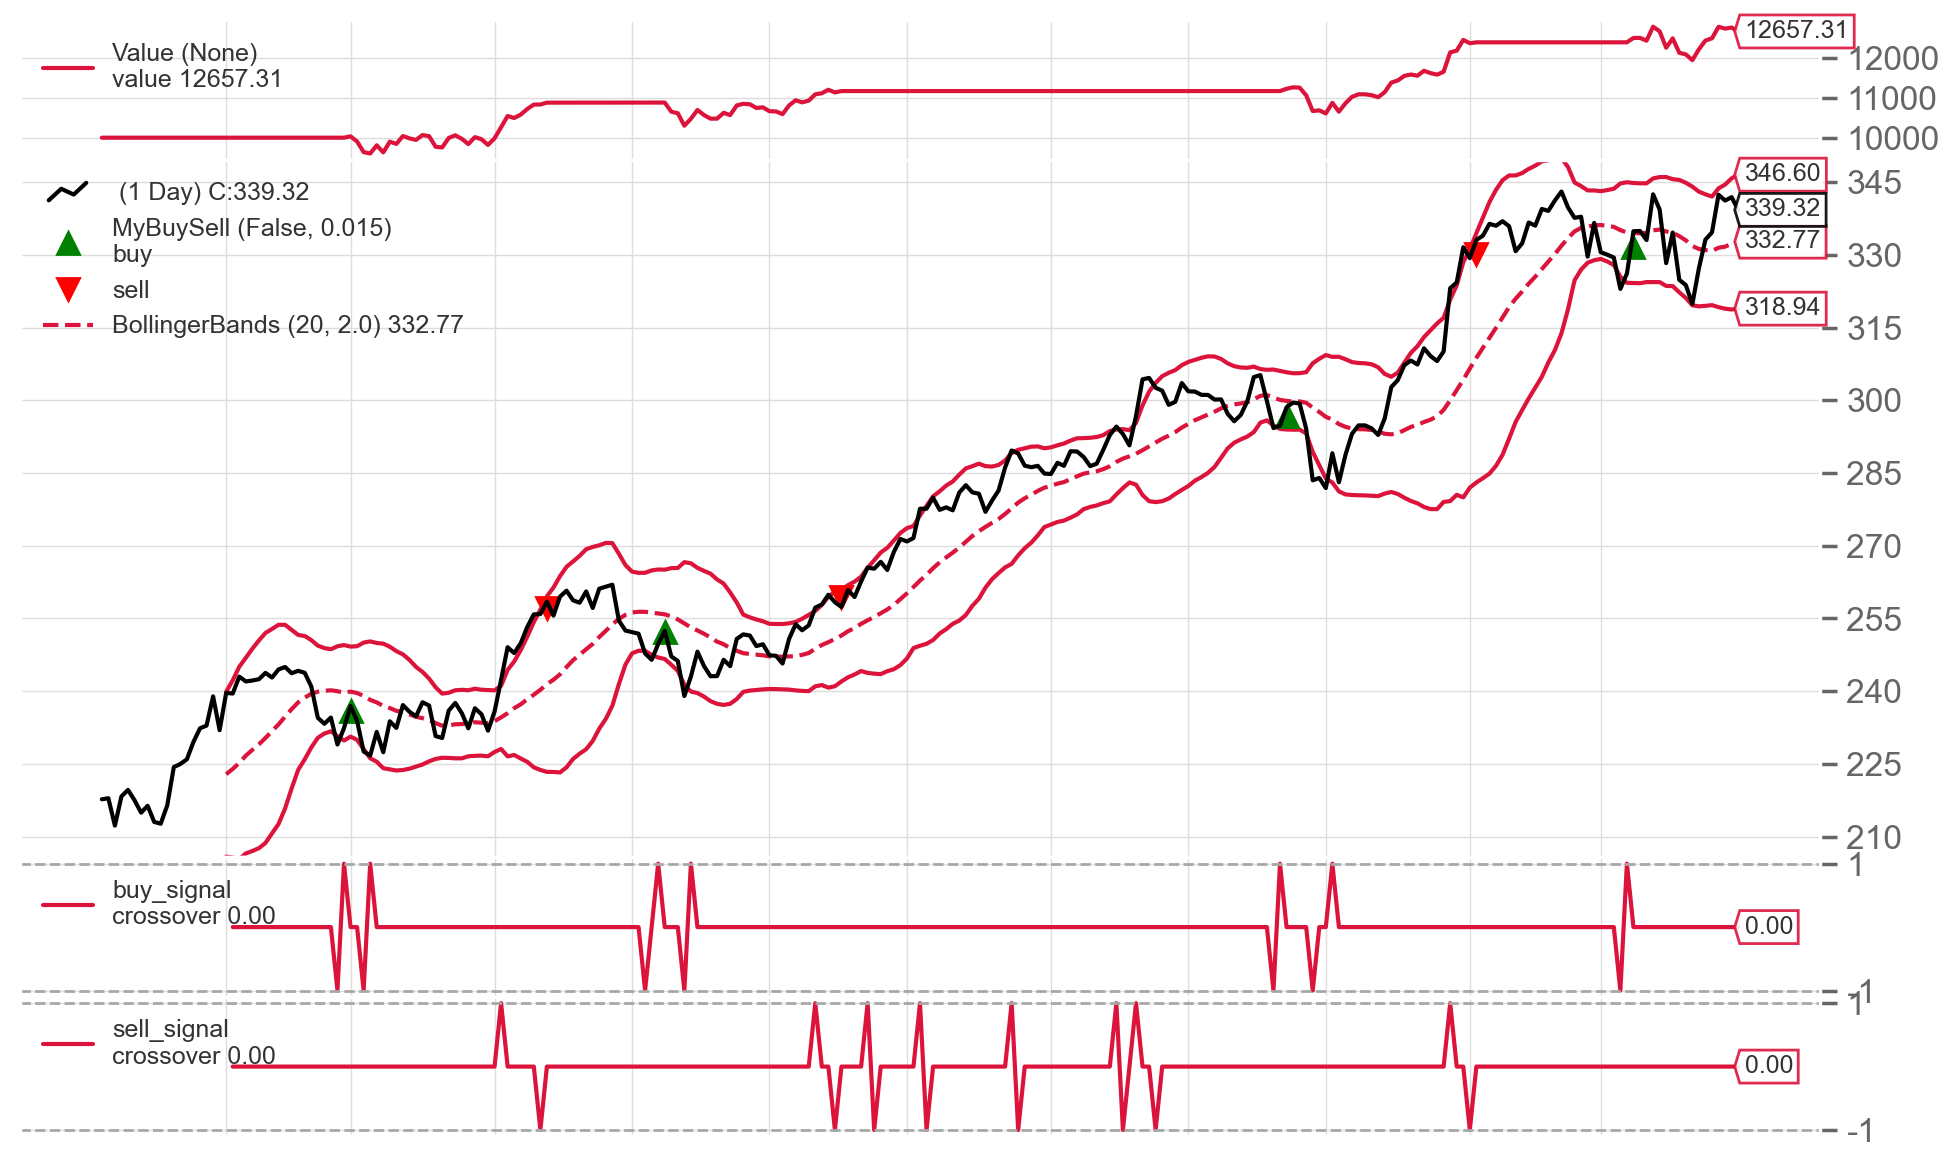

In [37]:
# from IPython.display import Image, display
import matplotlib.pyplot as plt


fig = cerebro.plot(iplot=False, volume=False)
# fig[0][0].savefig('tmp.png')  # 플롯을 'backtest_plot.png' 파일로 저장
# display(Image(filename='tmp.png'))
plt.show()

그림 12.6: 백테스트 기간 동안 전략의 행동/성과 요약
 
수수료 비용을 고려한 후에도 전략이 돈을 벌었다는 것을 알 수 있습니다. 포트폴리오 가치의 평탄한 기간은 우리가 포지션을 열지 않은 기간을 나타냅니다.

7. Investigate different returns metrics:

In [38]:
backtest_result[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 0.23564977097584391),
             ('ravg', 0.0009388437090671072),
             ('rnorm', 0.2669198183465078),
             ('rnorm100', 26.69198183465078)])

8. Extract daily portfolio returns and plot them:

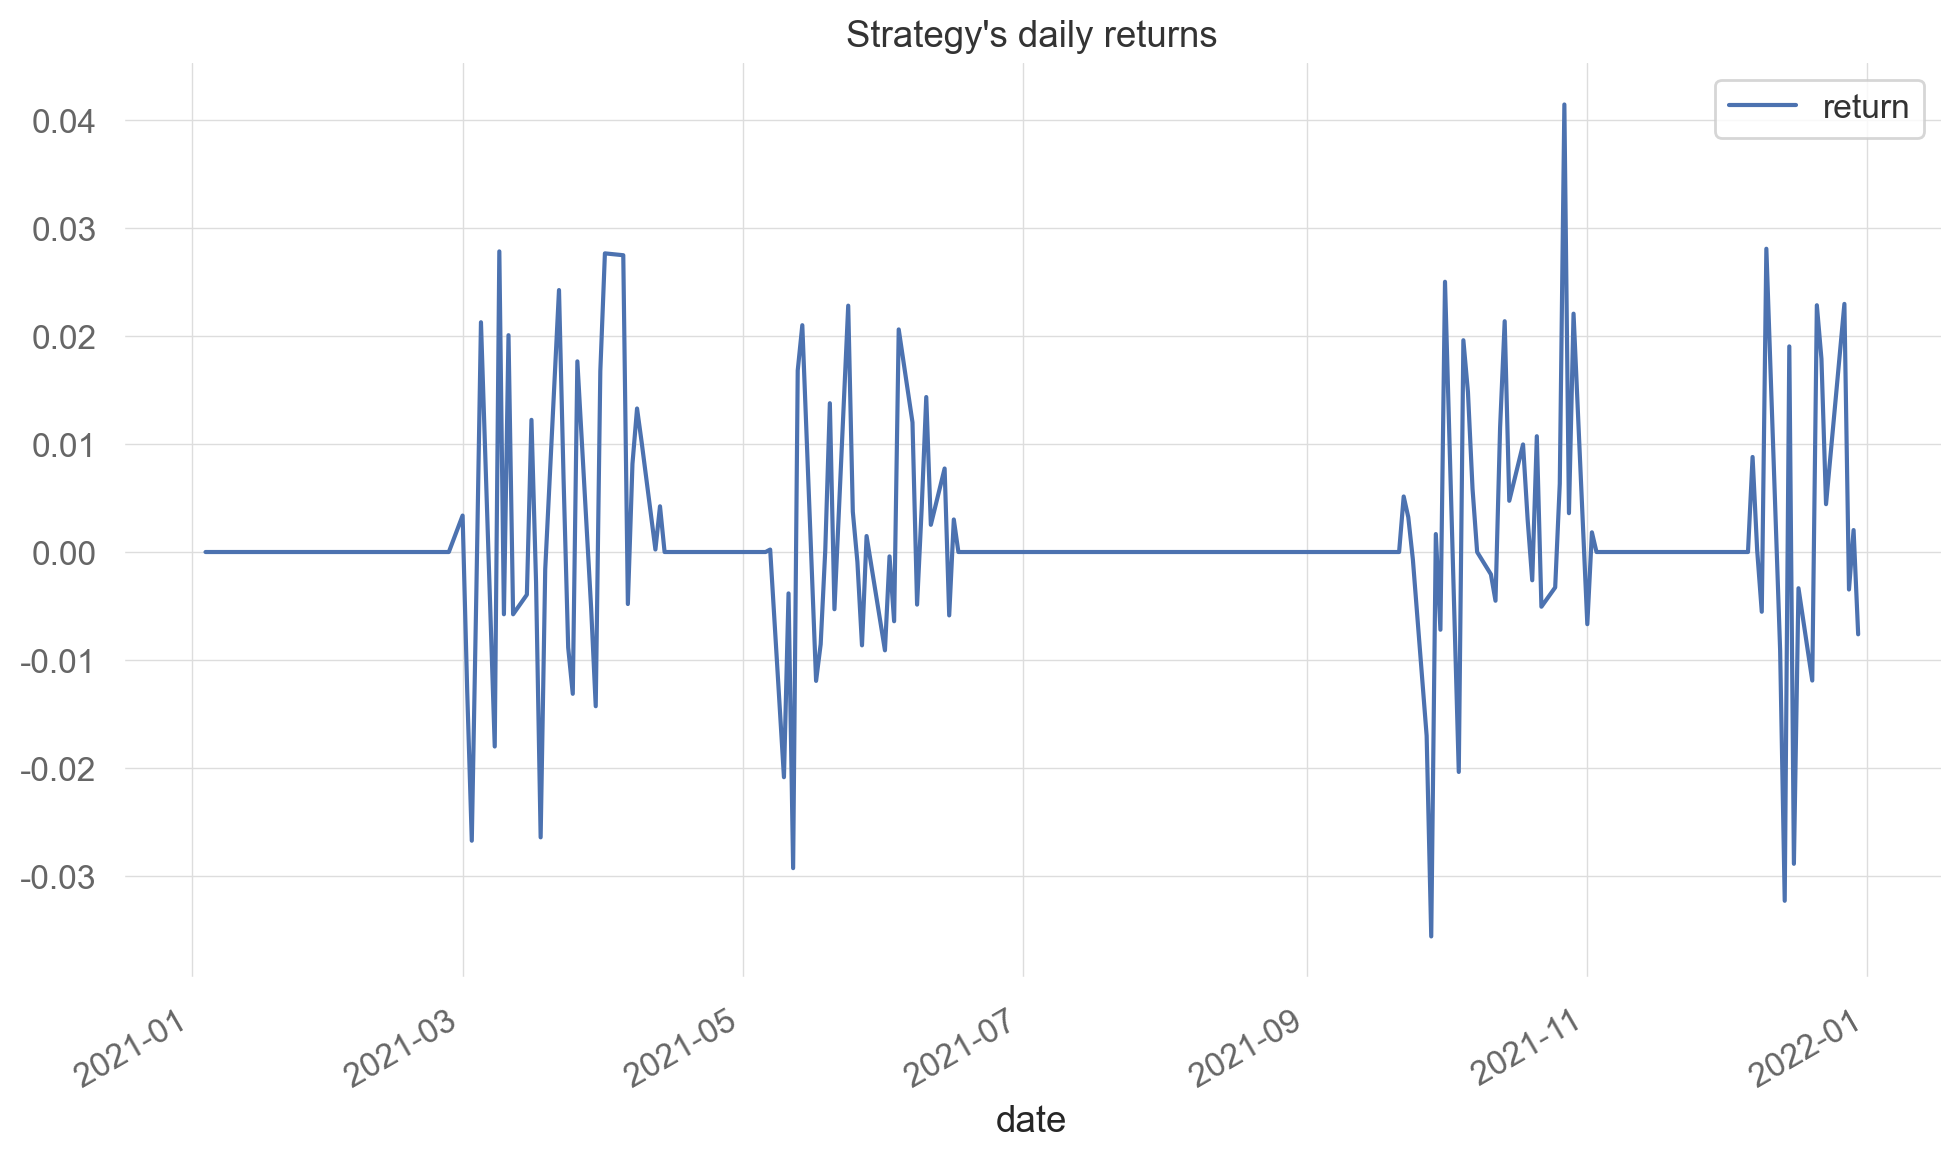

In [39]:
# 백테스트 결과에서 일별 수익률 데이터를 추출
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()

# 딕셔너리 형태의 데이터를 데이터프레임으로 변환
# - date와 return 컬럼을 가진 데이터프레임 생성
# - date를 인덱스로 설정
returns_df = (
    pd.DataFrame(list(returns_dict.items()), 
                 columns = ["date", "return"])
    .set_index("date")
)

# 일별 수익률 그래프 생성
returns_df.plot(title="Strategy's daily returns")

# 그래프 스타일 조정
# - 불필요한 테두리 제거 
sns.despine()
# - 그래프 여백 자동 조정
plt.tight_layout()

# 그래프 표시
# plt.savefig("tmp.png", dpi=200)  # 그래프 저장 시 사용
# display(Image(filename='tmp.png'))  # 저장된 이미지 표시 시 사용
plt.show()

그림 12.7: 볼린저 밴드를 기반으로 한 전략의 일일 포트폴리오 수익률
 
그림 12.7에서 포트폴리오 수익률의 평탄한 기간은 그림 12.6에서 볼 수 있듯이 우리가 포지션을 열지 않은 기간에 해당합니다.


### There's more

우리는 이미 백테스트에서 일일 수익률을 추출하는 방법을 보았습니다. 이를 통해 이 정보를 quantstats 라이브러리의 기능과 결합할 수 있는 좋은 기회를 얻게 됩니다. 다음 코드 조각을 사용하여 포트폴리오 성과를 세부적으로 평가하기 위한 다양한 지표를 계산할 수 있습니다. 추가적으로, 우리의 전략 성과를 간단한 매수 후 보유 전략과 비교해 봅니다(간단히 하기 위해 거래 비용은 포함하지 않습니다).

Compare the performance of our strategy to a "buy-and-hold" strategy:

In [40]:
import quantstats as qs
# qs.reports.metrics(returns_df, 
#                    benchmark="MSFT", 
#                    mode="basic")

# 'return' 컬럼을 가진 단일 시리즈로 변환
returns_series = returns_df['return']  # returns_df가 'return'이라는 컬럼을 가지고 있다고 가정

# 보고서 생성
qs.reports.metrics(
    returns_series, 
    benchmark="MSFT",  # 벤치마크 티커 확인
    mode="basic"
)

[*********************100%***********************]  1 of 1 completed

                    Benchmark (MSFT)    Strategy
------------------  ------------------  ----------
Start Period        2021-01-04          2021-01-04
End Period          2021-12-30          2021-12-30
Risk-Free Rate      0.0%                0.0%
Time in Market      85.0%               42.0%

Cumulative Return   46.02%              26.57%
CAGR﹪              30.34%              17.93%

Sharpe              2.12                1.64
Prob. Sharpe Ratio  98.27%              95.05%
Sortino             3.4                 2.66
Sortino/√2          2.4                 1.88
Omega               1.52                1.52

Max Drawdown        -8.77%              -6.55%
Longest DD Days     52                  99

Gain/Pain Ratio     0.46                0.52
Gain/Pain (1M)      5.15                3.82

Payoff Ratio        1.36                1.25
Profit Factor       1.46                1.52
Common Sense Ratio  1.81                2.59
CPC Index           1.04                1.04
Tail Ratio          1.

이 백테스트 결과는 Microsoft 주식에 대한 벤치마크와 전략을 비교한 통계 지표를 보여준다. 주요 지표 분석은 다음과 같다:

1. **수익률 (Cumulative Return)**  
   - 벤치마크는 46.02%의 누적 수익률을 기록해 높은 성과를 보인다.
   - 전략의 누적 수익률은 26.57%로 벤치마크보다는 낮지만 안정적인 수익을 제공한다.

2. **연평균 성장률 (CAGR)**  
   - 벤치마크의 CAGR은 30.34%이며, 전략은 17.93%로 벤치마크 대비 낮은 성장을 보인다.

3. **Sharpe 및 Sortino Ratio**  
   - 벤치마크의 Sharpe Ratio는 2.12, 전략은 1.64로 벤치마크의 위험 조정 수익률이 더 높다.
   - 벤치마크의 Sortino Ratio는 3.4, 전략은 2.66으로 하방 위험 조정 수익률 또한 벤치마크가 우수하다.

4. **최대 낙폭 (Max Drawdown)**  
   - 벤치마크의 최대 낙폭은 -8.77%이며, 전략은 -6.55%로 더 낮아 변동성이 상대적으로 적다.
   - 회복 기간에서는 전략이 99일로 벤치마크의 52일보다 길다.

5. **리스크 및 성과 지표**  
   - Gain/Pain Ratio와 Profit Factor에서 전략이 약간 우위를 보인다.
   - Common Sense Ratio와 Tail Ratio에서도 전략이 벤치마크보다 높은 값을 보여 리스크 관리 측면에서 전략이 우수하다.

6. **평균 낙폭 및 회복력**  
   - 평균 낙폭은 벤치마크와 전략이 유사하다.
   - Recovery Factor에서는 벤치마크가 더 높은 회복력을 보이며, Serenity Index는 전략이 더 높은 안정성을 나타낸다.

7. **기간별 성과**  
   - 연간 수익률(YTD)은 벤치마크가 46.02%, 전략이 26.57%로, 벤치마크가 전반적으로 높은 수익률을 기록한다.
   - 단기 수익률(3M, 6M)은 전략이 벤치마크와 유사하나, 장기적으로 벤치마크가 더 우수하다.

**종합 분석**  
벤치마크는 수익성과 회복력 면에서 우수한 성과를 보이며, 높은 위험 조정 수익률을 제공한다. 반면 전략은 낮은 변동성과 안정성을 목표로 하며, 변동성을 줄이고 리스크 관리를 중시하는 투자자에게 적합하지만, 장기 성과에서는 벤치마크가 더 유리하다.


>11장, 자산 배분에서, quantstats의 대안 라이브러리로 pyfolio를 언급했습니다. 후자는 더 이상 활발히 유지 관리되지 않는다는 잠재적인 단점이 있습니다. 그러나 pyfolio는 backtrader와 잘 통합되어 있습니다. bt.analyzers.PyFolio라는 전용 분석기를 쉽게 추가할 수 있습니다. 구현 예시는 책의 GitHub 저장소를 참조하시기 바랍니다.

## 12.5 Backtesting a moving average crossover strategy using crypto data

**암호화폐 데이터를 이용한 이동 평균 크로스오버 전략 백테스팅**

지금까지 우리는 주식에 대한 몇 가지 전략을 만들고 백테스팅해왔습니다. 이번 예제에서는 또 다른 인기 자산 클래스인 암호화폐를 다룹니다. 암호화폐 데이터를 처리하는 데 몇 가지 주요 차이점이 있습니다:

- 암호화폐는 24시간/7일 거래가 가능합니다.
- 암호화폐는 분할 단위로 거래할 수 있습니다.

백테스트가 실제 거래와 유사하도록 하려면 이러한 암호화폐의 특성을 고려해야 합니다. 다행히 *backtrader* 프레임워크는 매우 유연하여, 기존의 접근 방식을 약간 조정해 이 새로운 자산 클래스를 처리할 수 있습니다.

일부 브로커는 주식도 분할 단위로 구매할 수 있게 합니다.

이번 예제에서는 다음 규칙에 따라 이동 평균 크로스오버 전략을 백테스팅합니다:

- 비트코인에만 관심을 두고 2021년 일일 데이터를 사용합니다.
- 20일(빠른 평균)과 50일(느린 평균) 이동 평균 두 개를 사용합니다.
- 빠른 이동 평균이 느린 이동 평균을 상향 돌파하면, 보유 현금의 70%를 비트코인 구매에 할당합니다.
- 빠른 이동 평균이 느린 이동 평균을 하향 돌파하면, 보유한 모든 비트코인을 매도합니다.
- 공매도는 허용되지 않습니다.

### How to do it...

1. Import the libraries:

In [4]:
import backtrader as bt
import datetime
import pandas as pd
from backtrader_strategies.strategy_utils import *

2. Define the commission scheme allowing for fractional trades:

라이브러리를 가져온 후, 분할 주식을 허용하기 위해 사용자 지정 수수료 체계를 정의합니다. 이전에는 사용자 지정 수수료 체계를 만들 때 *bt.CommInfoBase*를 상속받아 *getcommission* 메서드를 수정했습니다. 이번에는 *bt.CommissionInfo*를 상속받아 *getsize* 메서드를 수정하여 사용 가능한 현금과 자산의 가격에 따라 분할 값을 반환하도록 합니다.

In [5]:
class FractionalTradesCommission(bt.CommissionInfo):
    def getsize(self, price, cash):
        """
        분할 거래 크기를 계산하여 반환합니다.
        
        Parameters:
            price (float): 자산의 현재 가격
            cash (float): 사용 가능한 현금 잔고
            
        Returns:
            float: 구매 가능한 분할 수량. 레버리지를 고려하여 계산됩니다.
            
        예시:
            price가 100이고 cash가 150일 때, 레버리지가 1이면
            150/100 = 1.5 단위를 구매할 수 있습니다.
        """
        return self.p.leverage * (cash / price)

3. Define the SMA crossover strategy:

3단계(및 하위 단계)에서는 이동 평균 크로스오버 전략을 정의합니다. 이 예제에서는 코드 대부분이 이미 익숙하게 보일 것입니다. 새롭게 적용한 점은 *order_target_percent*라는 주문 유형을 사용하는 것입니다. 이 유형을 사용하면 주어진 자산이 포트폴리오의 특정 %를 차지하도록 설정할 수 있습니다.

이 방법은 매우 편리한데, 정확한 주문 크기 계산을 *backtrader*가 처리하기 때문입니다. 주문을 발행할 때 우리가 목표로 한 퍼센트보다 낮으면 해당 자산을 더 매수하고, 목표보다 높으면 일부를 매도합니다.

포지션을 종료할 때는 포트폴리오 내 BTC 비율을 0%로 설정하여 모든 자산을 매도하도록 지시합니다. *order_target_percent*에 0을 목표로 지정하면 현재 보유 수량을 추적하거나 접근할 필요가 없습니다.

In [6]:
class SMACrossoverStrategy(bt.Strategy):
    # 전략 파라미터 정의
    params = (
        ("ma_fast", 20),    # 단기 이동평균선 기간
        ("ma_slow", 50),    # 장기 이동평균선 기간 
        ("target_perc", 0.7) # 포트폴리오에서 차지할 목표 비중
    )

    def __init__(self):
        # 종가 데이터 저장
        self.data_close = self.datas[0].close
        
        # 미체결 주문 추적을 위한 변수
        self.order = None

        # 이동평균선 계산 및 크로스오버 시그널 생성
        self.fast_ma = bt.indicators.MovingAverageSimple(
            self.datas[0], 
            period=self.params.ma_fast  # 단기 이동평균선
        )
        self.slow_ma = bt.indicators.MovingAverageSimple(
            self.datas[0], 
            period=self.params.ma_slow  # 장기 이동평균선
        )
        # 단기선이 장기선을 상향돌파하면 1, 하향돌파하면 -1
        self.ma_crossover = bt.indicators.CrossOver(self.fast_ma, 
                                                    self.slow_ma)
        
    def log(self, txt):
        # 로그 출력 함수: 날짜와 메시지 출력
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        # 주문 상태 변경 시 호출되는 함수
        if order.status in [order.Submitted, order.Accepted]:
            # 주문이 제출되거나 수락된 상태면 아무 작업 안함
            return

        if order.status in [order.Completed]:
            # 주문 체결 시 로그 출력
            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            # 주문 실패 시 로그 출력
            self.log("Order Failed")

        # 주문 처리 완료 후 order 변수 초기화
        self.order = None

    def notify_trade(self, trade):
        # 거래 종료 시 손익 출력
        if not trade.isclosed:
            return

        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):
        # 매 봉마다 호출되는 핵심 전략 로직

        if self.order:
            return  # 미체결 주문이 있으면 대기

        if not self.position:  # 포지션이 없을 때
            if self.ma_crossover > 0:  # 골든크로스 발생
                # 목표 비중만큼 매수 주문
                self.order = self.order_target_percent(
                    target=self.params.target_perc
                )
                log_str = get_action_log_string("b", "c", 
                                                price=self.data_close[0], 
                                                size=self.order.size,
                                                cash=self.broker.getcash(),
                                                open=self.data_open[0],
                                                close=self.data_close[0])
                self.log(log_str)

        else:  # 포지션이 있을 때
            if self.ma_crossover < 0:  # 데드크로스 발생
                # 전량 매도 주문
                log_str = get_action_log_string("s", "c", self.data_close[0], 
                                                self.position.size)
                self.log(log_str)
                self.order = (
                    self.order_target_percent(target=0)  # 목표 비중 0%로 설정
                )

    def start(self):
        # 백테스트 시작 시 초기 포트폴리오 가치 출력
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        # 백테스트 종료 시 최종 포트폴리오 가치 출력
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")


4. Download the `BTC-USD` data:

4단계에서는 2021년 일일 BTC 가격(USD 기준)을 다운로드합니다.

In [7]:
# data = bt.feeds.YahooFinanceData(
#     dataname="BTC-USD",
#     fromdate=datetime.datetime(2020, 1, 1),
#     todate=datetime.datetime(2021, 12, 31)
# )

# yfinance를 사용하여 BTC-USD 데이터 다운로드
import yfinance as yf

# BTC-USD 데이터 다운로드 
data = yf.download("BTC-USD", 
                   start="2020-01-01", 
                   end="2021-12-31")

# 데이터를 backtrader가 이해할 수 있는 형식으로 변환
data_feed = bt.feeds.PandasData(dataname=data)

[*********************100%***********************]  1 of 1 completed


5. Set up the backtest:

이후 단계에서는 백테스트를 설정하고 실행하며 결과를 플로팅합니다. 유의할 점은 *addcommissioninfo* 메서드를 사용해 분할 주식 논리를 포함한 사용자 지정 수수료 체계를 추가해야 한다는 것입니다.

In [8]:
# Cerebro 엔진 초기화 
# stdstats=False: 기본 통계 비활성화
# cheat_on_open=False: 당일 시가에 거래하지 않음
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=False)

# 백테스팅할 전략 추가
cerebro.addstrategy(SMACrossoverStrategy)

# 데이터피드 추가 
cerebro.adddata(data_feed)

# 초기 현금 설정 (10,000 달러)
cerebro.broker.setcash(10000.0)

# 거래 수수료 설정 (0.1%)
cerebro.broker.addcommissioninfo(
    FractionalTradesCommission(commission=0.001)
)

# 매수/매도 시그널 관찰자 추가
cerebro.addobserver(MyBuySell)

# 포트폴리오 가치 관찰자 추가
cerebro.addobserver(bt.observers.Value)

# 수익률 분석기 추가
cerebro.addanalyzer(
    bt.analyzers.TimeReturn, _name="time_return"
)

6. Run the backtest:

In [9]:
backtest_result = cerebro.run()

Initial Portfolio Value: 10000.00
2020-04-19: BUY CREATED - Price: 7189.42, Size: 0.97, Cash: 10000.00, Open: 7260.92, Close: 7189.42
2020-04-20: BUY EXECUTED - Price: 7186.87, Size: 0.97, Cost: 6997.52, Commission: 7.00
2020-06-29: SELL CREATED - Price: 9190.85, Size: 0.97
2020-06-30: SELL EXECUTED - Price: 9185.58, Size: -0.97, Cost: 6997.52, Commission: 8.94
2020-06-30: OPERATION RESULT - Gross: 1946.05, Net: 1930.11
2020-07-27: BUY CREATED - Price: 10990.87, Size: 0.76, Cash: 11930.11, Open: 9905.22, Close: 10990.87
2020-07-28: BUY EXECUTED - Price: 11017.46, Size: 0.76, Cost: 8371.28, Commission: 8.37
2020-09-09: SELL CREATED - Price: 10242.35, Size: 0.76
2020-09-10: SELL EXECUTED - Price: 10242.33, Size: -0.76, Cost: 8371.28, Commission: 7.78
2020-09-10: OPERATION RESULT - Gross: -588.96, Net: -605.11
2020-10-13: BUY CREATED - Price: 11425.90, Size: 0.69, Cash: 11324.99, Open: 11548.72, Close: 11425.90
2020-10-14: BUY EXECUTED - Price: 11429.05, Size: 0.69, Cost: 7929.68, Commiss

7. Plot the results:

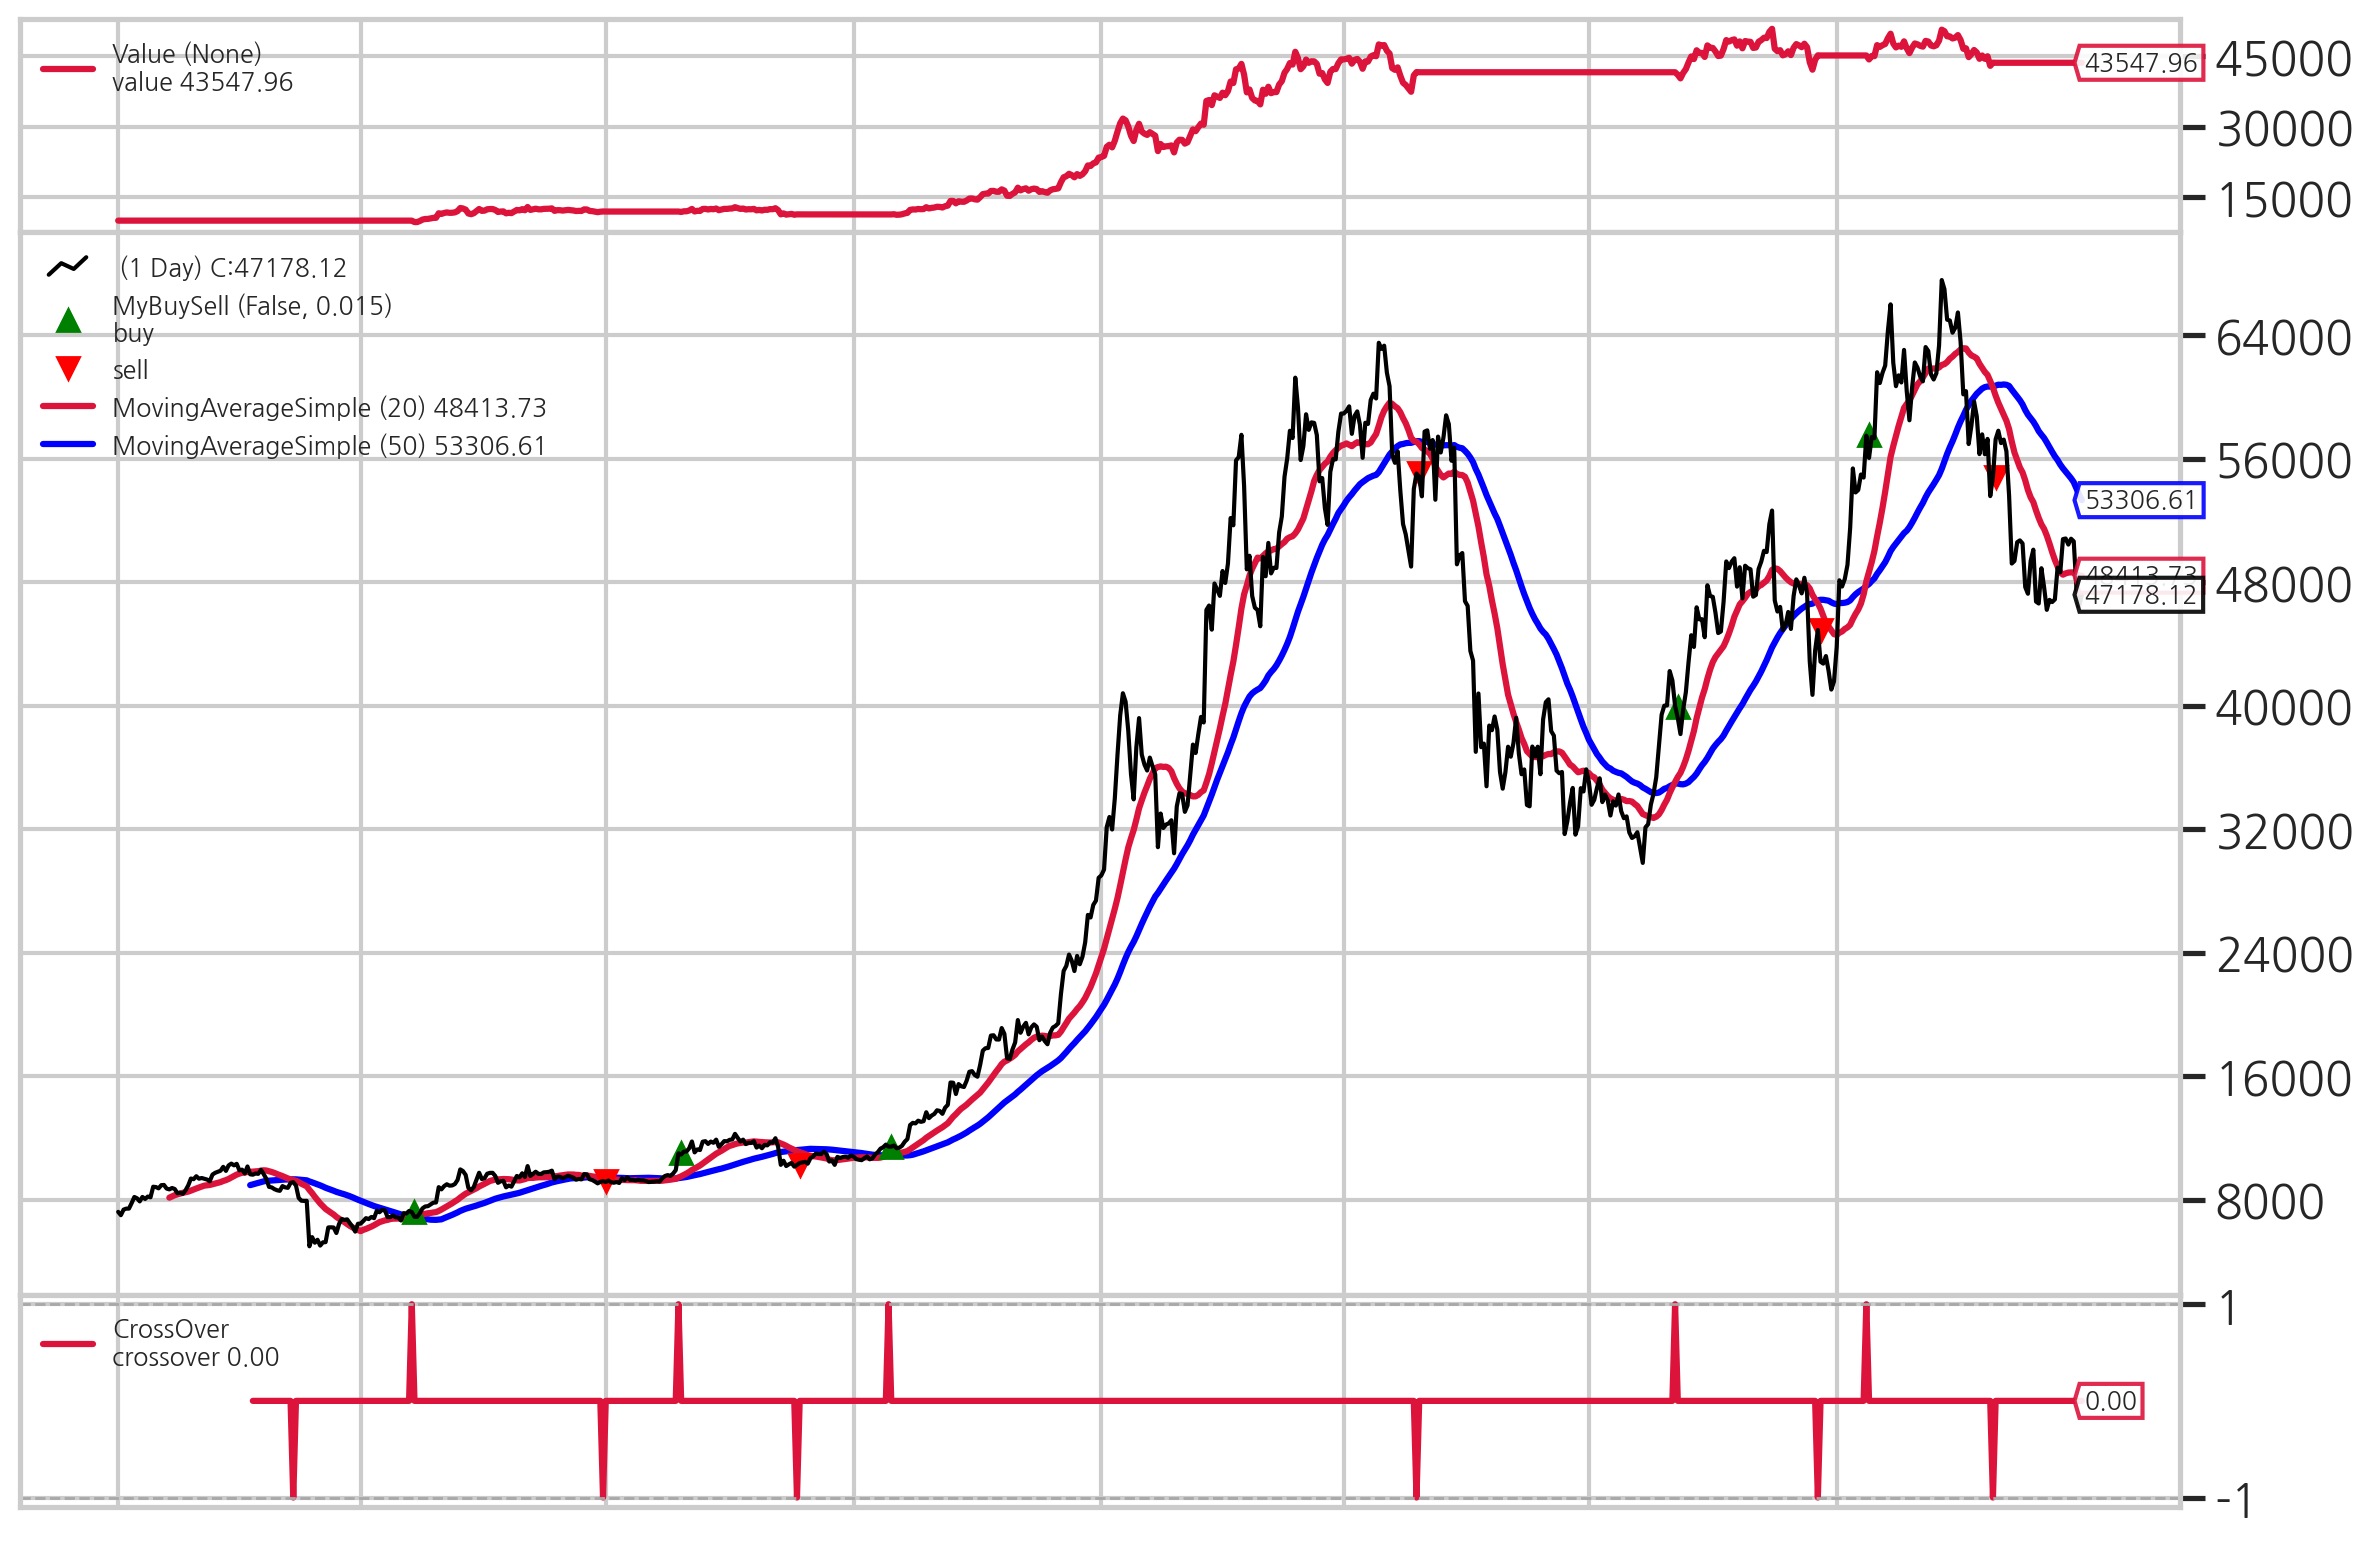

In [10]:
# cerebro.plot(iplot=True, volume=False)

fig = cerebro.plot(iplot=False, volume=False)
plt.show()

그림 12.8: 백테스트 기간 동안의 전략 행동/성과 요약
 
우리는 이미 우리의 전략을 사용하여 300% 이상의 수익률을 달성했다는 것을 확인했습니다. 하지만 그림 12.8에서 볼 수 있듯이, 이러한 뛰어난 성과는 단순히 해당 기간 동안 BTC 가격이 엄청나게 상승했기 때문일 수 있습니다. 이전 레시피에서 사용한 코드와 동일한 코드를 사용하여 우리의 전략과 단순 매수 후 보유 전략의 성과를 비교할 수 있습니다. 이를 통해 우리의 능동적 전략이 정적 벤치마크와 비교하여 어떤 성과를 보였는지 확인할 수 있습니다. 

매수 후 보유 전략과 비교한 전략의 성과 확인:

In [12]:
import quantstats as qs

# get the returns of the strategy as a DataFrame
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                          columns = ["date", "return"]) \
               .set_index("date")

returns_series = returns_df['return']  # returns_df가 'return'이라는 컬럼을 가지고 있다고 가정


# calculate the perf as compared to buy-and-hold
qs.reports.metrics(returns_series, 
                   benchmark="BTC-USD", 
                   mode="basic")

[*********************100%***********************]  1 of 1 completed


                    Benchmark (BTC-USD)    Strategy
------------------  ---------------------  ----------
Start Period        2020-01-01             2020-01-01
End Period          2021-12-30             2021-12-30
Risk-Free Rate      0.0%                   0.0%
Time in Market      85.0%                  57.0%

Cumulative Return   556.22%                335.48%
CAGR﹪              91.62%                 66.29%

Sharpe              1.46                   1.6
Prob. Sharpe Ratio  99.38%                 99.75%
Sortino             2.26                   2.63
Sortino/√2          1.6                    1.86
Omega               1.46                   1.46

Max Drawdown        -53.06%                -22.69%
Longest DD Days     188                    151

Gain/Pain Ratio     0.32                   0.46
Gain/Pain (1M)      2.95                   6.45

Payoff Ratio        1.18                   1.19
Profit Factor       1.32                   1.46
Common Sense Ratio  1.62                   1.95
CPC I

이 백테스트 결과는 비트코인(BTC-USD)에 대한 벤치마크와 전략을 비교한 성과 지표를 보여줍니다. 주요 지표 분석은 다음과 같습니다:

1. **수익률 (Cumulative Return)**
   - 벤치마크의 누적 수익률은 556.22%로 매우 높은 수익을 보여줍니다.
   - 전략의 누적 수익률은 335.48%로 벤치마크보다는 낮지만, 여전히 상당한 수익률을 기록합니다.

2. **연평균 성장률 (CAGR)**
   - 벤치마크의 연평균 성장률은 91.62%이며, 전략은 66.29%로 벤치마크 대비 낮은 성장을 보입니다.

3. **Sharpe 및 Sortino Ratio**
   - 벤치마크의 Sharpe Ratio는 1.46, 전략은 1.6으로, 전략이 벤치마크보다 약간 더 높은 위험 조정 수익률을 제공합니다.
   - 벤치마크의 Sortino Ratio는 2.26, 전략은 2.63으로, 하방 위험을 고려한 수익률도 전략이 더 우수합니다.

4. **최대 낙폭 (Max Drawdown)**
   - 벤치마크는 -53.06%의 큰 최대 낙폭을 기록해 큰 변동성을 보입니다.
   - 전략의 최대 낙폭은 -22.69%로 벤치마크보다 훨씬 낮아, 안정적인 모습을 보입니다.
   - 회복 기간에서도 전략은 151일로 벤치마크의 188일보다 짧아 상대적으로 빠른 회복력을 보입니다.

5. **리스크 및 성과 지표**
   - Gain/Pain Ratio에서 전략이 0.46으로 벤치마크의 0.32보다 높은 수익 대비 위험 비율을 보입니다.
   - Profit Factor와 Common Sense Ratio에서도 전략이 우수한 수익성을 보이며, 리스크 관리 측면에서도 더 나은 성과를 보입니다.

6. **평균 낙폭 및 회복력**
   - 평균 낙폭은 전략이 -6.1%로 벤치마크의 -8.12%보다 낮습니다.
   - Recovery Factor에서 전략이 7.29로 벤치마크의 4.36보다 우수하며, Ulcer Index도 낮아 전략이 더 안정적인 성과를 제공합니다.
   - Serenity Index는 전략이 2.79로 벤치마크의 1.18보다 높아 장기적인 안정성에서도 전략이 유리합니다.

7. **기간별 성과**
   - 연간 수익률(YTD)은 전략이 85.24%, 벤치마크가 62.67%로, 연간 수익에서는 전략이 벤치마크보다 높은 성과를 보입니다.
   - 장기적으로 벤치마크는 높은 성장률을 보이지만, 전략은 변동성을 줄이면서도 안정적인 수익을 제공합니다.

**종합 분석**
벤치마크는 높은 누적 수익률과 연평균 성장률을 통해 장기적인 투자 관점에서 매우 높은 성과를 보입니다. 그러나 큰 낙폭과 변동성으로 인해 위험이 높습니다. 반면, 전략은 상대적으로 낮은 수익률을 보이지만, 변동성과 최대 낙폭이 줄어들어 안정성이 더 큽니다. 이는 높은 수익률을 기대하기보다는 안정성을 중시하는 투자자에게 적합한 전략으로 평가됩니다.

### There's more

이 예제에서는 타겟 주문(target order)을 소개합니다. *backtrader*는 세 가지 유형의 타겟 주문을 제공합니다:

- **order_target_percent**: 포트폴리오 가치의 몇 퍼센트를 특정 자산에 할당할지 나타냅니다.
- **order_target_size**: 포트폴리오에서 특정 자산을 몇 단위로 보유할지 목표를 설정합니다.
- **order_target_value**: 포트폴리오에서 특정 자산에 투자할 금액을 설정합니다.

타겟 주문은 자산의 목표 퍼센트/가치/단위가 있을 때 유용하며, 목표에 도달하기 위해 추가로 매수 또는 매도할 필요가 있는지 계산하는 시간을 절약할 수 있습니다.

또한 분할 주식에 관한 중요한 사항이 있습니다. 이 예제에서는 분할 주식을 고려한 사용자 지정 수수료 체계를 정의하고 타겟 주문을 사용하여 매수/매도를 실행합니다. 이렇게 하면 엔진이 목표를 달성하기 위해 거래할 단위를 계산할 때 분할 값을 사용할 수 있음을 인식합니다.

그러나 사용자 지정 수수료 체계를 정의하지 않고 분할 주식을 사용할 다른 방법도 있습니다. 매수/매도를 원하는 주식 수를 수동으로 계산하고 정수로 반올림하여 주문을 생성하는 것입니다. 이와 유사한 접근법을 이전 예제에서도 사용하며, SMA 크로스오버 전략의 수동 분할 주문 크기 계산에 대한 구현 예시는 책의 GitHub 저장소를 참고하시기 바랍니다.

1. Define the same strategy, this time, manually calculating the amount of BTC to buy:

In [14]:
class SMACrossoverStrategyAlt(bt.Strategy):
    # 전략의 파라미터 정의
    params = (
        ("ma_fast", 20),    # 단기 이동평균선 기간
        ("ma_slow", 50),    # 장기 이동평균선 기간 
        ("target_perc", 0.7) # 포트폴리오 중 투자 비중
    )

    def __init__(self):
        # 종가 데이터 추적
        self.data_close = self.datas[0].close
        
        # 미체결 주문 추적
        self.order = None

        # 이동평균선 계산 및 크로스오버 시그널 생성
        self.fast_ma = bt.indicators.MovingAverageSimple(self.datas[0], 
                       period=self.params.ma_fast)  # 단기 이동평균
        self.slow_ma = bt.indicators.MovingAverageSimple(self.datas[0], 
                       period=self.params.ma_slow)  # 장기 이동평균
        self.ma_crossover = bt.indicators.CrossOver(self.fast_ma, 
                                                    self.slow_ma)  # 골든/데드 크로스 시그널
        
    def log(self, txt):
        # 로그 출력 함수 - 날짜와 텍스트 기록
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        # 주문 상태 변경 시 호출되는 함수
        if order.status in [order.Submitted, order.Accepted]:
            # 주문 제출/수락 상태면 아무 작업 안함
            return

        # 주문 체결 시
        if order.status in [order.Completed]:
            direction = "b" if order.isbuy() else "s"  # 매수/매도 구분
            log_str = get_action_log_string(
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        # 주문 실패 시
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log("Order Failed")

        # 주문 객체 초기화
        self.order = None

    def notify_trade(self, trade):
        # 거래 종료 시 손익 계산
        if not trade.isclosed:
            return

        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):
        # 매 봉마다 실행되는 메인 로직
        if self.order:
            return  # 미체결 주문이 있으면 대기

        # 포지션이 없을 때
        if not self.position:
            if self.ma_crossover > 0:  # 골든크로스 발생
                # 투자금액 계산 (현금 * 목표비중 / 현재가)
                size = self.broker.getcash() / self.datas[0].close * self.params.target_perc
                log_str = get_action_log_string("b", "c", 
                                                price=self.data_close[0], 
                                                size=size,
                                                cash=self.broker.getcash(),
                                                open=self.data_open[0],
                                                close=self.data_close[0])
                self.log(log_str)
                self.order = self.buy(size=size)  # 매수 주문
        else:
            # 포지션 보유 중일 때
            if self.ma_crossover < 0:  # 데드크로스 발생
                log_str = get_action_log_string("s", "c", self.data_close[0], 
                                                self.position.size)
                self.log(log_str)
                # 전량 매도 (목표 비중 0%로 설정)
                self.order = self.order_target_percent(target=0)

    def start(self):
        # 백테스트 시작 시 초기 포트폴리오 가치 출력
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        # 백테스트 종료 시 최종 포트폴리오 가치 출력
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")


2. Set up the backtest, this time without the fractional commission scheme:

In [15]:
# Cerebro 객체 생성 
# stdstats=False: 기본 통계 비활성화
# cheat_on_open=True: 당일 시가에 거래 실행 가능
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

# 백테스트에 사용할 전략 추가
cerebro.addstrategy(SMACrossoverStrategyAlt)

# 백테스트에 사용할 데이터 추가 
cerebro.adddata(data_feed)

# 초기 투자금액 설정 (10,000)
cerebro.broker.setcash(10000.0)

# 거래 수수료 설정 (0.1%)
cerebro.broker.setcommission(commission=0.001)

# 매수/매도 시그널을 표시할 관찰자 추가
cerebro.addobserver(MyBuySell)

# 포트폴리오 가치 변화를 표시할 관찰자 추가
cerebro.addobserver(bt.observers.Value)

3. Run the backtest:

In [16]:
backtest_result = cerebro.run()

Initial Portfolio Value: 10000.00
2020-04-19: BUY CREATED - Price: 7189.42, Size: 0.97, Cash: 10000.00, Open: 7260.92, Close: 7189.42
2020-04-20: BUY EXECUTED - Price: 7186.87, Size: 0.97, Cost: 6997.52, Commission: 7.00
2020-06-29: SELL CREATED - Price: 9190.85, Size: 0.97
2020-06-30: SELL EXECUTED - Price: 9185.58, Size: -0.97, Cost: 6997.52, Commission: 8.94
2020-06-30: OPERATION RESULT - Gross: 1946.05, Net: 1930.11
2020-07-27: BUY CREATED - Price: 10990.87, Size: 0.76, Cash: 11930.11, Open: 9905.22, Close: 10990.87
2020-07-28: BUY EXECUTED - Price: 11017.46, Size: 0.76, Cost: 8371.28, Commission: 8.37
2020-09-09: SELL CREATED - Price: 10242.35, Size: 0.76
2020-09-10: SELL EXECUTED - Price: 10242.33, Size: -0.76, Cost: 8371.28, Commission: 7.78
2020-09-10: OPERATION RESULT - Gross: -588.96, Net: -605.11
2020-10-13: BUY CREATED - Price: 11425.90, Size: 0.69, Cash: 11324.99, Open: 11548.72, Close: 11425.90
2020-10-14: BUY EXECUTED - Price: 11429.05, Size: 0.69, Cost: 7929.68, Commiss

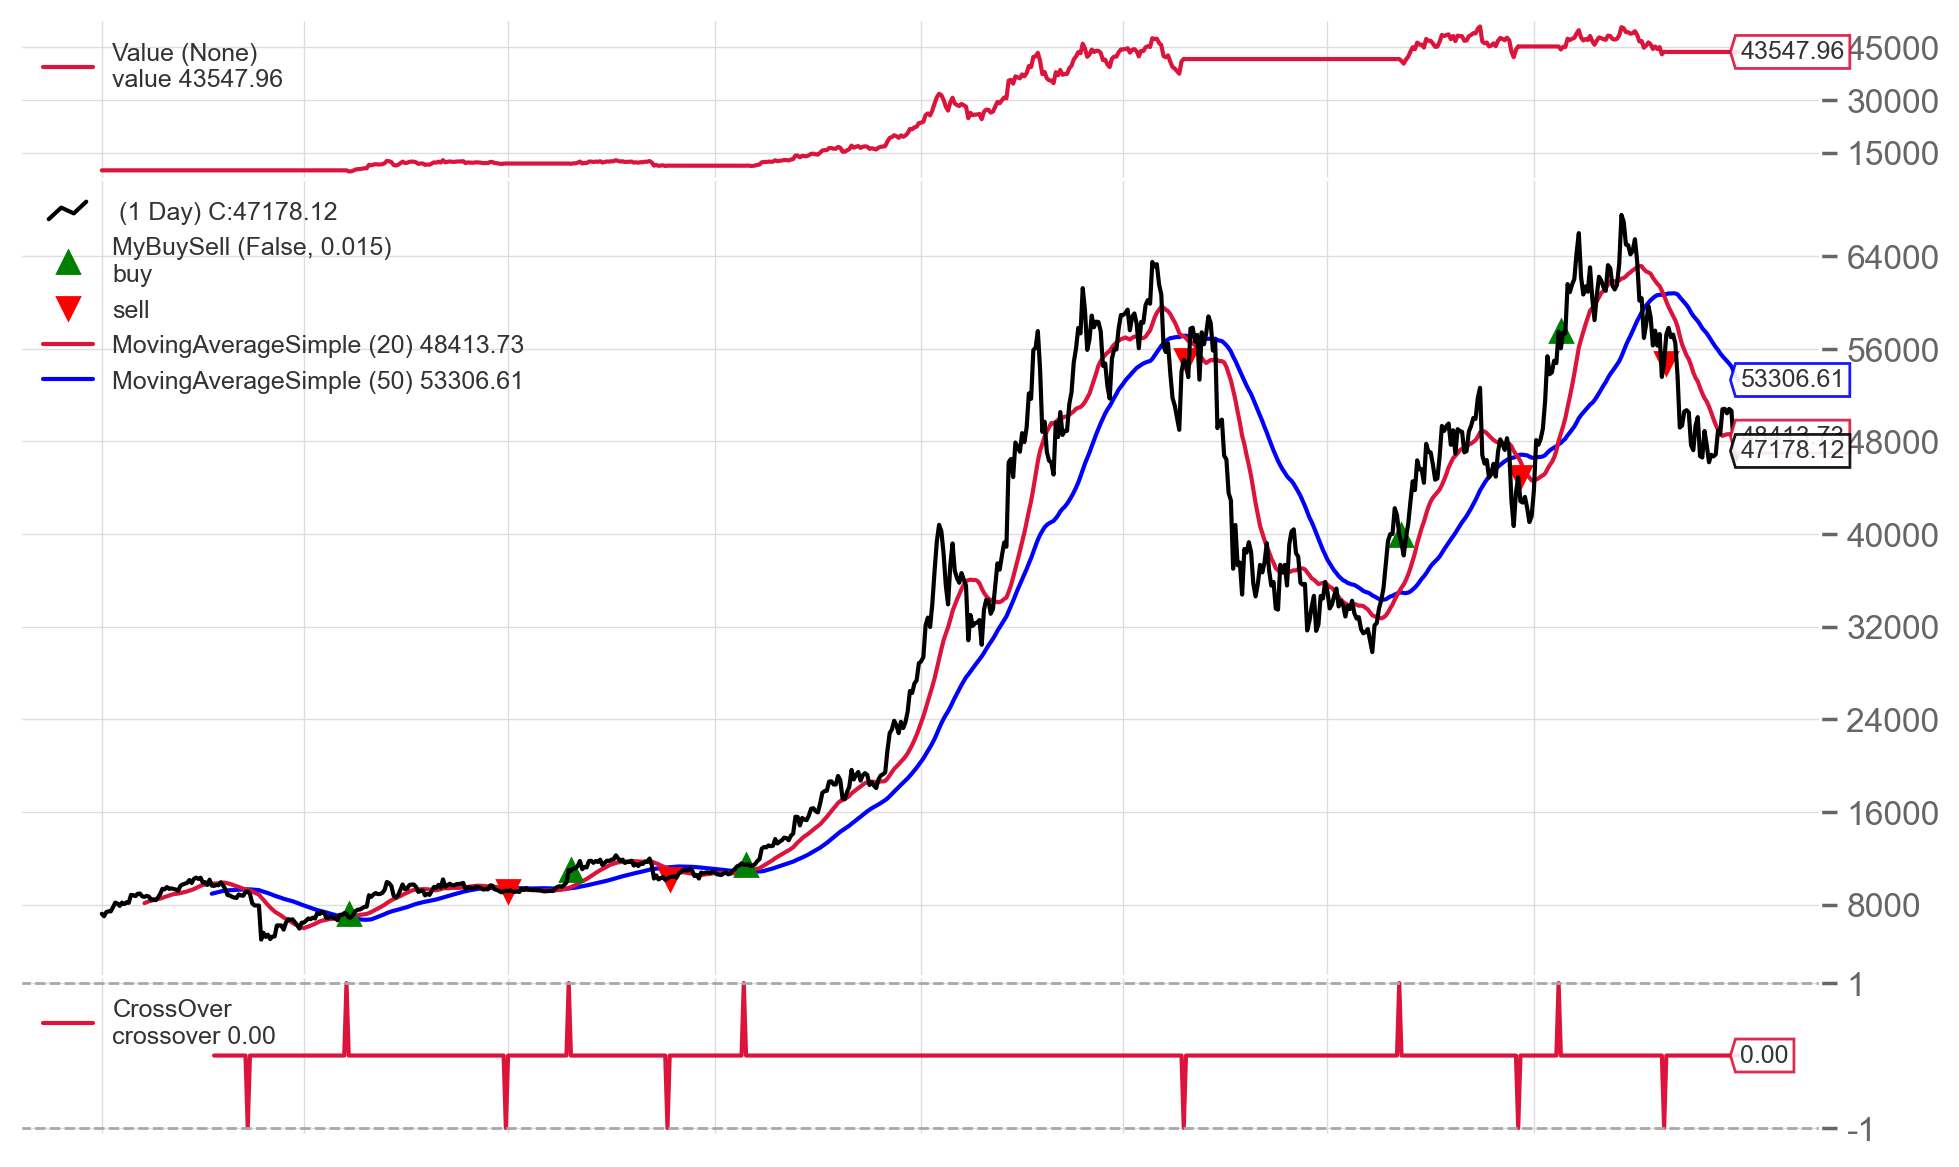

In [17]:
fig = cerebro.plot(iplot=False, volume=False)
plt.show()

## 12.6 Backtesting a mean-variance portfolio optimization

**평균-분산 포트폴리오 최적화 백테스팅**

이전 챕터에서는 자산 배분과 평균-분산 최적화에 대해 다루었습니다. 평균-분산 최적화를 백테스트와 결합하는 것은 흥미로운 연습이 될 수 있으며, 특히 여러 자산을 동시에 다루기 때문입니다.

이번 예제에서는 다음과 같은 자산 배분 전략을 백테스팅합니다:

- FAANG 주식들을 고려합니다.
- 매주 금요일 시장이 마감된 후에 샤프 비율을 최대화하는 접점 포트폴리오를 찾습니다. 그런 다음, 월요일 시장이 개장할 때 계산된 최적 가중치에 맞추기 위한 타겟 주문을 생성합니다.
- 기대 수익률과 공분산 행렬을 계산하기 위해 최소한 252개의 데이터 포인트가 필요하다고 가정합니다 (Ledoit-Wolf 방법 사용).

이 연습에서는 2020년부터 2021년까지 FAANG 주식의 가격을 다운로드합니다. 가중치를 계산하기 위해 설정한 준비 기간으로 인해 실제 거래는 2021년에만 발생합니다.

**Ledoit-Wolf 방법**
- Ledoit-Wolf 방법은 공분산 행렬을 추정할 때 사용되는 기법으로, 특히 작은 데이터 표본에서 불확실성을 줄여주는 것이 특징입니다. 기본 공분산 행렬을 추정할 때는 흔히 데이터가 부족하거나 변동성이 커서 오차가 발생하기 쉽습니다. Ledoit-Wolf 방법은 이 오차를 줄이기 위해 "shrinking"이라는 과정을 사용합니다. 이 과정에서 단순한 행렬(대각선 행렬)과의 균형을 맞춰 예측을 안정화하는데, 이를 통해 더 견고하고 신뢰성 높은 공분산 추정치를 얻을 수 있습니다.

### Getting ready

In [18]:
import backtrader as bt

class FractionalTradesCommission(bt.CommissionInfo):
    def getsize(self, price, cash):
        """Returns the fractional size"""
        return self.p.leverage * (cash / price)

### How to do it...

1. Import the libraries:

In [19]:
# 날짜/시간 처리를 위한 datetime 모듈 임포트
from datetime import datetime

# 백테스팅을 위한 backtrader 라이브러리 임포트
import backtrader as bt

# 데이터 처리를 위한 pandas 라이브러리 임포트 
import pandas as pd

# 포트폴리오 최적화를 위한 pypfopt 라이브러리의 필요한 함수들 임포트
# - 기대수익률 계산을 위한 함수
from pypfopt.expected_returns import mean_historical_return
# - 공분산 행렬 계산을 위한 Ledoit-Wolf 방법 
from pypfopt.risk_models import CovarianceShrinkage
# - 효율적 프론티어 최적화를 위한 클래스
from pypfopt.efficient_frontier import EfficientFrontier

# 백테스팅 전략에 필요한 유틸리티 함수들 임포트
from backtrader_strategies.strategy_utils import *

2. Define the strategy:

라이브러리를 가져온 후, 평균-분산 최적화를 사용하여 전략을 정의합니다. `__init__` 메서드에서는 최적화 루틴을 실행할 충분한 데이터 포인트가 있는지 확인하기 위해 사용할 카운터를 정의합니다. 선택한 252일은 임의적인 값이며, 다른 값으로 실험할 수 있습니다.

`next` 메서드에는 여러 새로운 요소가 포함됩니다:

- 먼저 날짜 카운터에 1을 추가하고, 관찰할 데이터가 충분한지 확인합니다. 충분하지 않다면, 단순히 다음 거래일로 넘어갑니다.
- 데이터에서 현재 날짜를 추출하고, 금요일인지 확인합니다. 금요일이 아니라면 다음 거래일로 진행합니다.
- 각 자산의 보유 포지션을 추출하고, 해당 자산의 가치를 당일 종가에 곱하여 현재 포트폴리오 내의 자산 비율을 계산합니다. 마지막으로 각 자산의 가치를 포트폴리오 전체 가치로 나누어 가중치를 계산합니다.
- 최적화 루틴을 위해 각 주식의 최근 252일 데이터 포인트를 추출해야 합니다. `self.datas` 객체는 *Cerebro*에 전달된 모든 데이터 피드를 포함하는 반복 가능한 객체입니다. 딕셔너리를 생성하여 252일 데이터를 배열로 채우고, 이를 `get` 메서드를 사용해 추출한 후 *pandas* 데이터프레임으로 만듭니다.
- *pypfopt* 라이브러리를 사용해 샤프 비율을 최대화하는 가중치를 찾습니다. 자세한 내용은 이전 장을 참고하면 됩니다. 새 가중치도 출력합니다.
- 각 자산에 대해 최적 포트폴리오 비중을 목표로 하는 타겟 주문을 배치합니다(`order_target_percent` 메서드 사용). 이번에는 여러 자산을 다루므로, 어느 자산에 주문을 넣을지 `data` 인수를 통해 지정합니다.

백그라운드에서 *backtrader*는 행렬과 유사한 객체를 저장하기 위해 `array` 모듈을 사용합니다.

**PyPortfolioOpt**

`PyPortfolioOpt`(pypfopt)은 파이썬에서 포트폴리오 최적화 문제를 쉽게 해결할 수 있도록 설계된 라이브러리입니다. 이 라이브러리는 특히 금융 데이터와 관련된 최적화를 수행할 때 유용하며, 다음과 같은 기능들을 제공합니다:

1. **데이터 입력 및 준비**:
   - 자산의 가격 데이터를 입력하여 이를 바탕으로 수익률 및 공분산 행렬을 계산할 수 있습니다.
   - 이때 일반 샘플 공분산 외에도 `Ledoit-Wolf`, `Oracle Shrinkage`, 또는 `Exponential Covariance`와 같은 다양한 공분산 추정 방법을 사용할 수 있습니다.

2. **리스크 기반 포트폴리오**:
   - 위험이 낮은 자산에 더 많은 비중을 두는 **최소 분산 포트폴리오**와 같이, 리스크 기반 포트폴리오를 쉽게 구성할 수 있습니다.
   - **효율적 프론티어(Efficient Frontier)**: 리스크와 수익률의 균형을 고려하여 최적의 자산 배분을 찾습니다.

3. **목표 함수 및 제약 조건**:
   - 최대 샤프 비율과 같이 다양한 목표를 설정하여 포트폴리오를 최적화할 수 있습니다.
   - 특정 자산에 대해 최소 또는 최대 비중을 설정하거나, ESG 등급을 고려해 특정 자산을 제외하는 등의 다양한 제약 조건을 추가할 수 있습니다.

4. **백테스팅 및 시각화**:
   - 최적화된 포트폴리오의 과거 성과를 평가하고, 포트폴리오 리밸런싱 전략을 테스트할 수 있습니다.
   - 결과를 효율적 프론티어 그래프, 히스토그램, 분산도 그래프 등으로 시각화하여 분석을 쉽게 도와줍니다.

5. **분산 투자 및 리밸런싱**:
   - FAANG 주식처럼 특정 주식군에 대해 포트폴리오를 최적화하고 정기적으로 리밸런싱하는 기능이 있으며, 이를 통해 시장 변화에 유동적으로 대응하는 포트폴리오를 구축할 수 있습니다.

In [20]:
class MeanVariancePortfStrategy(bt.Strategy):
    # 전략 파라미터 설정 - 252일(약 1년)의 데이터를 사용
    params = (("n_periods", 252), )

    def __init__(self):  
        # 거래일 수를 추적하기 위한 카운터 초기화
        self.day_counter = 0
               
    def log(self, txt):
        # 로그 메시지에 날짜를 추가하여 출력하는 헬퍼 함수
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        # 주문 상태 변경 시 호출되는 콜백 함수
        if order.status in [order.Submitted, order.Accepted]:
            # 주문이 제출되거나 수락된 상태면 아무 작업도 하지 않음
            return

        if order.status in [order.Completed]:
            # 주문이 체결되면 거래 내역을 로그에 기록
            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    asset=order.data._name,
                    dir=direction, 
                    action="e", 
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value, 
                    commission=order.executed.comm
                )
            self.log(log_str)

        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            # 주문이 실패하면 실패 메시지를 로그에 기록
            self.log(f"Order Failed: {order.data._name}")

        # 주문 객체 초기화
        self.order = None

    def notify_trade(self, trade):
        # 거래가 종료될 때 호출되는 콜백 함수
        if not trade.isclosed:
            return

        # 거래 결과(손익)를 로그에 기록
        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):
        # 매 거래일마다 호출되는 메인 전략 함수

        # 충분한 데이터가 쌓였는지 확인
        self.day_counter += 1
        if self.day_counter < self.p.n_periods:
            return

        # 금요일에만 리밸런싱 수행
        today = self.datas[0].datetime.date()
        if today.weekday() != 4: 
            return

        # 현재 포트폴리오 구성 확인 및 출력
        current_portf = {}
        for data in self.datas:
            current_portf[data._name] = (
                self.positions[data].size * data.close[0]
            )
        portf_df = pd.DataFrame(current_portf, index=[0])
        print(f"Current allocation as of {today}")
        print(portf_df / portf_df.sum(axis=1).squeeze())

        # 각 자산의 과거 가격 데이터 추출
        price_dict = {}
        for data in self.datas:
            price_dict[data._name] = data.close.get(0, self.p.n_periods+1)
        prices_df = pd.DataFrame(price_dict)

        # 평균-분산 최적화를 통한 최적 포트폴리오 가중치 계산
        mu = mean_historical_return(prices_df)  # 기대수익률 계산
        S = CovarianceShrinkage(prices_df).ledoit_wolf()  # 공분산 행렬 계산
        ef = EfficientFrontier(mu, S)  # 효율적 프론티어 생성
        weights = ef.max_sharpe(risk_free_rate=0)  # 샤프비율 최대화
        print(f"Optimal allocation identified on {today}")
        print(pd.DataFrame(ef.clean_weights(), index=[0])) # ef.clean_weights()를 통해 정제된 weights를 얻습니다.

        # 최적 가중치에 따라 포트폴리오 리밸런싱 주문 실행
        for allocation in list(ef.clean_weights().items()):
            self.order_target_percent(data=allocation[0],
                                      target=allocation[1])

    def start(self):
        # 백테스트 시작 시 초기 포트폴리오 가치 출력
        print(f"Initial Portfolio Value: {self.broker.get_value():.2f}")

    def stop(self):
        # 백테스트 종료 시 최종 포트폴리오 가치 출력
        print(f"Final Portfolio Value: {self.broker.get_value():.2f}")

3. Download the prices of the FAANG stocks and store the data feeds in a list:

3단계에서는 모든 데이터 피드를 포함하는 리스트를 만듭니다. FAANG 주식의 티커를 반복하며 데이터를 다운로드하고 리스트에 추가합니다.

In [21]:
# TICKERS = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
# data_list = []

# for ticker in TICKERS:
#     data = bt.feeds.YahooFinanceData(
#         dataname=ticker,
#         fromdate=datetime(2020, 1, 1),
#         todate=datetime(2021, 12, 31)
#     )
#     data_list.append(data)

import yfinance as yf

TICKERS = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
data_list = []

# 각 티커에 대해 데이터 다운로드
for ticker in TICKERS:
    # yfinance로 데이터 다운로드
    data = yf.download(ticker, 
                      start="2020-01-01", 
                      end="2021-12-31")
    
    # backtrader가 이해할 수 있는 형식으로 변환
    data_feed = bt.feeds.PandasData(dataname=data, name=ticker)
    data_list.append(data_feed)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


4. Set up the backtest:

4단계에서는 백테스트를 설정합니다. 대부분의 단계는 이미 익숙한데, 분할 주식 수수료 체계 설정도 포함됩니다. 새로운 구성 요소는 데이터를 추가하는 부분으로, 이미 다룬 `adddata` 메서드를 사용하여 다운로드된 각 데이터 피드를 반복적으로 추가합니다. 이때 데이터 피드의 이름도 `name` 인수를 통해 제공합니다.

In [22]:
# Cerebro 엔진 초기화 (기본 통계 비활성화)
cerebro = bt.Cerebro(stdstats = False)

# 평균-분산 포트폴리오 전략 추가
cerebro.addstrategy(MeanVariancePortfStrategy)

# 각 종목의 데이터를 Cerebro에 추가
# enumerate를 사용하여 인덱스와 티커를 함께 순회
for ind, ticker in enumerate(TICKERS):
    cerebro.adddata(data_list[ind], name=ticker)

# 초기 투자금 설정 ($1,000)
cerebro.broker.setcash(1000.0)

# 수수료 설정 - 분할 매매 가능하고 수수료는 0으로 설정
cerebro.broker.addcommissioninfo(
    FractionalTradesCommission(commission=0)
)

# 관찰자(Observer) 추가
# MyBuySell: 매수/매도 시점 표시
# Value: 포트폴리오 가치 추적
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)

5. Run the backtest:

마지막 단계에서는 백테스트를 실행합니다. 새로운 점은 실패하는 주문을 관찰할 수 있다는 것입니다. 이는 금요일 종가를 사용하여 포트폴리오 비중을 계산하고 같은 날 주문을 준비하기 때문에 발생합니다. 월요일 시장이 열리면 가격이 달라져 모든 주문을 실행할 수 없을 때가 있습니다. 분할 주식을 고려하고 수수료를 0으로 설정했지만, 단순한 접근법으로 해결하기에는 차이가 너무 클 수 있습니다. 가능한 해결책은 항상 잠재적인 가격 차이를 감안하여 일부 현금을 따로 보유하는 것입니다.

이를 위해 포트폴리오 가치의 약 90%로 주식을 매수하고 나머지를 현금으로 유지하는 방법을 사용할 수 있습니다. 이를 위해 `order_target_value` 메서드를 사용합니다. 포트폴리오 가중치와 포트폴리오 가치의 90%를 기준으로 각 자산의 목표 가치를 계산할 수 있습니다. 또는 이전 장에서 언급한 *pypfopt*의 *DiscreteAllocation* 접근 방식을 사용할 수도 있습니다.

In [23]:
backtest_result = cerebro.run()

Initial Portfolio Value: 1000.00
Current allocation as of 2021-01-08
   META  AMZN  AAPL  NFLX  GOOG
0   NaN   NaN   NaN   NaN   NaN
Optimal allocation identified on 2021-01-08
   META     AMZN     AAPL  NFLX  GOOG
0   0.0  0.71849  0.28151   0.0   0.0
2021-01-11: BUY EXECUTED - Price: 157.40, Size: 4.51, Asset: AMZN, Cost: 710.66, Commission: 0.00
2021-01-11: BUY EXECUTED - Price: 129.19, Size: 2.13, Asset: AAPL, Cost: 275.41, Commission: 0.00
Current allocation as of 2021-01-15
   META      AMZN      AAPL  NFLX  GOOG
0   0.0  0.721099  0.278901   0.0   0.0
Optimal allocation identified on 2021-01-15
   META    AMZN    AAPL  NFLX  GOOG
0   0.0  0.8445  0.1555   0.0   0.0
2021-01-19: Order Failed: AMZN
2021-01-19: SELL EXECUTED - Price: 127.78, Size: -0.93, Asset: AAPL, Cost: 119.66, Commission: 0.00
Current allocation as of 2021-01-22
   META      AMZN      AAPL  NFLX  GOOG
0   0.0  0.815929  0.184071   0.0   0.0
Optimal allocation identified on 2021-01-22
   META     AMZN     AAPL  N

이 백테스팅 결과에서 몇 가지 중요한 점과 특징적인 패턴을 발견할 수 있습니다. 다음은 주요 분석 사항입니다:

1. **포트폴리오 성장**:  
   초기 포트폴리오 가치가 1000달러에서 최종적으로 1299.67달러로 증가하였으며, 이는 약 29.97%의 수익을 나타냅니다. 최적화를 통해 목표로 했던 샤프 비율 극대화가 어느 정도 성공적으로 이루어진 것을 보여줍니다.

2. **자산의 교체와 비중 조정**:  
   백테스팅 중 `GOOG`와 `AAPL`에 대한 비중이 주로 유지되는 반면, `META`, `AMZN`, `NFLX`의 비중은 거의 없거나 매우 제한적으로 나타납니다. 이는 최적화 모델이 `GOOG`와 `AAPL`이 더 높은 수익률 또는 더 낮은 변동성을 제공한다고 판단했기 때문일 수 있습니다.

3. **거래 실패 빈도**:  
   주문 실패가 자주 발생했으며, 특히 2021년 후반에는 `GOOG`와 `AAPL` 주문 실패 빈도가 높았습니다. 주문 실패는 거래 실행에 영향을 주어 목표 비중과 실제 비중 간 차이를 유발할 수 있습니다. 이로 인해 최적화 모델의 이론적인 성과와 실제 성과 간에 차이가 발생할 가능성이 큽니다.

4. **고비용 거래 빈도**:  
   매주 리밸런싱하는 전략에서 `GOOG`와 `AAPL`의 매도 및 매수가 빈번히 일어났습니다. 다행히 이 백테스팅에서는 수수료가 0으로 가정되었지만, 실제 거래에서는 거래 비용이 발생할 수 있으며 이는 포트폴리오 수익률에 부정적인 영향을 줄 수 있습니다. 

5. **리밸런싱 시기의 중요성**:  
   결과에서 볼 수 있듯이 최적화 모델이 매주 금요일 종료 시 최적 포트폴리오를 식별하고, 월요일에 이를 기반으로 주문을 실행합니다. 이 시점 조정이 시장 움직임에 대한 민감도를 높여, 시기 적절한 리밸런싱으로 성과가 크게 좌우될 수 있습니다. 특히, 변동성이 큰 자산일수록 이 효과가 극대화될 수 있습니다.

6. **성공적인 자산 비중 유지**:  
   최종적으로 `GOOG`가 포트폴리오에서 100% 비중을 차지하게 되며, 이는 최적화 모델이 `GOOG`를 가장 안정적이면서도 수익률이 높은 자산으로 판단했음을 보여줍니다. 

이번 백테스팅에서 리밸런싱을 통해 약 30%의 수익을 달성한 것은 긍정적인 결과입니다. 다만, 주문 실패 및 빈번한 거래로 인해 실제 구현 시 거래 비용과 비효율이 수익을 감소시킬 수 있다는 점을 고려해야 합니다.

## Summary

이 장에서는 백테스팅에 대해 폭넓게 다뤘습니다. 우리는 벡터화된 백테스팅이라는 간단한 접근 방식으로 시작했습니다. 이벤트 기반 접근 방식만큼 엄격하고 견고하지는 않지만, 벡터화된 특성 덕분에 구현과 실행이 더 빠릅니다. 이후, 이벤트 기반 백테스팅 프레임워크의 탐색을 결합하여, 예를 들어 다양한 기술적 지표를 계산하고 최적의 포트폴리오 가중치를 찾는 방법을 배웠습니다.

우리는 다양한 시나리오를 구현할 때 인기가 많고 유연한 *backtrader* 라이브러리를 주로 사용했습니다. 하지만 시장에는 여러 대안 백테스팅 라이브러리도 있습니다. 다음과 같은 라이브러리들을 참고할 수 있습니다:

- **vectorbt** (https://github.com/polakowo/vectorbt): 대규모 거래 전략의 효율적인 백테스팅을 위한 *pandas* 기반 라이브러리입니다. 이 라이브러리의 저자는 더 많은 기능과 향상된 성능을 갖춘 유료 버전도 제공합니다.
- **bt** (https://github.com/pmorissette/bt): 재사용 가능하고 유연한 블록으로 구성된 프레임워크로, 전략 로직을 포함하고 여러 자산을 지원하며 자세한 통계와 차트를 출력합니다.
- **backtesting.py** (https://github.com/kernc/backtesting.py): *backtrader* 위에 구축된 백테스팅 프레임워크입니다.
- **fastquant** (https://github.com/enzoampil/fastquant): *backtrader*를 기반으로 한 래퍼 라이브러리로, 이동 평균 크로스오버와 같은 인기 있는 거래 전략의 백테스트를 위한 보일러플레이트 코드를 줄여줍니다.
- **zipline** (https://github.com/quantopian/zipline / https://github.com/stefan-jansen/zipline-reloaded): 오픈 소스 백테스팅 라이브러리 중 가장 복잡한 라이브러리로, GitHub 스타 수 기준으로 가장 인기 있던 라이브러리입니다. Quantopian이 종료되면서 더 이상 유지되지 않지만, Stefan Jansen이 유지 관리하는 *zipline-reloaded* 포크를 사용할 수 있습니다.

백테스팅은 매력적인 분야이며 배울 것이 많습니다. 아래는 보다 견고한 백테스팅 접근 방식을 위한 흥미로운 참고 문헌입니다:

- Bailey, D. H., Borwein, J., Lopez de Prado, M., & Zhu, Q. J. (2016). “The probability of backtest overfitting.” *Journal of Computational Finance*, forthcoming.
- Bailey, D. H., & De Prado, M. L. (2014). “The deflated Sharpe ratio: correcting for selection bias, backtest overfitting, and non-normality.” *The Journal of Portfolio Management*, 40 (5), 94-107.
- Bailey, D. H., Borwein, J., Lopez de Prado, M., & Zhu, Q. J. (2014). “Pseudo-mathematics and financial charlatanism: The effects of backtest overfitting on out-of-sample performance.” *Notices of the American Mathematical Society*, 61 (5), 458-471.
- De Prado, M. L. (2018). *Advances in Financial Machine Learning*. John Wiley & Sons.